In [1]:
import json
import tkp.db
import tkp.config
import logging
import csv
import datetime
import os
import glob
import time
import matplotlib.dates as mdates

import matplotlib.gridspec as gridspec


import numpy as np
import pandas as pd
import scipy as sp
import healpy as hp

%matplotlib inline 

from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, match_coordinates_sky,  AltAz, EarthLocation
from astropy.io import fits
from astropy.wcs import WCS


import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib import gridspec

from scipy import stats
from scipy.optimize import curve_fit
import scipy.stats as ss
from scipy.stats import norm
from scipy.stats import halfnorm
from scipy.stats import chisquare



plt.rcParams['axes.facecolor'] = 'white'
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14
       }
matplotlib.rc('font', **font)

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
def distSquared(p0, p1):
    '''
    Calculate the distance between point p0, [x,y], and a list of points p1, [[x0..xn],[y0..yn]]. 
    '''
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 0.5:
        return np.where(distance == np.min(distance))[0]
    else:
        return None

def pol2cart(rho, phi):
    """
    Polar to Cartesian coordinate conversion, for distance measure around celestial pole.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def run_query(transients_query, dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    return transients

def compare_flux(sr, catalog_ras, catalog_decs, catalog_fluxs, catalog_flux_errs):
    '''
    Compares the two catalogues, matching sources, and outputs the results of linear fit to the fluxes. 
    '''
    x = []
    y = []

    w = []
    sr_indexes = []
    cat_indexes = []


    for i in range(len(sr)):

        sr_x, sr_y = pol2cart(np.abs(90-sr.iloc[i].decl),
                np.deg2rad(sr.iloc[i].ra))

        cat_x, cat_y = pol2cart(np.abs(90-catalog_decs),
                np.deg2rad(catalog_ras))

        index = distSquared((sr_x,sr_y),
                   np.array([cat_x, cat_y]))

        if type(index) == np.ndarray:
            flux = catalog_fluxs[index]
            flux_err = catalog_flux_errs[index]

            cat_indexes.append(index)
            sr_indexes.append(i)
            y.append(float(sr.iloc[i].f_int))
            x.append(float(flux))
            w.append(float(sr.iloc[i].f_int_err))
        else:
            continue

    if len(x) > 2:
        w = np.array(w,dtype=float)
        fit = np.polyfit(x,y,1,w=1./w)
    else:
        fit = [1e9,1e9]

    return fit[0], fit[1], x, y, cat_indexes

def powlaw(x,a,b):
    return a*x**b

def clip(data, sigma=3):
    """Remove all values above a threshold from the array.
    Uses iterative clipping at sigma value until nothing more is getting clipped.
    Args:
        data: a numpy array
    """
    data = data[np.isfinite(data)]
    raveled = data.ravel()
    median = np.median(raveled)
    std = np.nanstd(raveled)
    newdata = raveled[np.abs(raveled-median) <= sigma*std]
    if len(newdata) and len(newdata) != len(raveled):
        return clip(newdata, sigma)
    else:
        return newdata


In [3]:
engine = 'postgresql'
host = 'ads001'
port = 5432
user = 'mkuiack'
password = 'Morecomplicatedpass1234'

query_loglevel = logging.WARNING 

In [4]:
AS_source_db = pd.read_csv("~/AS_PSR_db.csv")
concat_R = pd.read_csv("~/All_PSR_db.csv")
all_GP = pd.read_csv("~/AS_PSR_all_GP.csv")

In [ ]:
all_GP[all_GP.db == "ASf_201804141730"].sort_values("taustart_ts")

In [5]:
concat_R

db  datapoints       id  n_images            starttime  \
0   ASf_201803091515         0.0      NaN   12428.0  2018-03-09 15:15:13   
1   ASf_201803251830         5.0   1457.0   12427.0  2018-03-25 18:30:10   
2   ASf_201803261842         0.0      NaN   12223.0  2018-03-26 14:50:57   
3   ASf_201804141730        63.0    464.0   12429.0  2018-04-12 14:40:16   
4   ASf_201804281040         1.0   4332.0   11489.0  2018-03-18 17:17:46   
5   ASf_201804301510         0.0      NaN   11961.0  2018-04-30 15:10:24   
6   ASf_201807051014         7.0    695.0   12429.0  2018-07-05 12:40:07   
7       ASf_20181103        11.0    243.0    1281.0  2018-11-03 08:00:10   
8       ASf_20181104         7.0    505.0    7151.0  2018-11-04 06:16:11   
9       ASf_20181105         5.0   1345.0   11895.0  2018-11-05 04:53:11   
10  ASf_201811250217         0.0      NaN   12345.0  2018-11-25 02:19:00   
11  ASf_201812160230         6.0   2932.0   10756.0  2018-12-16 02:32:00   
12      ASf_20181231         0.0      NaN     983.0  2018-12-31 04:17:00   
13      ASf_20190101        16.0   1846.0   12343.0  2019-01-01 00:22:00   
14      ASf_20190113         0.0      NaN   12342.0  2019-01-13 00:02:00   
15      ASf_20190117         2.0   2142.0   12341.0  2019-01-17 16:32:00   
16      ASf_20190118         0.0      NaN   12341.0  2019-01-18 21:13:00   
17      ASf_20190126         4.0  15810.0    9854.0  2019-01-26 05:03:00   
18      ASf_20190127        18.0    480.0    9854.0  2019-01-26 13:59:27   
19      ASf_20190129         0.0      NaN    3010.0  2019-01-29 03:57:00   
20  ASf_201902232216         0.0      NaN    9492.0  2019-02-23 22:18:00   
21  ASr_201609070340         0.0      NaN    3690.0  2016-09-07 03:40:10   
22  ASr_201611120632         3.0    332.0    4219.0  2016-11-12 06:32:12   
23  ASr_201611140501        10.0    226.0    9270.0  2016-11-14 05:01:11   
24  ASr_201809220609         0.0      NaN    2908.0  2018-09-22 06:09:11   
25  ASr_201809230412         0.0      NaN    4943.0  2018-09-23 04:12:11   
26  ASr_201809280900         0.0      NaN    5050.0  2018-09-28 09:18:54   
27  ASr_201809290600         0.0      NaN    2820.0  2018-09-29 06:00:10   
28  ASr_201810170300        46.0   1112.0   12429.0  2018-10-17 03:00:10   
29  ASr_201810210800         6.0    119.0    4348.0  2018-10-21 08:00:10   
30      ASr_20181024         3.0    908.0    7194.0  2018-10-16 20:00:10   
31      ASr_20181025         8.0    720.0    7005.0  2018-10-25 07:00:10   
32      ASr_20181026         8.0    460.0    6769.0  2018-10-01 13:35:03   
33      ASr_20181027         4.0    486.0    6533.0  2018-10-27 07:00:10   
34      ASr_20181028         3.0    209.0    2696.0  2018-10-28 08:00:11   
35      ASr_20181029         0.0      NaN    6050.0  2018-10-29 07:00:21   
36      ASr_20181101        25.0    117.0    5343.0  2018-11-01 07:00:10   
37      ASr_20181102         0.0      NaN    1517.0  2018-11-02 08:00:10   

     wm_decl       wm_ra  
0        NaN         NaN  
1   7.622665  148.567882  
2        NaN         NaN  
3   7.664419  148.565073  
4   7.644835  148.578824  
5        NaN         NaN  
6   7.669331  148.610388  
7   7.717152  148.499685  
8   7.638990  148.528693  
9   7.624190  148.525934  
10       NaN         NaN  
11  7.580112  149.060752  
12       NaN         NaN  
13  7.770422  148.858295  
14       NaN         NaN  
15  7.588084  148.595147  
16       NaN         NaN  
17  7.867089  148.654961  
18  7.680926  148.579909  
19       NaN         NaN  
20       NaN         NaN  
21       NaN         NaN  
22  7.705045  148.540857  
23  7.667223  148.576138  
24       NaN         NaN  
25       NaN         NaN  
26       NaN         NaN  
27       NaN         NaN  
28  7.725466  148.491520  
29  7.653414  148.607717  
30  7.561806  148.626949  
31  7.765662  148.587830  
32  7.735916  148.593636  
33  7.801369  148.635199  
34  7.782502  148.602849  
35       NaN         NaN  
36  7.688325  148.588941  
37       NaN         NaN

## Get all AARTFAAC survey databases  

In [270]:
dbname = "ASr_201611140501"
dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

# print "database name: ",  dbname
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

db.connect()
session = db.Session()

transients_query = """
    SELECT datname from pg_database
    """

databases = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

AS_databases = [x for x in databases.datname if (x[:3] == "ASf" or x[:3] == "ASr")]

db._configured = False
del db, session

print len(AS_databases)

database name:  ASr_201611140501
67


In [5]:
transients_query = """
    SELECT datname from pg_database
    """

In [7]:
print type(transients_query)

<type 'str'>


### Get Length of databases and sum

In [272]:


delta = datetime.timedelta()

for AS_db in AS_databases:
    
    dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

#     print "database name: ",  AS_db
    logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=AS_db)

    db.connect()
    session = db.Session()

    transients_query = """
        SELECT taustart_ts FROM image
        """

    times = pd.DataFrame(run_query(transients_query, AS_db, dataset, engine, host, port, user, password))
#     roundtime = [i for i in pd.to_datetime(np.unique(times.taustart_ts.dt.round("1s")))]
    try: 
        obs_len = datetime.timedelta(seconds=len(np.unique(times.taustart_ts.dt.round("1s"))))
        delta += obs_len
        db._configured = False
        del db, session
        
    except AttributeError:
        print AS_db
        db._configured = False
        del db, session

#     print "\t", obs_len



In [274]:
print "Total currently archived", delta.total_seconds()/60./60.

Total currently archived 455.550555556


### Get start / number of images with source in decetions region 

In [275]:

CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')
position = SkyCoord(148.59*u.degree, 7.68*u.degree)

AS_source_db = pd.DataFrame({"db":[],"starttime":[],"n_images":[]})

for AS_db in AS_databases:

#     logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)
    db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=AS_db)

    db.connect()
    session = db.Session()

    transients_query = """
        SELECT taustart_ts, band FROM image ORDER BY taustart_ts
        """

    times = pd.DataFrame(run_query(transients_query, AS_db, dataset, 
                                   engine, host, port, user, password))

    db._configured = False
    del db, session

    obs_times = [i for i in pd.to_datetime(np.unique(times.taustart_ts.dt.round("1s")))]

    try:
        altaz = position.transform_to(AltAz(obstime=obs_times, location=CS002))
    except ValueError:
        print AS_db
        continue 

    print AS_db, "\t", min(obs_times),"\t", np.sum(90.- altaz.alt.deg < 50)

    AS_source_db = AS_source_db.append(pd.DataFrame({"db":[AS_db],
                                     "starttime":[min(obs_times)],
                                     "n_images":[np.sum(90.- altaz.alt.deg < 50)]}))



ASr_201809230412 	2018-09-23 04:12:11 	4943
ASr_201809280900 	2018-09-28 09:18:54 	5050
ASr_201809281701 	2018-09-28 17:01:10 	0
ASr_201809290600 	2018-09-29 06:00:10 	2820
ASr_20181027 	2018-10-27 07:00:10 	6533
ASr_201609051647 	2016-09-05 13:12:11 	0
ASr_201609070340 	2016-09-07 03:40:10 	3690
ASr_201611120632 	2016-11-12 06:32:12 	4219
ASr_201611132000 	2016-11-13 20:00:11 	0
ASr_201611140501 	2016-11-14 05:01:11 	9270
ASr_201702241630 	2017-02-24 16:30:10 	0
ASr_201702250130 	2017-02-25 01:30:10 	1
ASr_201702250800 	2017-02-25 08:00:10 	0
ASr_201702251405 	2017-02-14 16:50:20 	0
ASr_201702260116 	2017-02-26 01:16:10 	0
ASr_201702260800 	2017-02-16 12:03:14 	4
ASr_201702261405 	2017-02-26 11:24:23 	0
ASr_201702270350 	2017-02-13 12:41:37 	1
ASr_201702280900 	2017-02-28 09:00:10 	0
ASr_201809220111 	2018-09-22 01:11:10 	0
ASr_201809220609 	2018-09-22 06:09:11 	2908
ASr_201809221701 	2018-09-22 17:01:10 	0
ASr_201810162000 	2018-10-16 20:00:10 	0
ASr_201810170300 	2018-10-17 03:00:10

In [278]:
print "Pulsar images", AS_source_db["n_images"].sum()/60./60.

Pulsar images 96.9569444444


In [277]:
AS_source_db.to_csv("~/AS_PSR_db_Jul8.csv")

In [5]:
AS_source_db = pd.read_csv("~/AS_PSR_db.csv")

### Get all running catalogs at location 

In [279]:
# B0950+08  - DM 3
# 148.5 7.5

# B0809+74 - DM 5.75
# 123.7479167    74.4849167

# B1133+16 - DM 4.84
# 174.0135321    15.8512444

# B1237+25 - DM 9.25
# 189.9185892    24.8970250

# B1112+50 - DM 9.19
# 168.91    50.5034139




all_GP_db = pd.DataFrame({"datapoints":[],"id":[],"wm_ra":[],"wm_decl":[], "db":[]})

for AS_db in AS_databases:

    dataset = "1"

    logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=AS_db)

    db.connect()
    session = db.Session()

    transients_query = """
        SELECT id, wm_ra, wm_decl, datapoints FROM runningcatalog WHERE 
            runningcatalog.wm_ra >=148. AND 
            runningcatalog.wm_ra <= 149.5 AND 
            runningcatalog.wm_decl >= 7. AND 
            runningcatalog.wm_decl <= 8.
        """

    obs_GP = pd.DataFrame(run_query(transients_query, AS_db, dataset, engine, host, port, user, password))
    
    if len(obs_GP) == 0:
        db._configured = False
        del db, session
        continue
        
    
    print "database name: ",  AS_db
    print obs_GP.id.values
    obs_GP["db"] = AS_db
    all_GP_db = all_GP_db.append(obs_GP)

    db._configured = False
    del db, session


#     print "\t", obs_len

database name:  ASr_20181027
[486]
database name:  ASr_201611120632
[332]
database name:  ASr_201611140501
[226]
database name:  ASr_201810170300
[1112 2310]
database name:  ASr_201810210800
[119]
database name:  ASr_20181024
[908]
database name:  ASr_20181025
[720]
database name:  ASr_20181026
[460]
database name:  ASr_20181101
[117]
database name:  ASf_20181103
[243]
database name:  ASf_20181104
[505]
database name:  ASf_20181105
[1345]
database name:  ASf_20190101
[1846]
database name:  ASr_20181028
[209]
database name:  ASf_20190117
[2142]
database name:  ASf_20190126
[15810 17185]
database name:  ASf_201804281040
[4332]
database name:  ASf_201807051014
[695]
database name:  ASf_201803251830
[1457]
database name:  ASf_201804141730
[464]
database name:  ASf_201812160230
[2932]
database name:  ASf_20190127
[480]
database name:  ASf_201905101514
[1736]
database name:  ASf_201905211455
[1495]


In [1]:
all_GP_db

NameError: name 'all_GP_db' is not defined

In [6]:
AS_source_db = pd.read_csv("~/AS_PSR_db.csv")

In [280]:
concat_R = pd.concat([AS_source_db, all_GP_db]).groupby("db").first()
concat_R = concat_R[concat_R.n_images > 10]
concat_R.datapoints[pd.isna(concat_R.datapoints)] = 0.0

In [102]:
concat_R[concat_R.db == "ASf_201804141730"].n_images

3    12429.0
Name: n_images, dtype: float64

In [281]:
concat_R.to_csv("~/All_PSR_db_Jul8.csv")

In [287]:
concat_R = pd.read_csv("~/All_PSR_db_Jul8.csv")

In [288]:
endtimes = [pd.to_datetime(concat_R.loc[i].starttime) + datetime.timedelta(seconds=concat_R.loc[i].n_images+1) for i in range(len(concat_R))] 
vals = [np.nan*np.zeros(len(endtimes))]

endtimes  = np.append(endtimes, [pd.to_datetime(concat_R.loc[i].starttime) for i in range(len(concat_R))])
vals = np.append(vals, [concat_R.loc[i].datapoints/(4*concat_R.loc[i].n_images) for i in range(len(concat_R))])

endtimes = np.append(endtimes, [pd.to_datetime(concat_R.loc[i].starttime) + datetime.timedelta(seconds=concat_R.loc[i].n_images) for i in range(len(concat_R))]) 
vals = np.append(vals, [concat_R.loc[i].datapoints/(4*concat_R.loc[i].n_images) for i in range(len(concat_R))])


In [289]:
obs_hours = pd.DataFrame({"times":[]})

for i in range(len(concat_R)):

    obs_hours = obs_hours.append(pd.DataFrame({"times":pd.date_range(start = pd.to_datetime(concat_R.loc[i].starttime).round("1h"),
                  end = pd.to_datetime(concat_R.loc[i].starttime).round("1h") \
                  + datetime.timedelta(seconds=concat_R.loc[i].n_images),freq='H')}), ignore_index=True )
    
plt.figure(figsize=(8,6))
plt.hist(all_GP.taustart_ts.dt.hour, bins=24, label="GP detections")
plt.hist(pd.to_datetime(obs_hours.times).dt.hour, bins=24,  histtype="step", lw =2, label="Hours observed")
plt.xlabel("Hours UTC")
plt.ylabel("N")
plt.legend()

<IPython.core.display.Javascript object>

AttributeError: Can only use .dt accessor with datetimelike values

## Rate per day plot

In [291]:
times = pd.to_datetime(concat_R.starttime).dt.round("1d")
vals = concat_R.datapoints/(4*concat_R.n_images)

new_times = []
new_vals = []


for i in range(len(times)):
    if np.min(np.abs(((pd.to_datetime(concat_R.loc[i].starttime).round("1d") \
                    + datetime.timedelta(days=1) ) - times))) == datetime.timedelta(days=0):
        
        new_times.append(pd.to_datetime(concat_R.loc[i].starttime).round("1d") \
                    + datetime.timedelta(seconds=concat_R.loc[i].n_images))
        new_vals.append(concat_R.loc[i].datapoints/(4*concat_R.loc[i].n_images))
        
        continue
        
    else:
        new_times.append(pd.to_datetime(concat_R.loc[i].starttime).round("1d") \
                    + datetime.timedelta(seconds=concat_R.loc[i].n_images))
        new_vals.append(concat_R.loc[i].datapoints/(4*concat_R.loc[i].n_images))
        
        new_times.append(pd.to_datetime(concat_R.loc[i].starttime).round("1d") \
                    + datetime.timedelta(seconds=concat_R.loc[i].n_images+1))
        new_vals.append(np.nan)


n_times = np.append([pd.to_datetime(i) for i in times], new_times)
n_vals = np.append([i for i in vals], new_vals)

<IPython.core.display.Javascript object>


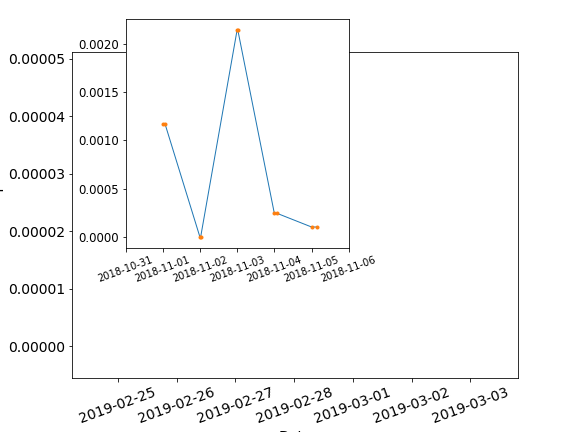

In [294]:
def add_subplot_axes(ax,rect):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
rect = [0.12,0.4,0.5,0.7]
ax1 = add_subplot_axes(ax,rect)


sort_index = np.argsort(n_times)

ax.plot(n_times[sort_index], n_vals[sort_index], lw=1)
ax.plot(n_times[sort_index], n_vals[sort_index], ".")
# plt.plot(pd.to_datetime(concat_R.starttime), concat_R.datapoints/(4*concat_R.n_images), ".")
ax.set_ylabel("Detected GP per AP")
ax.set_xlabel("Date")
# plt.xlim([datetime.datetime(2018, 9, 15), 
#           datetime.datetime(2019, 2, 1)])
for tick in ax.xaxis.get_major_ticks():
#                 tick.label.set_fontsize(10)
                tick.label.set_rotation(20)
            
# for tick in ax.yaxis.get_major_ticks():
#                 tick.label.set_fontsize(10)

# plt.plot(endtimes[sort_index],vals[sort_index], lw=10 )


sort_index = np.argsort(n_times)

ax1.plot(n_times[sort_index], n_vals[sort_index], lw=1)
ax1.plot(n_times[sort_index], n_vals[sort_index], ".")

# plt.plot(pd.to_datetime(concat_R.starttime), concat_R.datapoints/(4*concat_R.n_images), ".")
# ax1.ylabel("detected GP per AP")
# ax1.xlabel("Date")
# ax1.set_xtick(fontsize=18)
# ax1.set_xticks([])
# ax1.set_yticks([])

for tick in ax1.xaxis.get_major_ticks():
#                 tick.label.set_fontsize(10)
                tick.label.set_rotation(20)
            
# for tick in ax1.yaxis.get_major_ticks():
#                 tick.label.set_fontsize(10)

ax1.set_xlim([datetime.datetime(2018, 10, 31), 
          datetime.datetime(2018, 11, 6)])


# plt.tight_layout()
# plt.savefig("/home/kuiack/B0950+08_figs/time-correlation.pdf")

plt.show()


In [295]:
all_GP.to_csv("~/AS_PSR_all_GP_Jul8.csv")

In [8]:
all_GP_db = pd.read_csv("~/AS_PSR_all_GP.csv")

(array([  4.,   5.,   4.,  10.,  10.,   8.,  14.,  17.,  16.,  18.,  18.,
         21.,   9.,  11.,   5.,   9.,  12.,  11.,   4.,   3.,   8.,   7.,
          8.,   4.,   4.,   4.,   3.,   1.,   2.,   1.,   2.,   2.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]), array([  7.8107517 ,   8.06044208,   8.31013245,   8.55982282,
          8.8095132 ,   9.05920357,   9.30889395,   9.55858432,
          9.80827469,  10.05796507,  10.30765544,  10.55734582,
         10.80703619,  11.05672656,  11.30641694,  11.55610731,
         11.80579769,  12.05548806,  12.30517843,  12.55486881,

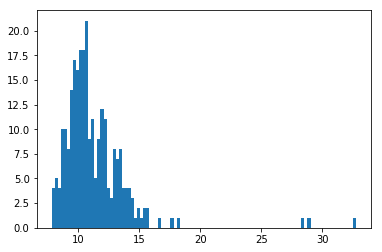

In [331]:
plt.hist(all_GP.f_peak/all_GP.det_sigma, bins=100)

### Get all GP and flux scale.

In [8]:
try:
    db._configured = False
    del db, session
except NameError:
    print "Clean"

Clean


In [301]:
ref_cat = pd.read_csv("~/AARTFAAC_catalogue.csv")

all_GP = pd.DataFrame({"f_int":[],"f_int_err":[],"det_sigma":[],
                       "f_peak":[],"f_peak_err":[],
                       "ra":[],"decl":[],
                       "db":[],"id":[],
                       "band":[],"taustart_ts":[],"freq_eff":[]})

concat_R = pd.read_csv("~/All_PSR_db_Jul8.csv")


for ind, GP_db in concat_R.iterrows():
    if GP_db.datapoints == 0.0:
        continue 
    
    print "name:", GP_db.db
    dataset = "1"

    logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)
    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=GP_db.db)

    db.connect()
    session = db.Session()

    transient_query = """
        SELECT ex.f_int, ex.f_int_err, ex.f_peak, ex.f_peak_err,
            ex.det_sigma, ex.extract_type, 
            ex.ra,
            ex.decl,
            im.band,
            im.taustart_ts,
            im.freq_eff
        FROM extractedsource ex, image im 
        WHERE ex.id IN ( SELECT xtrsrc FROM assocxtrsource WHERE runcat =  {})
        AND ex.image = im.id ORDER BY im.taustart_ts DESC;""".format(GP_db.id)


    GP_values = pd.DataFrame(run_query(transient_query, GP_db.db, 
                                       dataset, engine, host, port, user, password))
    
    db._configured = False
    del db, session
    
#     print GP_values


    if GP_db.db[:3] == "ASf":
        # get the points directly
        all_GP = all_GP.append(pd.DataFrame({"f_int":GP_values.f_int,
                                             "f_int_err":GP_values.f_int_err,
                                             "f_peak":GP_values.f_peak,
                                             "f_peak_err":GP_values.f_peak_err,
                                             "det_sigma":GP_values.det_sigma,
                                             "ra":GP_values.ra, "decl":GP_values.decl,
                                             "db":GP_db.db, "id":GP_db.id,
                                             "band":GP_values.band, "taustart_ts":GP_values.taustart_ts,
                                             "freq_eff":GP_values.freq_eff}), ignore_index=True)


    elif GP_db.db[:3] == "ASr":
        # Get the points and flux scale. 

        for gp_ind,raw_GP in GP_values.iterrows():

            db = tkp.db.Database(engine=engine, host=host, port=port,
                                 user=user, password=password, database=GP_db.db)

            db.connect()
            session = db.Session()


            transient_query = """SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl 
            FROM extractedsource ex 
            WHERE ex.image = (SELECT id FROM image 
            WHERE taustart_ts = '{}' AND band = {});""".format(raw_GP.taustart_ts,
                                                               raw_GP.band)


            image_pyse = pd.DataFrame(run_query(transient_query, GP_db.db, dataset, 
                                                engine, host, port, user, password))
            db._configured = False
            del db, session


            slope_cor, intercept_cor, ref_match, image_match, index_match = compare_flux(image_pyse,
                                               ref_cat["ra"],
                                               ref_cat["decl"],
                                               ref_cat["f_int"],
                                               ref_cat["f_int_err"])

            all_GP = all_GP.append(pd.DataFrame({"f_int":[(raw_GP.f_int - intercept_cor)/slope_cor],
                                         "f_int_err":[(raw_GP.f_int_err - intercept_cor)/slope_cor],
                                                 "f_peak":[(raw_GP.f_peak - intercept_cor)/slope_cor],
                                         "f_peak_err":[(raw_GP.f_peak_err - intercept_cor)/slope_cor],   
                                         "det_sigma":[raw_GP.det_sigma],
                                         "ra":[raw_GP.ra], "decl":[raw_GP.decl],
                                         "db":[GP_db.db], "id":[GP_db.id],
                                         "band":[raw_GP.band], "taustart_ts":[raw_GP.taustart_ts],
                                         "freq_eff":[raw_GP.freq_eff]}), ignore_index=True)


name: ASf_201803251830
name: ASf_201804141730
name: ASf_201804281040
name: ASf_201807051014
name: ASf_20181103
name: ASf_20181104
name: ASf_20181105
name: ASf_201812160230
name: ASf_20190101
name: ASf_20190117
name: ASf_20190126
name: ASf_20190127
name: ASf_201905101514
name: ASf_201905211455
name: ASr_201611120632
name: ASr_201611140501
name: ASr_201810170300
name: ASr_201810210800
name: ASr_20181024
name: ASr_20181025
name: ASr_20181026
name: ASr_20181027
name: ASr_20181028
name: ASr_20181101


In [97]:
all_GP[(all_GP.db =="ASf_201804141730") &\
      (all_GP.freq_eff > 60000000)].f_int

6      87.776921
7      75.515079
8      88.335800
9      89.721093
10     70.268480
11     66.686136
12     65.170539
13     72.840033
14     84.751042
15     53.289617
16     54.422245
17     85.846275
18     62.296566
19     70.631627
22    111.319177
23     60.161925
24     58.895686
25     72.426383
26    119.785686
27     67.401336
28     58.678409
29     64.003105
30     71.115236
32     65.770902
33    155.008881
34     77.552644
35     60.462257
46     77.954225
47     55.965201
48     55.122748
49     56.748761
53     88.742439
54     87.730490
55     79.942912
56     80.448500
57     83.993999
58     95.769468
60     81.097327
61     93.343504
62     76.168778
63     88.470824
64    102.369327
66    111.102719
Name: f_int, dtype: float64

In [302]:
all_GP.to_csv("~/AS_PSR_all_GP_Jul8.csv")

In [13]:
TF_index = np.argsort(all_GP.f_peak/all_GP.det_sigma)

In [303]:
print len(all_GP), "giant pulses"

275 giant pulses


In [304]:
concat_R

db  datapoints       id  n_images            starttime  \
0   ASf_201803091515         0.0      NaN   12428.0  2018-03-09 15:15:13   
1   ASf_201803251830         5.0   1457.0   12427.0  2018-03-25 18:30:10   
2   ASf_201803261842         0.0      NaN   12223.0  2018-03-26 14:50:57   
3   ASf_201804141730        63.0    464.0   12429.0  2018-04-12 14:40:16   
4   ASf_201804281040         1.0   4332.0   11489.0  2018-03-18 17:17:46   
5   ASf_201804301510         0.0      NaN   11961.0  2018-04-30 15:10:24   
6   ASf_201807051014         7.0    695.0   12429.0  2018-07-05 12:40:07   
7       ASf_20181103        11.0    243.0    1281.0  2018-11-03 08:00:10   
8       ASf_20181104         7.0    505.0    7151.0  2018-11-04 06:16:11   
9       ASf_20181105         5.0   1345.0   11895.0  2018-11-05 04:53:11   
10  ASf_201811250217         0.0      NaN   12345.0  2018-11-25 02:19:00   
11  ASf_201812160230         6.0   2932.0   10756.0  2018-12-16 02:32:00   
12      ASf_20181231         0.0      NaN     983.0  2018-12-31 04:17:00   
13      ASf_20190101        16.0   1846.0   12343.0  2019-01-01 00:22:00   
14      ASf_20190113         0.0      NaN   12342.0  2019-01-13 00:02:00   
15      ASf_20190117         2.0   2142.0   12341.0  2019-01-17 16:32:00   
16      ASf_20190118         0.0      NaN   12341.0  2019-01-18 21:13:00   
17      ASf_20190126         4.0  15810.0    9854.0  2019-01-26 05:03:00   
18      ASf_20190127        18.0    480.0    9854.0  2019-01-26 13:59:27   
19      ASf_20190129         0.0      NaN    3010.0  2019-01-29 03:57:00   
20  ASf_201902232216         0.0      NaN    9492.0  2019-02-23 22:18:00   
21  ASf_201903061500         0.0      NaN    7870.0  2019-03-06 15:02:00   
22  ASf_201903101700         0.0      NaN   12336.0  2019-03-10 17:02:00   
23  ASf_201905101514         3.0   1736.0   12339.0  2019-05-10 15:16:00   
24  ASf_201905211455        11.0   1495.0   12334.0  2019-05-21 14:57:00   
25  ASr_201609070340         0.0      NaN    3690.0  2016-09-07 03:40:10   
26  ASr_201611120632         3.0    332.0    4219.0  2016-11-12 06:32:12   
27  ASr_201611140501        10.0    226.0    9270.0  2016-11-14 05:01:11   
28  ASr_201809220609         0.0      NaN    2908.0  2018-09-22 06:09:11   
29  ASr_201809230412         0.0      NaN    4943.0  2018-09-23 04:12:11   
30  ASr_201809280900         0.0      NaN    5050.0  2018-09-28 09:18:54   
31  ASr_201809290600         0.0      NaN    2820.0  2018-09-29 06:00:10   
32  ASr_201810170300        46.0   1112.0   12429.0  2018-10-17 03:00:10   
33  ASr_201810210800         6.0    119.0    4348.0  2018-10-21 08:00:10   
34      ASr_20181024         3.0    908.0    7194.0  2018-10-16 20:00:10   
35      ASr_20181025         8.0    720.0    7005.0  2018-10-25 07:00:10   
36      ASr_20181026         8.0    460.0    6769.0  2018-10-01 13:35:03   
37      ASr_20181027         4.0    486.0    6533.0  2018-10-27 07:00:10   
38      ASr_20181028         3.0    209.0    2696.0  2018-10-28 08:00:11   
39      ASr_20181029         0.0      NaN    6050.0  2018-10-29 07:00:21   
40      ASr_20181101        25.0    117.0    5343.0  2018-11-01 07:00:10   
41      ASr_20181102         0.0      NaN    1517.0  2018-11-02 08:00:10   

     wm_decl       wm_ra  
0        NaN         NaN  
1   7.622665  148.567882  
2        NaN         NaN  
3   7.664419  148.565073  
4   7.644835  148.578824  
5        NaN         NaN  
6   7.669331  148.610388  
7   7.717152  148.499685  
8   7.638990  148.528693  
9   7.624190  148.525934  
10       NaN         NaN  
11  7.580112  149.060752  
12       NaN         NaN  
13  7.770422  148.858295  
14       NaN         NaN  
15  7.588084  148.595147  
16       NaN         NaN  
17  7.867089  148.654961  
18  7.680926  148.579909  
19       NaN         NaN  
20       NaN         NaN  
21       NaN         NaN  
22       NaN         NaN  
23  7.756482  148.599810  
24  7.709569  148.607699  
25       NaN         NaN  
26  7.705045  148.54

In [25]:
all_GP.sort_values("f_int")

Unnamed: 0  band                db      decl  det_sigma       f_int  \
133         133  24.0      ASf_20190127  7.732051   5.041714   41.791718   
81           81  24.0      ASf_20181103  7.773221   5.122319   42.397886   
92           92  24.0      ASf_20181104  7.692880   5.023136   44.879165   
129         129  24.0      ASf_20190127  7.741710   5.065370   45.339172   
236         236  23.0      ASr_20181101  7.642156   5.183183   46.491840   
201         201  24.0  ASr_201810170300  7.823496   5.243691   46.534971   
259         259  23.0      ASr_20181101  7.713931   5.463313   46.759655   
246         246  24.0      ASr_20181101  7.714820   5.131508   46.891670   
205         205  23.0  ASr_201810210800  7.841809   5.063023   47.054201   
132         132  24.0      ASf_20190127  7.554740   5.139137   47.272990   
210         210  24.0      ASr_20181024  7.515067   5.337143   47.563284   
38           38  23.0  ASf_201804141730  7.562381   5.706342   47.588595   
168         168  23.0  ASr_201810170300  7.523015   5.604887   47.728174   
130         130  24.0      ASf_20190127  7.687217   5.165642   47.761838   
96           96  23.0      ASf_20181105  7.485392   5.122126   47.862269   
76           76  23.0      ASf_20181103  7.856461   5.462431   48.062175   
232         232  24.0      ASr_20181027  7.688608   5.729045   48.201059   
220         220  23.0      ASr_20181025  7.622666   5.152491   48.319689   
3             3  23.0  ASf_201803251830  7.524792   5.444269   48.359088   
82           82  23.0      ASf_20181103  7.821197   5.673277   48.509672   
99           99  23.0  ASf_201812160230  7.579298   5.016997   48.584639   
84           84  23.0      ASf_20181103  7.585266   5.348864   48.676079   
116         116  23.0      ASf_20190101  8.302040   6.133368   49.102279   
248         248  23.0      ASr_20181101  7.749742   5.233840   49.770819   
180         180  23.0  ASr_201810170300  7.584308   5.495090   49.930919   
169         169  23.0  ASr_201810170300  7.565728   5.108064   50.034881   
260         260  24.0      ASr_20181101  7.568437   5.655872   50.499616   
212         212  24.0      ASr_20181024  7.643263   5.500112   50.717234   
241         241  23.0      ASr_20181101  7.679922   5.084318   51.115091   
254         254  23.0      ASr_20181101  7.520377   5.029054   51.147265   
..          ...   ...               ...       ...        ...         ...   
165         165  23.0  ASr_201810170300  7.869634   6.820441   93.118816   
61           61  24.0  ASf_201804141730  7.838331   6.081141   93.343504   
73           73  24.0  ASf_201807051014  7.692925   6.449645   95.623828   
58           58  24.0  ASf_201804141730  7.754717   5.906105   95.769468   
109         109  24.0      ASf_20190101  7.528336   7.238381   97.319811   
69           69  23.0  ASf_201807051014  7.694262   6.487231   97.924116   
83           83  23.0      ASf_20181103  7.612135   9.314706  100.267798   
64           64  24.0  ASf_201804141730  7.716337   8.095227  102.369327   
214         214  24.0      ASr_20181025  7.771429   9.193067  104.695399   
51           51  23.0  ASf_201804141730  7.768188   7.114850  105.716938   
78           78  23.0      ASf_20181103  7.774205   8.238684  108.144303   
4             4  23.0  ASf_201803251830  7.679681   6.924313  109.573306   
66           66  24.0  ASf_201804141730  7.691509   8.372458  111.102719   
22           22  24.0  ASf_201804141730  7.609527   9.775490  111.319177   
157         157  24.0  ASr_201611140501  7.670821   8.289440  112.225916   
199         199  23.0  ASr_201810170300  7.677875  10.213527  112.734255   
79           79  23.0      ASf_20181103  7.681868   9.224145  112.835278   
167         167  24.0  ASr_201810170300  7.792976   9.596244  112.985646   
141         141  24.0      ASf_20190127  7.662833   7.985887  113.914980   
128         128  24.0      ASf_20190127  7.805720   7.416598  118.053059   
26           26  24.0  ASf_201804141730  7.582160   9

In [21]:
x = (np.sort(all_GP[(all_GP.freq_eff < 60000000) & (all_GP.sort_values("f_int").f_int/all_GP.sort_values("f_int").det_sigma < 20)].f_int) *1000.)/55.35


max: 3949.95252143 218.629872061 min 839.960980954
[  2.11627147e-04  -4.69027699e+00]
max: 3209.32364594 177.636063803 min 755.044585279
[  6.83010428e-05  -4.43094562e+00]


/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


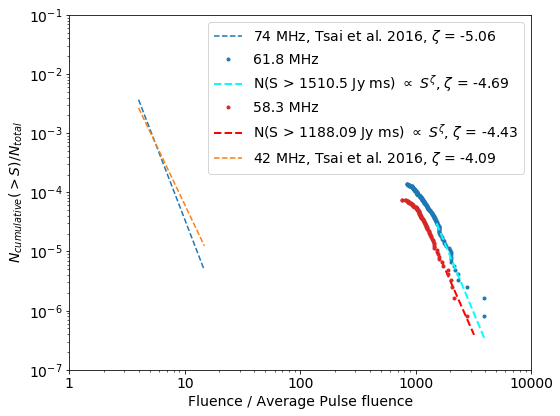

Predicted fluence ratio at n_cumulative / n_total = 1  



In [5]:

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14
       }



matplotlib.rc('font', **font)




# x = (np.sort(all_GP.f_int.values) *1000.)/55.35
# y = np.array((np.array(range(len(all_GP.f_int.values))[::-1])))/(4.*concat_R.n_images.sum())

# print "max:", np.max(x), "min", np.min(x)



# TF_index = np.argsort(all_GP.f_peak/all_GP.det_sigma)
# all_GP[(all_GP.db =="ASf_201804141730") & (all_GP.freq_eff > 60000000)].f_int

x = (np.sort(all_GP[(all_GP.freq_eff > 60000000) ].f_int) *1000.)/55.35
print "max:", np.max(x),np.max(x)/1000.*55.35, "min", np.min(x)

y = np.array((np.array(range(len(x))[::-1])))/(4.*concat_R.n_images.sum())



flux_limit = x[-40]#65000/55.35

fit, cov = curve_fit(powlaw, x[(x > flux_limit)]/1000., y[(x > flux_limit)])

print fit

fig1, ax1 = plt.subplots(figsize=(8,6))




# ax1.plot(np.logspace(1,1.5)/2., powlaw(np.logspace(1,1.5),137., -5.06),"--", 
#          label="42 MHz, Tsai et al. 2016, "r"$\zeta$ = -5.06")

ax1.plot(np.logspace(0.6,1.17), powlaw(np.logspace(0.6,1.17),4., -5.06),"--", 
         label="74 MHz, Tsai et al. 2016, "r"$\zeta$ = -5.06")

ax1.plot(x,y, ".", label="61.8 MHz", c="C0")

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylabel(r"$N_{cumulative}( > S)/N_{total}$")
ax1.set_xlabel("Fluence / Average Pulse fluence")
ax1.set_xlim([1,10000])
ax1.set_ylim([1e-6,0.1])

# ax1.set_xticks([50,80,100, 120,140] )

# for axis in [ax1.xaxis, ax1.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())
ax1.xaxis.set_major_formatter(ScalarFormatter())

ax1.plot(x[(x > flux_limit)],
         powlaw(x[(x > flux_limit)]/1000.,fit[0],fit[1]), "--", c="cyan",lw =2, 
         label="N(S > {} Jy ms) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit))







# plt.show()
# plt.savefig("/home/kuiack/Ngt60.png")

x = (np.sort(all_GP[(all_GP.freq_eff < 60000000)].f_int) *1000.)/55.35

print "max:", np.max(x),np.max(x)/1000.*55.35, "min", np.min(x)

y = np.array((np.array(range(len(x))[::-1])))/(4.*concat_R.n_images.sum())



flux_limit = x[-40]#65000/55.35

fit, cov = curve_fit(powlaw, x[(x > flux_limit)]/1000., y[(x > flux_limit)])

print fit

# fig1, ax1 = plt.subplots(figsize=(8,6))

ax1.plot(x,y, ".", label="58.3 MHz", zorder=3, c="C3")

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylabel(r"$N_{cumulative}( > S)/N_{total}$")
ax1.set_xlabel("Fluence / Average Pulse fluence")
ax1.set_xlim([1,10000])
ax1.set_ylim([1e-7,0.1])

# ax1.set_xticks([50,80,100, 120,140] )

# for axis in [ax1.xaxis, ax1.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())
ax1.xaxis.set_major_formatter(ScalarFormatter())

ax1.plot(x[(x > flux_limit)],
         powlaw(x[(x > flux_limit)]/1000., fit[0], fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy ms) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit),zorder=0)

# ax1.plot(np.logspace(1,1.5)/2., powlaw(np.logspace(1,1.5),13., -4.09), "--", 
#          label="74 MHz, Tsai et al. 2016, "r"$\zeta$ = -4.09"  )

ax1.plot(np.logspace(0.6,1.17), powlaw(np.logspace(0.6,1.17),0.76, -4.09), "--", 
         label="42 MHz, Tsai et al. 2016, "r"$\zeta$ = -4.09"  )

ax1.legend()
plt.tight_layout()

plt.savefig("/home/kuiack/B0950+08_figs/GPbothfreq.png")

plt.show()


print "Predicted fluence ratio at n_cumulative / n_total = 1  \n"

# print "LWA 74 MHz:", so.root(min_powlaw, 0.1, args = (4., -5.06, 1.0) )["x"]

# print "AARTFAAC 61.8 MHz:", so.root(min_powlaw, 0.1, args = (2.11627147e-04,  -4.69027699e+00, 1.0) )["x"]*1000.
# print "AARTFAAC 58.3 MHz:", so.root(min_powlaw, 0.1, args = (6.83010428e-05,  -4.43094562e+00, 1.0) )["x"]*1000.

# print "LWA 42 MHz:", so.root(min_powlaw, 0.1, args = (0.76, -4.09, 1.0) )["x"]

## Completeness 

7
22
42
48
max: 2800.52178157 min 1266.69784549
18
14


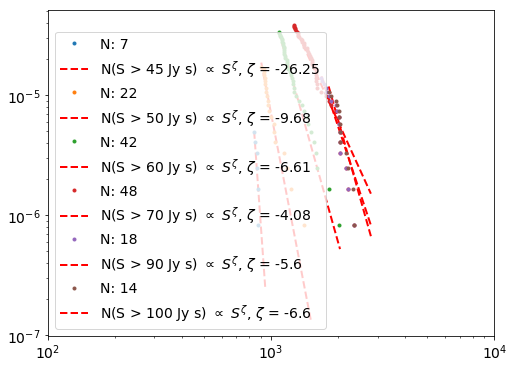

In [85]:

plt.figure(1, figsize=(8,6))

Smin = 45

index = ((all_GP.f_int/all_GP.det_sigma*5 < Smin )  & (all_GP.f_int > Smin ) & ( all_GP.freq_eff > 60000000.0)).values 
print np.sum(index)

x = (np.sort(all_GP[index].f_int) *1000.)/55.35
# print "max:", np.max(x), "min", np.min(x)

y = np.array((np.array(range(len(all_GP[index].f_int))[::-1])))/(4.*concat_R.n_images.sum())


fit, cov = curve_fit(powlaw, x/1000., y)

plt.plot(x,y, ".", label="N: "+str(np.sum(index)))

plt.plot(x,
         powlaw(x/1000., fit[0], fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy s) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( Smin , 
                                                        round(fit[1],2)),zorder=0)
plt.xscale("log")
plt.yscale("log")



Smin = 50

index = ((all_GP.f_int/all_GP.det_sigma*5 < Smin )  & (all_GP.f_int > Smin ) & ( all_GP.freq_eff > 60000000.0)).values 
print np.sum(index)


x = (np.sort(all_GP[index].f_int) *1000.)/55.35
# print "max:", np.max(x), "min", np.min(x)

y = np.array((np.array(range(len(all_GP[index].f_int))[::-1])))/(4.*concat_R.n_images.sum())


fit, cov = curve_fit(powlaw, x/1000., y)


plt.plot(x,y, ".", label="N: "+str(np.sum(index)))

plt.plot(x,
         powlaw(x/1000., fit[0], fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy s) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( Smin , 
                                                        round(fit[1],2)),zorder=0)


plt.xscale("log")
plt.yscale("log")
# ax1.set_xlim([100,10000])
# ax1.set_ylim([1e-6,1e-3])

Smin = 60

index = ((all_GP.f_int/all_GP.det_sigma*5 < Smin )  & (all_GP.f_int > Smin ) & ( all_GP.freq_eff > 60000000.0)).values  
print np.sum(index)


x = (np.sort(all_GP[index].f_int) *1000.)/55.35
# print "max:", np.max(x), "min", np.min(x)

y = np.array((np.array(range(len(all_GP[index].f_int))[::-1])))/(4.*concat_R.n_images.sum())


fit, cov = curve_fit(powlaw, x/1000., y)


plt.plot(x,y, ".", label="N: "+str(np.sum(index)))

plt.plot(x,
         powlaw(x/1000., fit[0], fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy s) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( Smin , 
                                                        round(fit[1],2)),zorder=0)

plt.xscale("log")
plt.yscale("log")

Smin = 70
index = ((all_GP.f_int/all_GP.det_sigma*5 < Smin )  & (all_GP.f_int > Smin ) & ( all_GP.freq_eff > 60000000.0)).values 
print np.sum(index)


x = (np.sort(all_GP[index].f_int) *1000.)/55.35
print "max:", np.max(x), "min", np.min(x)

y = np.array((np.array(range(len(all_GP[index].f_int))[::-1])))/(4.*concat_R.n_images.sum())


fit, cov = curve_fit(powlaw, x/1000., y)


plt.plot(x,y, ".", label="N: "+str(np.sum(index)))

plt.plot(x,
         powlaw(x/1000., fit[0], fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy s) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( Smin , 
                                                        round(fit[1],2)),zorder=0)
plt.xscale("log")
plt.yscale("log")


Smin = 90

index = ((all_GP.f_int/all_GP.det_sigma*5 < Smin )  & (all_GP.f_int > Smin ) & ( all_GP.freq_eff > 60000000.0)).values 
print np.sum(index)

x = (np.sort(all_GP[index].f_int) *1000.)/55.35
# print "max:", np.max(x), "min", np.min(x)

y = np.array((np.array(range(len(all_GP[index].f_int))[::-1])))/(4.*concat_R.n_images.sum())


fit, cov = curve_fit(powlaw, x/1000., y)

plt.plot(x,y, ".", label="N: "+str(np.sum(index)))

plt.plot(x,
         powlaw(x/1000., fit[0], fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy s) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( Smin , 
                                                        round(fit[1],2)),zorder=0)
plt.xscale("log")
plt.yscale("log")


Smin = 100

index = ((all_GP.f_int/all_GP.det_sigma*5 < Smin )  & (all_GP.f_int > Smin ) & ( all_GP.freq_eff > 60000000.0)).values 
print np.sum(index)

x = (np.sort(all_GP[index].f_int) *1000.)/55.35
# print "max:", np.max(x), "min", np.min(x)

y = np.array((np.array(range(len(all_GP[index].f_int))[::-1])))/(4.*concat_R.n_images.sum())


fit, cov = curve_fit(powlaw, x/1000., y)

plt.plot(x,y, ".", label="N: "+str(np.sum(index)))

plt.plot(x,
         powlaw(x/1000., fit[0], fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy s) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( Smin , 
                                                        round(fit[1],2)),zorder=0)
plt.xscale("log")
plt.yscale("log")


plt.legend()


plt.xlim([100,10000])
plt.show()



In [99]:
Smin = 61
index = ((all_GP.f_int/all_GP.det_sigma*5 < Smin )  
         & (all_GP.f_int > Smin )).values 
print np.sum(index)


all_GP[index].sort_values("f_int")

71


Unnamed: 0  band                db      decl  det_sigma       f_int  \
59           59  23.0  ASf_201804141730  7.741644   5.204657   61.140419   
227         227  24.0      ASr_20181026  7.752704   5.959181   61.177572   
87           87  24.0      ASf_20181104  7.822511   5.119617   61.197219   
44           44  23.0  ASf_201804141730  7.750657   5.739816   61.268959   
215         215  24.0      ASr_20181025  7.871138   5.082877   61.376278   
1             1  23.0  ASf_201803251830  7.496806   5.963842   61.730469   
231         231  23.0      ASr_20181027  7.848237   5.673359   61.930950   
173         173  23.0  ASr_201810170300  7.716706   6.129146   61.942615   
95           95  23.0      ASf_20181105  7.658076   5.112349   62.252508   
18           18  24.0  ASf_201804141730  7.679467   5.495883   62.296566   
74           74  24.0  ASf_201807051014  7.662824   5.318125   62.338856   
158         158  23.0  ASr_201810170300  7.873992   5.912992   62.497029   
147         147  23.0  ASr_201611120632  7.620686   5.724463   63.070300   
250         250  23.0      ASr_20181101  7.624638   5.473701   63.136353   
257         257  23.0      ASr_20181101  7.705000   5.868326   63.259491   
219         219  23.0      ASr_20181025  7.743955   6.423410   63.491333   
249         249  23.0      ASr_20181101  7.731028   6.198060   63.534710   
197         197  23.0  ASr_201810170300  7.697450   6.125056   63.753925   
149         149  24.0  ASr_201611140501  7.651918   5.389899   63.892983   
100         100  23.0  ASf_201812160230  7.524126   5.962798   63.904592   
21           21  23.0  ASf_201804141730  7.728506   6.627357   64.405124   
160         160  24.0  ASr_201810170300  7.937278   5.995398   64.667942   
138         138  24.0      ASf_20190127  7.742729   6.649799   64.999447   
12           12  24.0  ASf_201804141730  7.661197   5.702536   65.170539   
216         216  23.0      ASr_20181025  7.842325   5.761146   65.175866   
77           77  23.0      ASf_20181103  7.736267   6.383638   65.204541   
170         170  23.0  ASr_201810170300  7.684890   6.655275   65.455190   
186         186  24.0  ASr_201810170300  7.643299   7.182573   65.925386   
145         145  23.0  ASr_201611120632  7.749284   5.707482   65.941015   
36           36  23.0  ASf_201804141730  7.572510   7.414366   66.215699   
..          ...   ...               ...       ...        ...         ...   
247         247  23.0      ASr_20181101  7.733952   6.723057   70.111726   
176         176  23.0  ASr_201810170300  7.638892   6.059035   70.265941   
19           19  24.0  ASf_201804141730  7.654368   5.792122   70.631627   
196         196  23.0  ASr_201810170300  7.701723   6.467916   71.484741   
162         162  24.0  ASr_201810170300  7.886141   7.583942   72.446808   
185         185  23.0  ASr_201810170300  7.727172   6.014216   73.074999   
172         172  23.0  ASr_201810170300  7.722034   6.837931   74.006111   
164         164  24.0  ASr_201810170300  7.756088   7.579371   75.015981   
198         198  23.0  ASr_201810170300  7.590257   7.048998   76.452168   
50           50  23.0  ASf_201804141730  7.663233   8.423992   77.312523   
251         251  23.0      ASr_20181101  7.713568   8.586098   77.608969   
159         159  24.0  ASr_201810170300  7.668849   7.826301   79.645342   
161         161  24.0  ASr_201810170300  7.925633   7.639994   79.952515   
191         191  23.0  ASr_201810170300  7.635324   7.383349   80.417663   
166         166  24.0  ASr_201810170300  7.797931   7.413680   80.494905   
86           86  23.0      ASf_20181103  7.740702   7.139026   81.359523   
182         182  23.0  ASr_201810170300  7.735543   6.799303   82.002261   
106         106  24.0      ASf_20190101  7.663650   8.362047   83.606288   
17           17  24.0  ASf_201804141730  7.695055   7.190003   85.846275   
45           45  23.0  ASf_201804141730  7.688757   7.104947   86.329264   
122         122  23.0      ASf_20190117  7.577356   8

In [102]:
all_GP.iloc[np.argsort(all_GP.f_peak.values/all_GP.det_sigma.values)]

Unnamed: 0  band                db      decl  det_sigma       f_int  \
116         116  23.0      ASf_20190101  8.302040   6.133368   49.102279   
133         133  24.0      ASf_20190127  7.732051   5.041714   41.791718   
81           81  24.0      ASf_20181103  7.773221   5.122319   42.397886   
38           38  23.0  ASf_201804141730  7.562381   5.706342   47.588595   
114         114  23.0      ASf_20190101  7.640792   6.769907   56.316452   
168         168  23.0  ASr_201810170300  7.523015   5.604887   47.728174   
232         232  24.0      ASr_20181027  7.688608   5.729045   48.201059   
82           82  23.0      ASf_20181103  7.821197   5.673277   48.509672   
259         259  23.0      ASr_20181101  7.713931   5.463313   46.759655   
76           76  23.0      ASf_20181103  7.856461   5.462431   48.062175   
37           37  23.0  ASf_201804141730  7.640488   5.837643   51.210555   
201         201  24.0  ASr_201810170300  7.823496   5.243691   46.534971   
3             3  23.0  ASf_201803251830  7.524792   5.444269   48.359088   
92           92  24.0      ASf_20181104  7.692880   5.023136   44.879165   
129         129  24.0      ASf_20190127  7.741710   5.065370   45.339172   
210         210  24.0      ASr_20181024  7.515067   5.337143   47.563284   
236         236  23.0      ASr_20181101  7.642156   5.183183   46.491840   
260         260  24.0      ASr_20181101  7.568437   5.655872   50.499616   
235         235  23.0      ASr_20181028  7.825029   5.819899   52.152045   
84           84  23.0      ASf_20181103  7.585266   5.348864   48.676079   
36           36  23.0  ASf_201804141730  7.572510   7.414366   66.215699   
246         246  24.0      ASr_20181101  7.714820   5.131508   46.891670   
180         180  23.0  ASr_201810170300  7.584308   5.495090   49.930919   
132         132  24.0      ASf_20190127  7.554740   5.139137   47.272990   
130         130  24.0      ASf_20190127  7.687217   5.165642   47.761838   
251         251  23.0      ASr_20181101  7.713568   8.586098   77.608969   
212         212  24.0      ASr_20181024  7.643263   5.500112   50.717234   
96           96  23.0      ASf_20181105  7.485392   5.122126   47.862269   
205         205  23.0  ASr_201810210800  7.841809   5.063023   47.054201   
186         186  24.0  ASr_201810170300  7.643299   7.182573   65.925386   
..          ...   ...               ...       ...        ...         ...   
70           70  23.0  ASf_201807051014  7.692340   6.063119   84.385913   
126         126  24.0      ASf_20190126  7.654378   6.388489   89.500463   
60           60  24.0  ASf_201804141730  7.901461   5.722225   81.097327   
7             7  24.0  ASf_201804141730  7.671244   5.258072   75.515079   
213         213  24.0      ASr_20181025  7.910445   5.186481   74.024417   
55           55  24.0  ASf_201804141730  7.627462   5.578107   79.942912   
9             9  24.0  ASf_201804141730  7.827586   6.252694   89.721093   
112         112  23.0      ASf_20190101  7.741575   5.201048   75.039167   
141         141  24.0      ASf_20190127  7.662833   7.985887  113.914980   
118         118  24.0      ASf_20190101  7.925655   5.238130   76.925936   
156         156  24.0  ASr_201611140501  7.785958   5.190455   76.365711   
136         136  24.0      ASf_20190127  7.641491   5.814357   85.222918   
140         140  24.0      ASf_20190127  7.668809   6.370240   92.825900   
188         188  23.0  ASr_201810170300  7.734137   5.559518   83.186617   
73           73  24.0  ASf_201807051014  7.692925   6.449645   95.623828   
51           51  23.0  ASf_201804141730  7.768188   7.114850  105.716938   
69           69  23.0  ASf_201807051014  7.694262   6.487231   97.924116   
57           57  24.0  ASf_201804141730  7.642369   5.443046   83.993999   
61           61  24.0  ASf_201804141730  7.838331   6.081141   93.343504   
54           54  24.0  ASf_201804141730  7.587188   5.597681   87.730490   
56           56  24.0  ASf_201804141730  7.656401   5

## Clustering of active days

In [ ]:
#  "ASf_201804141730" 

plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(all_GP[(all_GP.db == "ASf_201804141730") & ( all_GP.freq_eff > 60000000.0) ].taustart_ts),
         all_GP[(all_GP.db == "ASf_201804141730") & ( all_GP.freq_eff > 60000000.0) ].f_int,"." )
plt.plot(pd.to_datetime(all_GP[(all_GP.db == "ASf_201804141730") & ( all_GP.freq_eff < 60000000.0) ].taustart_ts),
         all_GP[(all_GP.db == "ASf_201804141730") & ( all_GP.freq_eff < 60000000.0) ].f_int,"." )

x = plt.xticks(rotation=90)
plt.xlabel("Time [UTC]")
plt.ylabel("Flux [Jy]")

<IPython.core.display.Javascript object>


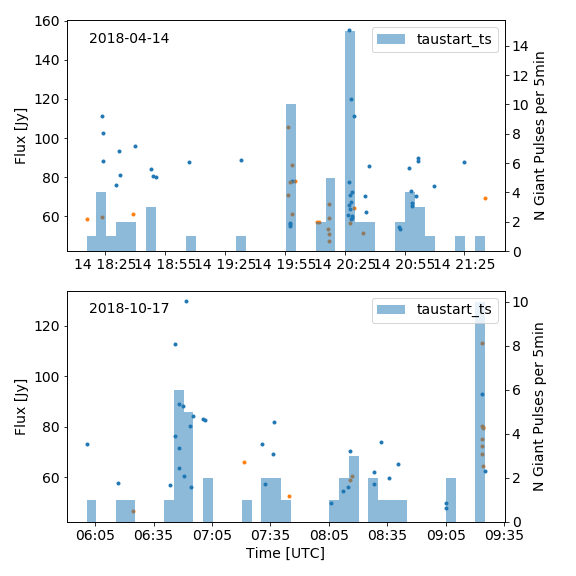

1.82856867284
1.71835416047


In [351]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14
       }
matplotlib.rc('font', **font)



plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
plt.plot(pd.to_datetime(all_GP[(all_GP.db == "ASf_201804141730") & ( all_GP.freq_eff > 60000000.0) ].taustart_ts),
         all_GP[(all_GP.db == "ASf_201804141730") & ( all_GP.freq_eff > 60000000.0) ].f_int, ".", label="61.8 MHz" )
plt.plot(pd.to_datetime(all_GP[(all_GP.db == "ASf_201804141730") & ( all_GP.freq_eff < 60000000.0) ].taustart_ts),
         all_GP[(all_GP.db == "ASf_201804141730") & ( all_GP.freq_eff < 60000000.0) ].f_int, ".", label="58.3 MHz" )

plt.text(0.05, 0.95, "2018-04-14", transform=ax1.transAxes, ha='left', va="top")


myFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(myFmt)


# x = plt.xticks(rotation=90)

ax1.set_ylabel("Flux [Jy]")

_interval = "5min"

_db = "ASf_201804141730"

Smin = 70
index = ((all_GP.f_int/all_GP.det_sigma*5 < Smin )  & (all_GP.f_int > Smin )& ( all_GP.freq_eff > 60000000.0) ).values 

# index = (( all_GP.freq_eff < 60000000.0) ).values

ax2 = ax1.twinx() 

# index = (True)

times = pd.to_datetime( all_GP[ (all_GP.db == _db) ].taustart_ts)

n = ax2.hist(times,
             bins=len(pd.date_range(start=np.min(pd.to_datetime( all_GP[(all_GP.db == _db) ].taustart_ts)),
                                    end=np.max(pd.to_datetime( all_GP[ (all_GP.db == _db) ].taustart_ts)),
             freq=_interval)), alpha=0.5, align="mid")

print np.std(n[0])/np.mean(n[0])

plt.legend()

plt.ylabel("N Giant Pulses per {}".format(_interval))
# plt.xlabel("Time [UTC]")

ax1 = plt.subplot(212)

plt.plot(pd.to_datetime(all_GP[(all_GP.db == "ASr_201810170300") & ( all_GP.freq_eff > 60000000.0) ].taustart_ts),
         all_GP[(all_GP.db == "ASr_201810170300") & ( all_GP.freq_eff > 60000000.0) ].f_int,".", label="61.8 MHz" )
plt.plot(pd.to_datetime(all_GP[(all_GP.db == "ASr_201810170300") & ( all_GP.freq_eff < 60000000.0) ].taustart_ts),
         all_GP[(all_GP.db == "ASr_201810170300") & ( all_GP.freq_eff < 60000000.0) ].f_int,".", label="58.3 MHz" )

# x = plt.xticks(rotation=90)

ax1.set_ylabel("Flux [Jy]")

_interval = "5min"

_db = "ASr_201810170300"

Smin = 70
index = ((all_GP.f_int/all_GP.det_sigma*5 < Smin )  & (all_GP.f_int > Smin )& ( all_GP.freq_eff > 60000000.0) ).values 

# index = (( all_GP.freq_eff < 60000000.0) ).values

ax2 = ax1.twinx() 

# index = (True)

times = pd.to_datetime( all_GP[ (all_GP.db == _db) ].taustart_ts)

n = ax2.hist(times,
             bins=len(pd.date_range(start=np.min(pd.to_datetime( all_GP[(all_GP.db == _db) ].taustart_ts)),
                                    end=np.max(pd.to_datetime( all_GP[ (all_GP.db == _db) ].taustart_ts)),
             freq=_interval).values), alpha=0.5, align="mid")

print np.std(n[0])/np.mean(n[0])

# x = times.dt.round(_interval).hist(bins=pd.date_range(start=np.min(pd.to_datetime( all_GP[(all_GP.db == _db) ].taustart_ts)),
#                                     end=np.max(pd.to_datetime( all_GP[ (all_GP.db == _db) ].taustart_ts)),
#              freq=_interval), alpha=0.5)

plt.text(0.05, 0.95, "2018-10-17", transform=ax1.transAxes, ha='left', va="top")

ax1.set_xlabel("Time [UTC]")
plt.ylabel("N Giant Pulses per {}".format(_interval))

myFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(myFmt)


# plt.ylim([40,140])
plt.legend(loc="upper right")
plt.tight_layout()

# plt.savefig("/home/kuiack/B0950+08_figs/pulsetime.pdf")
plt.show()

<IPython.core.display.Javascript object>


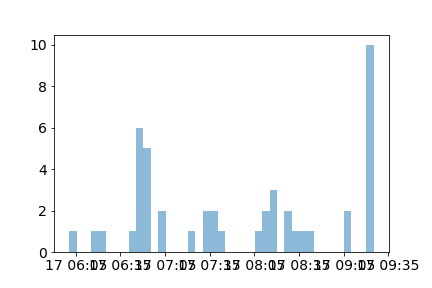

In [346]:
plt.figure()
plt.hist(times, 
             bins=len(pd.date_range(start=np.min(pd.to_datetime( all_GP[(all_GP.db == _db) ].taustart_ts)),
                                    end=np.max(pd.to_datetime( all_GP[ (all_GP.db == _db) ].taustart_ts)),
             freq=_interval).values), alpha=0.5, align="mid")
plt.show()

<IPython.core.display.Javascript object>


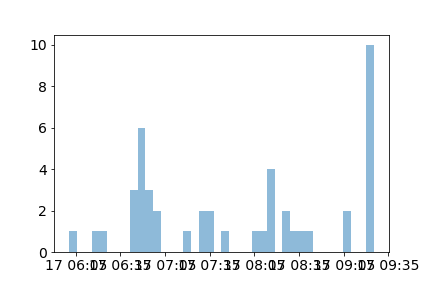

<IPython.core.display.Javascript object>


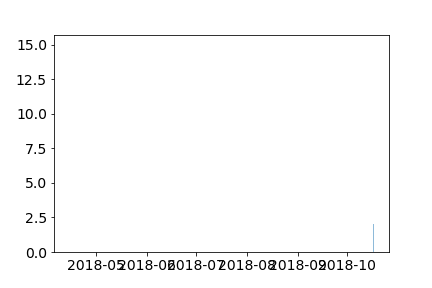

(array([  1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   6.,   5.,
          0.,   2.,   0.,   0.,   0.,   1.,   0.,   2.,   2.,   1.,   0.,
          0.,   0.,   0.,   1.,   2.,   3.,   0.,   2.,   1.,   1.,   1.,
          0.,   0.,   0.,   0.,   2.,   0.,   0.,  10.]),
 array([ 736984.25039352,  736984.25385755,  736984.25732159,
         736984.26078563,  736984.26424966,  736984.2677137 ,
         736984.27117773,  736984.27464177,  736984.2781058 ,
         736984.28156984,  736984.28503388,  736984.28849791,
         736984.29196195,  736984.29542598,  736984.29889002,
         736984.30235405,  736984.30581809,  736984.30928213,
         736984.31274616,  736984.3162102 ,  736984.31967423,
         736984.32313827,  736984.3266023 ,  736984.33006634,
         736984.33353037,  736984.33699441,  736984.34045845,
         736984.34392248,  736984.34738652,  736984.35085055,
         736984.35431459,  736984.35777862,  736984.36124266,
         736984.3647067 ,  736984.3681

In [328]:
_db = "ASf_201804141730"

plt.figure()
plt.hist(times, 
             bins=len(pd.date_range(start=np.min(pd.to_datetime( all_GP[(all_GP.db == _db) ].taustart_ts)),
                                    end=np.max(pd.to_datetime( all_GP[ (all_GP.db == _db) ].taustart_ts)),
             freq=_interval)), alpha=0.5, align="mid")

_db = "ASr_201810170300"

plt.figure()
plt.hist(times, 
             bins=len(pd.date_range(start=np.min(pd.to_datetime( all_GP[(all_GP.db == _db) ].taustart_ts)),
                                    end=np.max(pd.to_datetime( all_GP[ (all_GP.db == _db) ].taustart_ts)),
             freq=_interval)), alpha=0.5, align="mid")

<IPython.core.display.Javascript object>


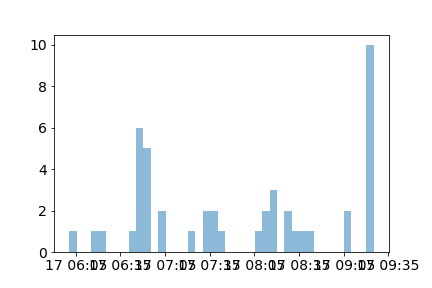

In [335]:
_interval = "5min"

_db = "ASr_201810170300"

Smin = 70
index = ((all_GP.f_int/all_GP.det_sigma*5 < Smin )  &\
         (all_GP.f_int > Smin ) &\
         ( all_GP.freq_eff > 60000000.0) ).values 

# index = (( all_GP.freq_eff < 60000000.0) ).values



# index = (True)

times = pd.to_datetime( all_GP[ (all_GP.db == _db) ].taustart_ts)
plt.figure()
plt.hist(times, 
             bins=len(pd.date_range(start=np.min(pd.to_datetime( all_GP[(all_GP.db == _db) ].taustart_ts)),
                                    end=np.max(pd.to_datetime( all_GP[ (all_GP.db == _db) ].taustart_ts)),
             freq=_interval)), alpha=0.5, align="mid")
plt.show()

<IPython.core.display.Javascript object>


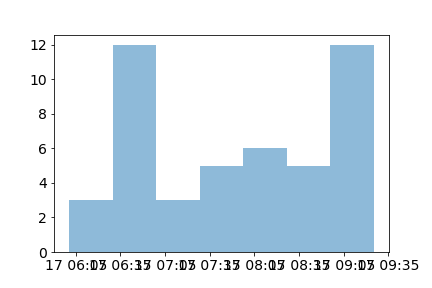

In [319]:
plt.figure()
plt.hist(times, 
             bins=len(pd.date_range(start=np.min(pd.to_datetime( all_GP[(all_GP.db == _db) ].taustart_ts)),
                                    end=np.max(pd.to_datetime( all_GP[ (all_GP.db == _db) ].taustart_ts)),
             freq=_interval)), alpha=0.5, align="mid")

plt.show()

Text(0.5,0,'Time [UTC]')

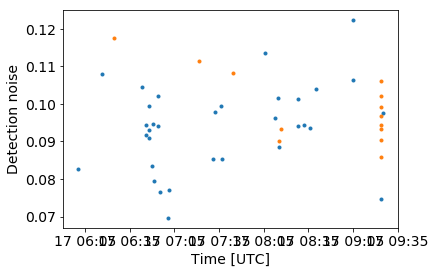

In [17]:
plt.plot(pd.to_datetime(all_GP[(all_GP.db == "ASr_201810170300") & ( all_GP.freq_eff > 60000000.0) ].taustart_ts),
         all_GP[(all_GP.db == "ASr_201810170300") & ( all_GP.freq_eff > 60000000.0) ].det_sigma/\
         all_GP[(all_GP.db == "ASr_201810170300") & ( all_GP.freq_eff > 60000000.0) ].f_peak,"." )
plt.plot(pd.to_datetime(all_GP[(all_GP.db == "ASr_201810170300") & ( all_GP.freq_eff < 60000000.0) ].taustart_ts),
         all_GP[(all_GP.db == "ASr_201810170300") & ( all_GP.freq_eff < 60000000.0) ].det_sigma/\
         all_GP[(all_GP.db == "ASr_201810170300") & ( all_GP.freq_eff < 60000000.0) ].f_peak,"." )

plt.ylabel("Detection noise")

plt.xlabel("Time [UTC]")

In [77]:
_interval = "10min"

pd.date_range(start=np.min(pd.to_datetime( all_GP[(all_GP.db == _db) ].taustart_ts)),
                                    end=np.max(pd.to_datetime( all_GP[ (all_GP.db == _db) ].taustart_ts)),
             freq=_interval)

DatetimeIndex(['2018-10-17 06:00:34', '2018-10-17 06:10:34',
               '2018-10-17 06:20:34', '2018-10-17 06:30:34',
               '2018-10-17 06:40:34', '2018-10-17 06:50:34',
               '2018-10-17 07:00:34', '2018-10-17 07:10:34',
               '2018-10-17 07:20:34', '2018-10-17 07:30:34',
               '2018-10-17 07:40:34', '2018-10-17 07:50:34',
               '2018-10-17 08:00:34', '2018-10-17 08:10:34',
               '2018-10-17 08:20:34', '2018-10-17 08:30:34',
               '2018-10-17 08:40:34', '2018-10-17 08:50:34',
               '2018-10-17 09:00:34', '2018-10-17 09:10:34',
               '2018-10-17 09:20:34'],
              dtype='datetime64[ns]', freq='10T')

In [40]:
pd.date_range(start=np.min(pd.to_datetime( all_GP[(all_GP.db == _db) ].taustart_ts)),
                                    end=np.max(pd.to_datetime( all_GP[ (all_GP.db == _db) ].taustart_ts)),
             freq=_interval)

DatetimeIndex(['2018-10-17 06:00:34', '2018-10-17 06:30:34',
               '2018-10-17 07:00:34', '2018-10-17 07:30:34',
               '2018-10-17 08:00:34', '2018-10-17 08:30:34',
               '2018-10-17 09:00:34'],
              dtype='datetime64[ns]', freq='30T')

In [78]:
# [x[:19] \
#  for x in 
# (pd.to_datetime(all_GP[(all_GP.db == "ASf_201804141730")].loc[10:100].taustart_ts) - datetime.timedelta(seconds=5)).values.astype(str)]

[x[:4]+x[5:7]+x[8:10]+x[11:13]+x[14:16]+x[17:19] \
 for x in 
(pd.to_datetime(all_GP[(all_GP.db == "ASf_201804141730")].loc[10:100].taustart_ts)).values.astype(str)]



['20180414210036',
 '20180414205840',
 '20180414205839',
 '20180414205821',
 '20180414205717',
 '20180414205244',
 '20180414205210',
 '20180414203718',
 '20180414203538',
 '20180414203503',
 '20180414203403',
 '20180414202929',
 '20180414202928',
 '20180414202835',
 '20180414202829',
 '20180414202827',
 '20180414202810',
 '20180414202758',
 '20180414202755',
 '20180414202751',
 '20180414202737',
 '20180414202727',
 '20180414202710',
 '20180414202703',
 '20180414202655',
 '20180414202634',
 '20180414201713',
 '20180414201707',
 '20180414201705',
 '20180414201654',
 '20180414201622',
 '20180414201215',
 '20180414201120',
 '20180414200018',
 '20180414195829',
 '20180414195820',
 '20180414195819',
 '20180414195747',
 '20180414195746',
 '20180414195727',
 '20180414195727',
 '20180414195636',
 '20180414195634',
 '20180414193309',
 '20180414190704',
 '20180414185010',
 '20180414184838',
 '20180414184759',
 '20180414183945',
 '20180414183904',
 '20180414183205',
 '20180414183152',
 '2018041418

In [69]:
58*16*9

8352

In [64]:
(pd.to_datetime(all_GP[(all_GP.db == "ASf_201804141730")].loc[10:100].taustart_ts) - datetime.timedelta(seconds=5)).values.astype(str)

array(['2018-04-14T21:00:31.000000000Z', '2018-04-14T20:58:35.000000000Z',
       '2018-04-14T20:58:34.000000000Z', '2018-04-14T20:58:16.000000000Z',
       '2018-04-14T20:57:12.000000000Z', '2018-04-14T20:52:39.000000000Z',
       '2018-04-14T20:52:05.000000000Z', '2018-04-14T20:37:13.000000000Z',
       '2018-04-14T20:35:33.000000000Z', '2018-04-14T20:34:58.000000000Z',
       '2018-04-14T20:33:58.000000000Z', '2018-04-14T20:29:24.000000000Z',
       '2018-04-14T20:29:23.000000000Z', '2018-04-14T20:28:30.000000000Z',
       '2018-04-14T20:28:24.000000000Z', '2018-04-14T20:28:22.000000000Z',
       '2018-04-14T20:28:05.000000000Z', '2018-04-14T20:27:53.000000000Z',
       '2018-04-14T20:27:50.000000000Z', '2018-04-14T20:27:46.000000000Z',
       '2018-04-14T20:27:32.000000000Z', '2018-04-14T20:27:22.000000000Z',
       '2018-04-14T20:27:05.000000000Z', '2018-04-14T20:26:58.000000000Z',
       '2018-04-14T20:26:50.000000000Z', '2018-04-14T20:26:29.000000000Z',
       '2018-04-14T20:17:

Text(0,0.5,'Flux [Jy]')

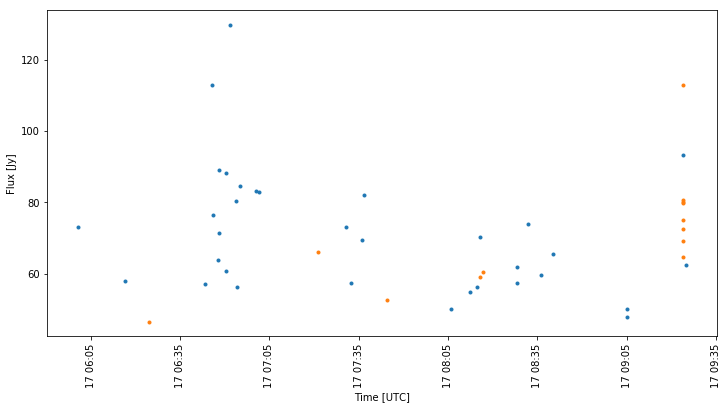

In [6]:
plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(all_GP[(all_GP.db == "ASr_201810170300") & ( all_GP.freq_eff > 60000000.0) ].taustart_ts),
         all_GP[(all_GP.db == "ASr_201810170300") & ( all_GP.freq_eff > 60000000.0) ].f_int,"." )
plt.plot(pd.to_datetime(all_GP[(all_GP.db == "ASr_201810170300") & ( all_GP.freq_eff < 60000000.0) ].taustart_ts),
         all_GP[(all_GP.db == "ASr_201810170300") & ( all_GP.freq_eff < 60000000.0) ].f_int,"." )

x = plt.xticks(rotation=90)

plt.xlabel("Time [UTC]")
plt.ylabel("Flux [Jy]")

<IPython.core.display.Javascript object>


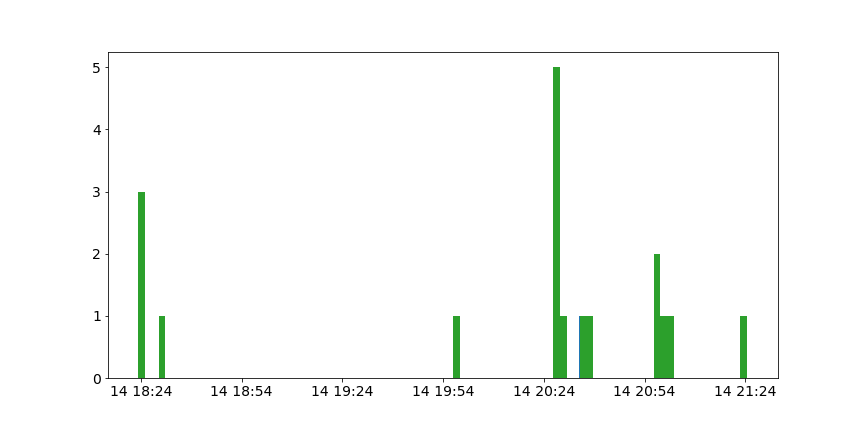

In [315]:
# "ASf_201804141730"  "ASr_201810170300"

IOD = [] 



plt.figure(figsize=(12,6))

for _interval in ["0.5min", "1min", "2min"]:

#     _interval = "5min"

    _db = "ASf_201804141730"

    Smin = 70
    index = ((all_GP.f_int/all_GP.det_sigma*5 < Smin )  & (all_GP.f_int > Smin )& ( all_GP.freq_eff > 60000000.0) ).values 

#     index = (( all_GP.freq_eff > 60000000.0) ).values

#     index = (True)
    times = pd.to_datetime( all_GP[index & (all_GP.db == _db) ].taustart_ts)

    n = plt.hist(times, 
                 bins=len(pd.date_range(start=np.min(pd.to_datetime( all_GP[index & (all_GP.db == _db) ].taustart_ts)),
                                        end=np.max(pd.to_datetime( all_GP[index & (all_GP.db == _db) ].taustart_ts)),
                 freq=_interval))
    )

    # D = std(n)/mean(n)
    # D = 1: poisson, D > 1: clustered, D < 1: anit-clusterd (over regular)

    IOD.append(np.std(n[0])/np.mean(n[0]))

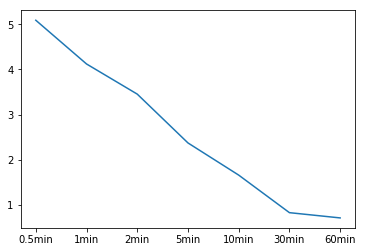

In [120]:
plt.plot(["0.5min", "1min", "2min", "5min", "10min", "30min", "60min"], IOD)

# Time-Frequency 

In [8]:
f_list = glob.glob("/home/kuiack/GP-1SB/20180414210036UTC_S*.0_I1x1_W6_A1.5.fits")

obs_list = ["20180414210036", "20180414205840", "20180414205821", "20180414205718", 
            "20180414205245", "20180414205211", "N", "20180414203719", "20180414203538", 
            "20180414203504", "20180414203404", "N", "20180414202929", "20180414202836", 
            "20180414202829", "20180414202827", "20180414202758", "20180414202755", 
            "20180414202751", "20180414202737", "20180414202727", "20180414202711", 
            "20180414202656", "20180414202635", "N", "20180414200019", "20180414195829", 
            "20180414195820", "20180414195747", "20180414195746", "20180414195728", 
            "20180414195636", "20180414195634", "N", "20180414193309", "N", "20180414190704","N",   
            "20180414183945", "20180414183904", "20180414183205", "20180414183152", 
            "20180414183022", "20180414182348", "20180414182343", "20180414182319"]

subband = np.array([295, 296, 297, 298, 299, 300, 301, 302,"N", 
                    313, 314, 315, 316, 317, 318, 319, 320], dtype=str)

freq = np.array([62.5, 62.3, 62.1, 61.9, 61.7, 61.5, 61.3, 61.1,"N", 
                 59.0, 58.8, 58.6, 58.4, 58.2, 58.0, 57.8, 57.6], dtype=str)


import matplotlib.gridspec as gridspec

test = pd.DataFrame({"obs":[],"SB":[],"val":[]})
# fig =plt.figure(figsize=(70, 184))
fig =plt.figure(figsize=(70, 184))
fig.set_facecolor('white')
count = 1
for OBS in obs_list:


    for SB in subband:
#         print glob.glob("/home/kuiack/GP-1SB/"+OBS+"UTC_S"+SB+".0_I1x1_W6_A1.5.fits")[0]
        if SB == "N" or OBS == "N":
            count +=1
            continue 
            
#         print OBS, SB
        data_1 = fits.getdata(glob.glob("/home/kuiack/GP-1SB/"+OBS+"UTC_S"+SB+".0_I1x1_W6_A1.5.fits")[0],
                              header=False)[0,0,:,:]
        wcs = WCS(glob.glob("/home/kuiack/GP-1SB/"+OBS+"UTC_S"+SB+".0_I1x1_W6_A1.5.fits")[0])
        im_pix_x, im_pix_y, n, nn = wcs.wcs_world2pix(148.5,7.66,1,1,1)

#         plt.subplot(46,17,count)

        plt.subplot(46,17,count)
        plt.imshow(data_1[im_pix_y-6:im_pix_y+6,im_pix_x-6:im_pix_x+6], 
                   vmin =-10, vmax = 30,  origin="lower", cmap="YlGnBu_r")
        
        
        plt.xticks([])
        
        if count%17 == 1:
            plt.ylabel(OBS[8:10]+":"+OBS[10:12]+":"+OBS[12:14], size=128,
                       rotation=0,va="center", ha="right", labelpad=20)

        plt.yticks([])

        count += 1
        test = test.append({"obs":OBS,
                            "SB":SB,
                            "val":np.sum(data_1[im_pix_y-6:im_pix_y+6,im_pix_x-6:im_pix_x+6])}, ignore_index=True)

# plt.suptitle(pd.to_datetime(OBS), size=60, color="black",bbox=dict(facecolor="white"))

bw_count = 0

for SB in subband[::-1]:
    if SB == "N" or OBS == "N":
        bw_count += 1 
        continue 

#     plt.subplot(46, 17, len(obs_list)*len(subband) - bw_count)
    plt.subplot(46, 17, len(obs_list)*len(subband) - bw_count)

    plt.xlabel(freq[bw_count], size=90, labelpad=30)
    bw_count += 1

plt.tight_layout()

plt.savefig("/home/kuiack/B0950+08_figs/plotspectra.pdf")
plt.show()



/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [9]:
obs_list = ["20180414210036", "20180414205840", "20180414205821", "20180414205718", 
            "20180414205245", "20180414205211", "N", "20180414203719", "20180414203538", 
            "20180414203504", "20180414203404", "N", "20180414202929", "20180414202836", 
            "20180414202829", "20180414202827", "20180414202758", "20180414202755", 
            "20180414202751", "20180414202737", "20180414202727", "20180414202711", 
            "20180414202656", "20180414202635", "N", "20180414200019", "20180414195829", 
            "20180414195820", "20180414195747", "20180414195746", "20180414195728", 
            "20180414195636", "20180414195634", "N", "20180414193309", "N", "20180414190704","N",   
            "20180414183945", "20180414183904", "20180414183205", "20180414183152", 
            "20180414183022", "20180414182348", "20180414182343", "20180414182319"]
print (184/len(obs_list))

4


/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:83: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


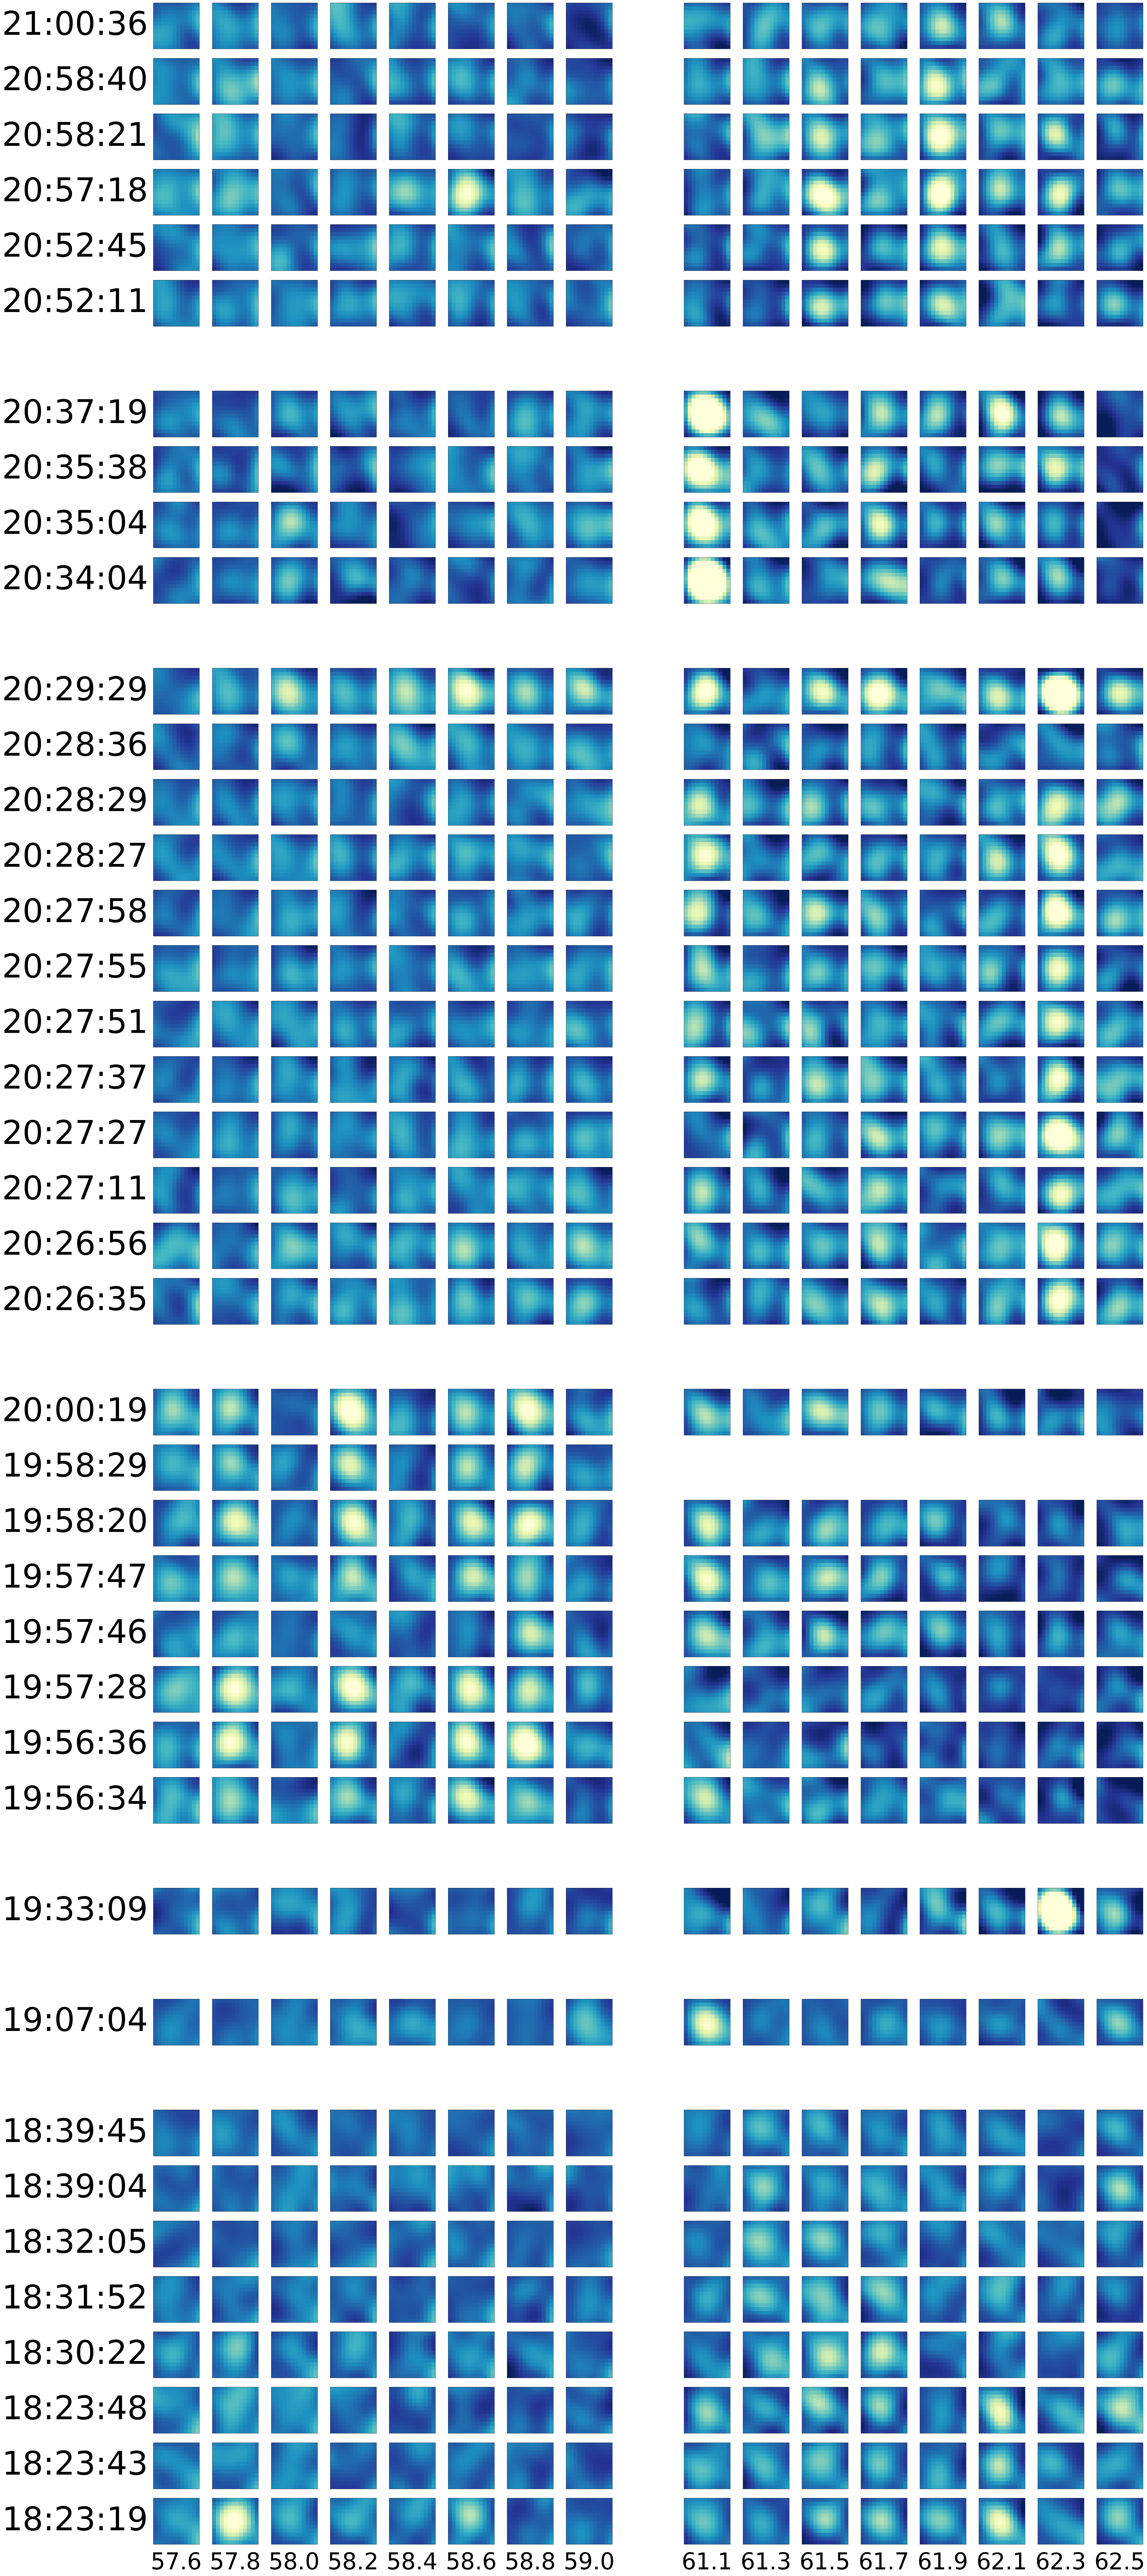

In [41]:
f_list = glob.glob("/home/kuiack/GP-1SB/20180414210036UTC_S*.0_I1x1_W6_A1.5.fits")

obs_list = ["21:00:36", "20:58:40", "20:58:21", "20:57:18", 
            "20:52:45", "20:52:11", "N", "20:37:19", "20:35:38", 
            "20:35:04", "20:34:04", "N", "20:29:29", "20:28:36", 
            "20:28:29", "20:28:27", "20:27:58", "20:27:55", 
            "20:27:51", "20:27:37", "20:27:27", "20:27:11", 
            "20:26:56", "20:26:35", "N", "20:00:19", "19:58:29", 
            "19:58:20", "19:57:47", "19:57:46", "19:57:28", 
            "19:56:36", "19:56:34", "N", "19:33:09", "N", "19:07:04","N",   
            "18:39:45", "18:39:04", "18:32:05", "18:31:52", 
            "18:30:22", "18:23:48", "18:23:43", "18:23:19"]


# obs_list = ["21:35:10","21:35:11","21:35:12","21:35:13","21:35:14","21:35:15","21:35:16",]

subband = np.array([295, 296, 297, 298, 299, 300, 301, 302,"N", 
                    313, 314, 315, 316, 317, 318, 319, 320], dtype=str)

freq = np.array([62.5, 62.3, 62.1, 61.9, 61.7, 61.5, 61.3, 61.1,"N", 
                 59.0, 58.8, 58.6, 58.4, 58.2, 58.0, 57.8, 57.6], dtype=str)




test = pd.DataFrame({"obs":[],"SB":[],"val":[]})
# fig =plt.figure(figsize=(70, 184))
fig = plt.figure(figsize=(70, 4*len(obs_list)))
# fig = plt.figure()
fig.set_facecolor('white')
count = 1
for OBS in obs_list:


    for SB in subband:
#         print glob.glob("/home/kuiack/GP-1SB/"+OBS+"UTC_S"+SB+".0_I1x1_W6_A1.5.fits")[0]
        if SB == "N" or OBS == "N":
            count +=1
            continue 
            


        try:
            data_1 = fits.getdata(glob.glob("/home/kuiack/GP-1SB/20180414_f/2018-04-14T"+OBS+"-S"+SB+".0*.fits")[0],
                                  header=False)[0,0,:,:]
            
            data_1_std = np.nanstd(data_1)
            data_1_mn = np.nanmean(data_1)
            
            wcs = WCS(glob.glob("/home/kuiack/GP-1SB/20180414_f/2018-04-14T"+OBS+"-S"+SB+".0*.fits")[0])
        except IndexError:
            count +=1
            plt.yticks([])
            plt.xticks([])
            continue 
            
        im_pix_x, im_pix_y, n, nn = wcs.wcs_world2pix(148.5,7.66,1,1,1)
        

#         plt.subplot(46,17,count)

        plt.subplot(len(obs_list),17,count)
        plt.imshow(data_1[im_pix_y-6:im_pix_y+6,im_pix_x-6:im_pix_x+6], 
                    vmin =data_1_mn-0.25*data_1_std,  vmax = data_1_mn+0.75*data_1_std, 
                   origin="lower", cmap="YlGnBu_r")
        
        
        plt.xticks([])
        
        if count%17 == 1:
            if ":" not in OBS:
                plt.ylabel(OBS[8:10]+":"+OBS[10:12]+":"+OBS[12:14], size=128,
                           rotation=0,va="center", ha="right", labelpad=20)
            else:
                plt.ylabel(OBS, size=128,
                           rotation=0,va="center", ha="right", labelpad=20)

        plt.yticks([])

        count += 1
        test = test.append({"obs":OBS,
                            "SB":SB,
                            "val":np.sum(data_1[im_pix_y-6:im_pix_y+6,im_pix_x-6:im_pix_x+6])}, ignore_index=True)


bw_count = 0

for SB in subband[::-1]:
    if SB == "N" or OBS == "N":
        bw_count += 1 
        continue 

#     plt.subplot(46, 17, len(obs_list)*len(subband) - bw_count)
    plt.subplot(len(obs_list), 17, len(obs_list)*len(subband) - bw_count)

    plt.xlabel(freq[bw_count], size=90, labelpad=30)
    bw_count += 1

# plt.tight_layout()

plt.show()



/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:65: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:85: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1 1 /home/kuiack/GP-1SB/20180414_f/2018-04-14T21:24:34-S320.0*.fits
2 2 /home/kuiack/GP-1SB/20180414_f/2018-04-14T21:24:34-S319.0*.fits
3 3 /home/kuiack/GP-1SB/20180414_f/2018-04-14T21:24:34-S318.0*.fits
4 4 /home/kuiack/GP-1SB/20180414_f/2018-04-14T21:24:34-S317.0*.fits
5 5 /home/kuiack/GP-1SB/20180414_f/2018-04-14T21:24:34-S316.0*.fits
6 6 /home/kuiack/GP-1SB/20180414_f/2018-04-14T21:24:34-S315.0*.fits
7 7 /home/kuiack/GP-1SB/20180414_f/2018-04-14T21:24:34-S314.0*.fits
8 8 /home/kuiack/GP-1SB/20180414_f/2018-04-14T21:24:34-S313.0*.fits
19 19 /home/kuiack/GP-1SB/20180414_f/2018-04-14T21:24:34-S302.0*.fits
20 20 /home/kuiack/GP-1SB/20180414_f/2018-04-14T21:24:34-S301.0*.fits
21 21 /home/kuiack/GP-1SB/20180414_f/2018-04-14T21:24:34-S300.0*.fits
22 22 /home/kuiack/GP-1SB/20180414_f/2018-04-14T21:24:34-S299.0*.fits
23 23 /home/kuiack/GP-1SB/20180414_f/2018-04-14T21:24:34-S298.0*.fits
24 24 /home/kuiack/GP-1SB/20180414_f/2018-04-14T21:24:34-S297.0*.fits
25 25 /home/kuiack/GP-1SB/20180414_f

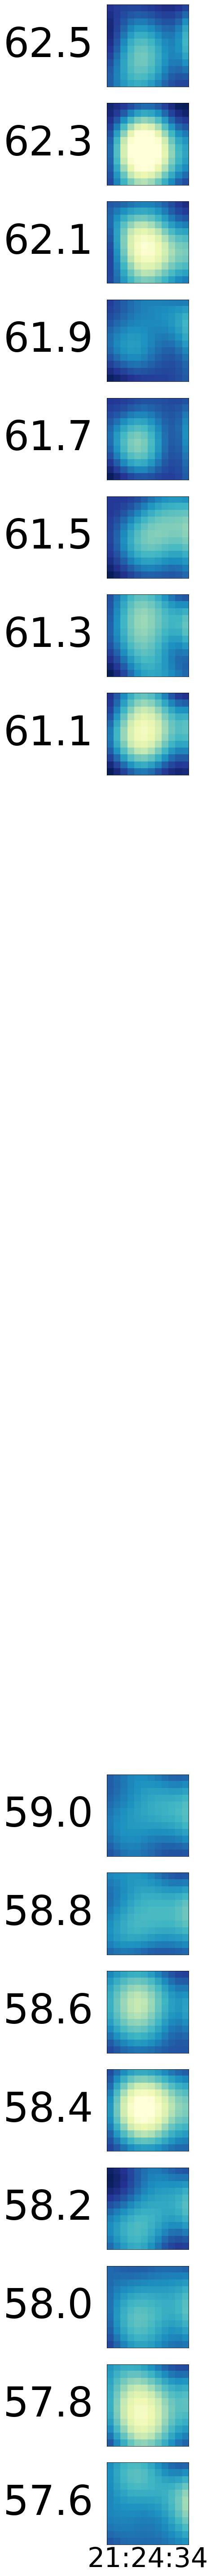

In [54]:
f_list = glob.glob("/home/kuiack/GP-1SB/20180414210036UTC_S*.0_I1x1_W6_A1.5.fits")

# obs_list = ["21:00:36", "20:58:40", "20:58:21", "20:57:18", 
#             "20:52:45", "20:52:11", "N", "20:37:19", "20:35:38", 
#             "20:35:04", "20:34:04", "N", "20:29:29", "20:28:36", 
#             "20:28:29", "20:28:27", "20:27:58", "20:27:55", 
#             "20:27:51", "20:27:37", "20:27:27", "20:27:11", 
#             "20:26:56", "20:26:35", "N", "20:00:19", "19:58:29", 
#             "19:58:20", "19:57:47", "19:57:46", "19:57:28", 
#             "19:56:36", "19:56:34", "N", "19:33:09", "N", "19:07:04","N",   
#             "18:39:45", "18:39:04", "18:32:05", "18:31:52", 
#             "18:30:22", "18:23:48", "18:23:43", "18:23:19"]


obs_list = ["21:24:34"]

subband = np.array([295, 296, 297, 298, 299, 300, 301, 302,"N", "N","N","N","N","N","N","N","N","N",
                    313, 314, 315, 316, 317, 318, 319, 320], dtype=str)[::-1]

freq = np.array([62.5, 62.3, 62.1, 61.9, 61.7, 61.5, 61.3, 61.1,"N", "N","N","N","N","N","N","N","N","N",
                 59.0, 58.8, 58.6, 58.4, 58.2, 58.0, 57.8, 57.6], dtype=str)[::-1]




test = pd.DataFrame({"obs":[],"SB":[],"val":[]})
# fig =plt.figure(figsize=(70, 184))


fig = plt.figure(figsize=(4*len(obs_list),4*len(subband) ))
# fig = plt.figure()
fig.set_facecolor('white')
count = 1
for OBS in obs_list:


    for SB in subband:
#         print glob.glob("/home/kuiack/GP-1SB/"+OBS+"UTC_S"+SB+".0_I1x1_W6_A1.5.fits")[0]
        if SB == "N" or OBS == "N":
            count += 1
            continue 
            
        

        try:
            data_1 = fits.getdata(glob.glob("/home/kuiack/GP-1SB/20180414_f/2018-04-14T"+OBS+"-S"+SB+".0*.fits")[0],
                                  header=False)[0,0,:,:]
            
            data_1_std = np.nanstd(data_1)
            data_1_mn = np.nanmean(data_1)
            
            wcs = WCS(glob.glob("/home/kuiack/GP-1SB/20180414_f/2018-04-14T"+OBS+"-S"+SB+".0*.fits")[0])
        except IndexError:
            count +=1
            plt.yticks([])
            plt.xticks([])
            continue 
            
        im_pix_x, im_pix_y, n, nn = wcs.wcs_world2pix(148.5,7.66,1,1,1)
        

#         plt.subplot(46,17,count)

        plt.subplot(len(subband),len(obs_list),count)
        plt.imshow(data_1[im_pix_y-6:im_pix_y+6,im_pix_x-6:im_pix_x+6], 
                    vmin =data_1_mn-0.25*data_1_std,  vmax = data_1_mn+0.75*data_1_std, 
                   origin="lower", cmap="YlGnBu_r")
        
        
        plt.xticks([])
        print count, count%len(subband), "/home/kuiack/GP-1SB/20180414_f/2018-04-14T"+OBS+"-S"+SB+".0*.fits"
        if count%len(subband) == 0:
            if ":" not in OBS:
                plt.xlabel(OBS[8:10]+":"+OBS[10:12]+":"+OBS[12:14], size=60,
                           rotation=0,va="top", ha="center")
            else:
                plt.xlabel(OBS, size=60,
                           rotation=0,va="top", ha="center")

        plt.yticks([])

        count += 1
        test = test.append({"obs":OBS,
                            "SB":SB,
                            "val":np.sum(data_1[im_pix_y-6:im_pix_y+6,im_pix_x-6:im_pix_x+6])}, ignore_index=True)


bw_count = 0

for SB in subband[::-1]:
    if SB == "N" or OBS == "N":
        bw_count += 1 
        continue 

#     plt.subplot(46, 17, len(obs_list)*len(subband) - bw_count)
    plt.subplot(len(subband),len(obs_list),  len(obs_list)*len(subband) - bw_count)

    plt.ylabel(freq[bw_count], size=90,rotation=0,va="center", ha="right", labelpad=30)
    bw_count += 1

# plt.tight_layout()

plt.show()



In [30]:
all_GP[(all_GP.db =="ASf_201804141730")].sort_values("taustart_ts")

Unnamed: 0  band                db      decl  det_sigma       f_int  \
67          67  23.0  ASf_201804141730  7.820035   5.382140   58.540186   
66          66  24.0  ASf_201804141730  7.691509   8.372458  111.102719   
65          65  23.0  ASf_201804141730  7.796047   5.292226   59.464103   
64          64  24.0  ASf_201804141730  7.716337   8.095227  102.369327   
63          63  24.0  ASf_201804141730  7.636188   7.191254   88.470824   
62          62  24.0  ASf_201804141730  7.973870   5.491179   76.168778   
61          61  24.0  ASf_201804141730  7.838331   6.081141   93.343504   
60          60  24.0  ASf_201804141730  7.901461   5.722225   81.097327   
59          59  23.0  ASf_201804141730  7.741644   5.204657   61.140419   
58          58  24.0  ASf_201804141730  7.754717   5.906105   95.769468   
57          57  24.0  ASf_201804141730  7.642369   5.443046   83.993999   
56          56  24.0  ASf_201804141730  7.656401   5.034843   80.448500   
55          55  24.0  ASf_201804141730  7.627462   5.578107   79.942912   
54          54  24.0  ASf_201804141730  7.587188   5.597681   87.730490   
53          53  24.0  ASf_201804141730  7.682398   5.106274   88.742439   
52          52  23.0  ASf_201804141730  7.692749   5.701083   70.699472   
51          51  23.0  ASf_201804141730  7.768188   7.114850  105.716938   
49          49  24.0  ASf_201804141730  7.681338   5.201141   56.748761   
50          50  23.0  ASf_201804141730  7.663233   8.423992   77.312523   
48          48  24.0  ASf_201804141730  7.655391   5.459096   55.122748   
47          47  24.0  ASf_201804141730  7.698383   5.066931   55.965201   
46          46  24.0  ASf_201804141730  7.670241   5.883222   77.954225   
45          45  23.0  ASf_201804141730  7.688757   7.104947   86.329264   
44          44  23.0  ASf_201804141730  7.750657   5.739816   61.268959   
43          43  23.0  ASf_201804141730  7.696492   6.388275   78.264072   
42          42  23.0  ASf_201804141730  7.648147   5.562054   56.969398   
41          41  23.0  ASf_201804141730  7.519639   5.023497   57.117777   
40          40  23.0  ASf_201804141730  7.636209   5.196578   53.441507   
39          39  23.0  ASf_201804141730  7.538835   5.470185   59.266474   
38          38  23.0  ASf_201804141730  7.562381   5.706342   47.588595   
..         ...   ...               ...       ...        ...         ...   
34          34  24.0  ASf_201804141730  7.719428   5.762955   77.552644   
33          33  24.0  ASf_201804141730  7.627079  11.618937  155.008881   
32          32  24.0  ASf_201804141730  7.643297   5.374246   65.770902   
31          31  23.0  ASf_201804141730  7.652798   5.125339   56.534720   
30          30  24.0  ASf_201804141730  7.559833   5.301479   71.115236   
29          29  24.0  ASf_201804141730  7.545686   5.030528   64.003105   
28          28  24.0  ASf_201804141730  7.568159   5.048849   58.678409   
27          27  24.0  ASf_201804141730  7.565648   6.196094   67.401336   
26          26  24.0  ASf_201804141730  7.582160   9.650153  119.785686   
25          25  24.0  ASf_201804141730  7.621721   5.342405   72.426383   
24          24  24.0  ASf_201804141730  7.518973   5.085078   58.895686   
23          23  24.0  ASf_201804141730  7.601733   5.543981   60.161925   
22          22  24.0  ASf_201804141730  7.609527   9.775490  111.319177   
21          21  23.0  ASf_201804141730  7.728506   6.627357   64.405124   
20          20  23.0  ASf_201804141730  7.615186   5.075069   51.505556   
19          19  24.0  ASf_201804141730  7.654368   5.792122   70.631627   
18          18  24.0  ASf_201804141730  7.679467   5.495883   62.296566   
17          17  24.0  ASf_201804141730  7.695055   7.190003   85.846275   
16          16  24.0  ASf_201804141730  7.655398   5.188675   54.422245   
15          15  24.0  ASf_201804141730  7.650324   5.701415   53.289617   
14          14  24.0  ASf_201804141730  7.645871   6.883893   84.751042   
13          13  24.0  ASf_201

In [7]:
all_GP[(all_GP.db == "ASf_20181104")]


Unnamed: 0  band            db      decl  det_sigma       f_int  \
87          87  24.0  ASf_20181104  7.822511   5.119617   61.197219   
88          88  23.0  ASf_20181104  7.649290   5.074438   53.444068   
89          89  24.0  ASf_20181104  7.608980  12.808020  154.806046   
90          90  23.0  ASf_20181104  7.683560   5.141787   51.964519   
91          91  24.0  ASf_20181104  7.638617   5.038202   51.827142   
92          92  24.0  ASf_20181104  7.692880   5.023136   44.879165   
93          93  24.0  ASf_20181104  7.559899   5.433657   52.988912   

    f_int_err      f_peak  f_peak_err    freq_eff     id          ra  \
87  20.818631   58.836462   11.555970  58300780.0  505.0  148.620354   
88  19.140209   51.159140   10.578151  61816408.0  505.0  148.589623   
89  21.567711  153.804435   12.371557  58320312.0  505.0  148.447250   
90  18.182134   49.843906   10.069070  61816408.0  505.0  148.643703   
91  17.975612   49.748935    9.962070  58300780.0  505.0  148.585403   
92  15.861229   43.010603    8.776209  58300780.0  505.0  148.560622   
93  17.148491   51.139023    9.555044  58314736.0  505.0  148.609922   

                taustart_ts  
87  2018-11-04 08:20:47.000  
88  2018-11-04 08:19:36.000  
89  2018-11-04 08:12:53.000  
90  2018-11-04 07:56:03.000  
91  2018-11-04 07:24:28.000  
92  2018-11-04 07:20:54.000  
93  2018-11-04 07:07:21.000

In [16]:
from scipy import stats
# ["ASf_201804141730", "ASr_20181101", "ASr_201810170300"]
D,p = stats.ks_2samp(all_GP[(all_GP.freq_eff < 60000000) &\
                        (all_GP.db == "ASf_201804141730") ].f_int,
                all_GP[(all_GP.freq_eff < 60000000) &\
                        (all_GP.db == "ASf_201804141730") ].f_int)

print D, p

n = len(all_GP[(all_GP.freq_eff < 60000000) &\
                        (all_GP.db == "ASf_201804141730") ].f_int)

m = len(all_GP[(all_GP.freq_eff < 60000000) &\
                        (all_GP.db == "ASf_201804141730") ].f_int)


print D > 1.517*np.sqrt(float(n+m)/(n*m))


if D > 1.517*np.sqrt(float(n+m)/(n*m)):
    print "distributions not the same at confidence 0.01"

# stats.ks_2samp(all_GP[(all_GP.db == "ASr_201810170300") ].f_int,
#                 all_GP[(all_GP.db == "ASr_20181101") ].f_int)

0.0 1.0
False


In [155]:
def c_function(alpha):
    return np.sqrt(-(1./2.)*np.log(alpha))

D,p = stats.ks_2samp(all_GP[(all_GP.db == "ASf_201804141730") ].f_int,
                all_GP[(all_GP.db == "ASr_201810170300") ].f_int)

print D, p

# n = len(all_GP[(all_GP.freq_eff > 60000000) & (all_GP.db == "ASf_201804141730")].f_int)
# m = len(all_GP[(all_GP.freq_eff > 60000000) & (all_GP.db == "ASr_201810170300")].f_int)

n = len(all_GP[(all_GP.db == "ASf_201804141730")].f_int)
m = len(all_GP[(all_GP.db == "ASr_201810170300")].f_int)


print n,m 
print D > 1.517*np.sqrt(float(n+m)/(n*m))

if D > 1.517*np.sqrt(float(n+m)/(n*m)):
    print "distributions not the same at confidence 0.01"
    
if D > 1.073*np.sqrt(float(n+m)/(n*m)):
    print "distributions not the same at confidence 0.1"
    
if D > 1.858*np.sqrt(float(n+m)/(n*m)):
    print "distributions not the same at confidence 0.001"

0.139406487233 0.64651437928
63 46
False


In [12]:
stats.ks_2samp(np.random.normal(size=20),
               np.random.normal(size=20))

NameError: name 'stats' is not defined

/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  """Entry point for launching an IPython kernel.
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  


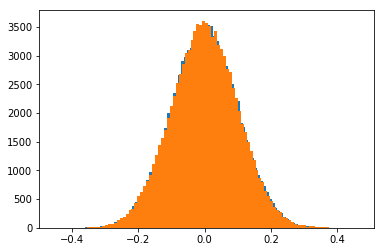

In [175]:
_Z = plt.hist(np.random.normal(scale = 0.1,size=1e5), bins=100)
_Z = plt.hist(np.random.normal(scale = 0.1,size=1e5), bins=100)

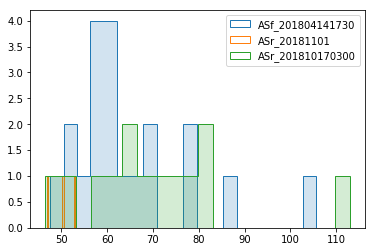

In [34]:
plt.hist(all_GP[(all_GP.freq_eff < 60000000) & (all_GP.db == "ASf_201804141730") ].f_int, color="C0", bins=20, histtype="step", label="ASf_201804141730")
plt.hist(all_GP[(all_GP.freq_eff < 60000000) & (all_GP.db == "ASf_201804141730") ].f_int, bins=20, color="C0", alpha=0.2)

plt.hist(all_GP[(all_GP.freq_eff < 60000000) & (all_GP.db == "ASr_20181101") ].f_int, bins=20, color="C1", histtype="step", label="ASr_20181101")
plt.hist(all_GP[(all_GP.freq_eff < 60000000) & (all_GP.db == "ASr_20181101") ].f_int, bins=20, color="C1", alpha=0.2)

plt.hist(all_GP[(all_GP.freq_eff < 60000000) & (all_GP.db == "ASr_201810170300") ].f_int, bins=20, color="C2", histtype="step",label="ASr_201810170300")
plt.hist(all_GP[(all_GP.freq_eff < 60000000) & (all_GP.db == "ASr_201810170300") ].f_int, bins=20, color="C2", alpha=0.2)
plt.legend()

### Time-Frequency spectra

In [5]:
files = glob.glob("/home/kuiack/GP-1SB/20180414_f/*csv")

files = np.append(files, glob.glob("/home/kuiack/GP-1SB/20181104/*csv"))

In [15]:
frames = []
pyse_index = 0




for i in files:
    df_frame = pd.read_csv(i,skipinitialspace=True)
    file_time = pd.to_datetime(os.path.basename(i)[:19])
    file_band = os.path.basename(i)[21:24]
    
    frames.append(pd.DataFrame({"band":file_band, 
                                "flux":df_frame.iloc[pyse_index].int_flux, 
                                "flux_err":df_frame.iloc[pyse_index].int_flux_err},index=[file_time]))

    
GPresult = pd.concat(frames)

frames = []
pyse_index_list = [2,3,5,1]

for i in files:
    df_frame = pd.read_csv(i, skipinitialspace=True)
    file_time = pd.to_datetime(os.path.basename(i)[:19])
    file_band = os.path.basename(i)[21:24]
    
    for pyse_index in pyse_index_list:
        frames.append(pd.DataFrame({"band":file_band, 
                                    "flux":df_frame.iloc[pyse_index].int_flux, 
                                    "flux_err":df_frame.iloc[pyse_index].int_flux_err}, index=[file_time]))
    
    
BGresult = pd.concat(frames)

In [23]:
[os.path.basename(x) for x in files][0][21:24]

'317'

In [25]:
GPresult

band         flux     flux_err
2018-11-04 08:12:52  317    21.055526    29.779509
2018-11-04 08:12:50  299    15.147718    42.507553
2018-11-04 08:12:49  316    18.068809    44.902927
2018-11-04 08:12:56  314   -26.478000    34.480542
2018-11-04 08:12:53  314   113.076273    37.665031
2018-11-04 08:12:49  299    58.015733    41.317203
2018-11-04 08:12:51  316    -4.429869    40.881448
2018-11-04 08:12:48  315    -9.648665    45.240189
2018-11-04 08:12:54  318    35.450964    34.380627
2018-11-04 08:12:48  316     2.195197    32.378564
2018-11-04 08:12:49  319     6.869002    34.879199
2018-11-04 08:12:48  318    20.733285    34.821556
2018-11-04 08:12:54  316    -3.201563    41.964554
2018-11-04 08:12:56  317    18.928707    35.641703
2018-11-04 08:12:50  296    41.255600    36.117055
2018-11-04 08:12:49  300  1105.441346  3207.810841
2018-11-04 08:12:53  299   217.393778    41.200498
2018-11-04 08:12:54  300    29.070370    41.816543
2018-11-04 08:12:56  302     6.370945    42.485919
2018-11-04 08:12:48  298    35.306864    41.134961
2018-11-04 08:12:56  297    15.278633    35.294309
2018-11-04 08:12:55  317    29.724777    32.934635
2018-11-04 08:12:53  302    44.838374    39.001187
2018-11-04 08:12:48  313    38.854015    35.280241
2018-11-04 08:12:56  298    19.329181    37.026792
2018-11-04 08:12:50  318    39.818504    32.855501
2018-11-04 08:12:49  301     5.831632    37.595046
2018-11-04 08:12:54  301    11.172943    37.234761
2018-11-04 08:12:51  300    34.208660    77.253271
2018-11-04 08:12:54  297    11.930827   307.922385
...                  ...          ...          ...
2018-11-04 08:12:55  299    27.437334    36.304627
2018-11-04 08:12:49  320    39.325010    38.749056
2018-11-04 08:12:53  319    60.483663    38.833733
2018-11-04 08:12:48  296    22.580268    28.540966
2018-11-04 08:12:55  316   -21.115693    35.097844
2018-11-04 08:12:52  296    31.403272    33.532379
2018-11-04 08:12:51  299    33.554230    33.405564
2018-11-04 08:12:56  300    14.944415   147.777188
2018-11-04 08:12:55  313     9.367503    37.192137
2018-11-04 08:12:50  315   -22.284021    38.916012
2018-11-04 08:12:53  298   253.604627    44.637036
2018-11-04 08:12:49  313   -33.652731    40.638070
2018-11-04 08:12:49  302    20.566195    46.015976
2018-11-04 08:12:51  297   -43.244366   606.721600
2018-11-04 08:12:50  317     2.425685    37.210060
2018-11-04 08:12:49  296    18.895176    32.196860
2018-11-04 08:12:50  297   -11.085871    44.815869
2018-11-04 08:12:54  298    57.764371    37.140709
2018-11-04 08:12:50  302    10.366575    32.459363
2018-11-04 08:12:49  318     2.348224    26.938326
2018-11-04 08:12:52  297    -5.783497    69.526557
2018-11-04 08:12:51  298    44.847857    36.233814
2018-11-04 08:12:48  295    30.622458    31.905311
2018-11-04 08:12:54  320    31.745350    39.610219
2018-11-04 08:12:51  315    20.325843    40.465591
2018-11-04 08:12:55  320    44.291966    36.001964
2018-11-04 08:12:54  315    -5.274401    33.426789
2018-11-04 08:12:52  313   -18.684455    45.783361
2018-11-04 08:12:55  298    50.944187    35.141575
2018-11-04 08:12:53  313    -6.983089    45.676989

[144 rows x 3 columns]

In [7]:
obs_list = ["20180414210036", "20180414205840", "20180414205821", "20180414205718", 
            "20180414205245", "20180414205211", "N", "20180414203719", "20180414203538", 
            "20180414203504", "20180414203404", "N", "20180414202929", "20180414202836", 
            "20180414202829", "20180414202827", "20180414202758", "20180414202755", 
            "20180414202751", "20180414202737", "20180414202727", "20180414202711", 
            "20180414202656", "20180414202635", "N", "20180414200019", "20180414195829", 
            "20180414195820", "20180414195747", "20180414195746", "20180414195728", 
            "20180414195636", "20180414195634", "N", "20180414193309", "N", "20180414190704","N",   
            "20180414183945", "20180414183904", "20180414183205", "20180414183152", 
            "20180414183022", "20180414182348", "20180414182343", "20180414182319"]

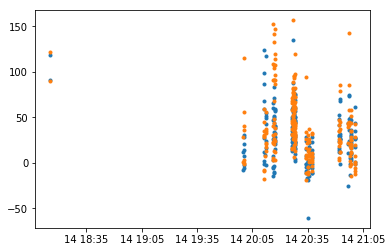

In [35]:
plt.plot(result[result.band == "S299"].index, 
         result[result.band == "S299"].flux, ".")
plt.plot(result[result.band == "S300"].index, 
         result[result.band == "S300"].flux, ".")

In [19]:
obs_list = ["20180414210036", "20180414205840", "20180414205821", "20180414205718", 
            "20180414205245", "20180414205211", "20180414203719", "20180414203538", 
            "20180414203504", "20180414203404", "20180414202929", "20180414202836", 
            "20180414202829", "20180414202827", "20180414202758", "20180414202755", 
            "20180414202751", "20180414202737", "20180414202727", "20180414202711", 
            "20180414202656", "20180414202635", "20180414200019", "20180414195829", 
            "20180414195820", "20180414195747", "20180414195746", "20180414195728", 
            "20180414195636", "20180414195634", "20180414193309", "20180414190704",
            "20180414183945", "20180414183904", "20180414183205", "20180414183152", 
            "20180414183022", "20180414182348", "20180414182343", "20180414182319"]

det_time = pd.to_datetime(obs_list)

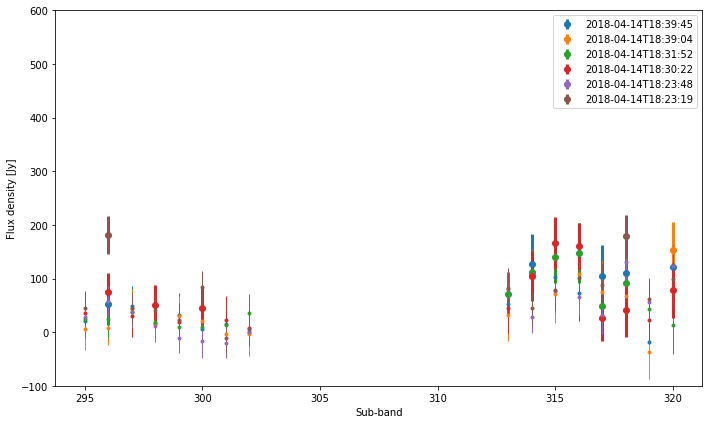

In [123]:
%matplotlib inline


# gp_times = ["2018-04-14T20:00:19", 
#             "2018-04-14T19:58:29", 
#             "2018-04-14T19:58:20", 
#             "2018-04-14T19:57:47", 
#             "2018-04-14T19:57:46"]

# gp_times = ["2018-04-14T20:37:19", 
#             "2018-04-14T20:35:38", 
#             "2018-04-14T20:35:04", 
#             "2018-04-14T20:34:04"]

# gp_times = [#"2018-04-14T21:00:36", 
#             "2018-04-14T20:58:40", 
#             "2018-04-14T20:58:21", 
#             "2018-04-14T20:57:18", 
#             "2018-04-14T20:52:45", 
#             "2018-04-14T20:52:11"]


gp_times = ["2018-04-14T18:39:45", 
            "2018-04-14T18:39:04", 
            "2018-04-14T18:31:52",
            "2018-04-14T18:30:22",
            "2018-04-14T18:23:48", 
            "2018-04-14T18:23:19"]

# gp_times = ["2018-11-04T08:12:50",
# #             "2018-11-04T08:12:51",
#             "2018-11-04T08:12:52",
#             "2018-11-04T08:12:53"]#,
# # #             "2018-11-04T08:12:54"] 




# gp_times = ["2018-04-14T19:33:09","2018-04-14T19:33:10","2018-04-14T19:33:11","2018-04-14T19:33:12"]
           
# gp_times = pd.date_range(start = pd.to_datetime("2018-11-04T08:12:48"),
#                   end = pd.to_datetime("2018-11-04T08:12:56") \
#                   ,freq='S')

i = 0
plt.figure(figsize=(10,6))

for gp_time in gp_times:

    BG_max = BGresult[BGresult.index == pd.to_datetime(gp_time)\
            ].groupby(BGresult[BGresult.index == pd.to_datetime(gp_time)\
                              ].band).max().flux

    BG_max_err = BGresult[BGresult.index == pd.to_datetime(gp_time)\
            ].groupby(BGresult[BGresult.index == pd.to_datetime(gp_time)\
                              ].band).median().flux_err


    BG_max_band = BGresult[BGresult.index == pd.to_datetime(gp_time)\
            ].groupby(BGresult[BGresult.index == pd.to_datetime(gp_time)\
                              ].band).max().flux_err.index


    index = GPresult[(GPresult.index == pd.to_datetime(gp_time))\
                    ].sort_values("band").flux.values  >= (BG_max + BG_max_err)


    plt.errorbar(np.array(GPresult[GPresult.index == pd.to_datetime(gp_time)].sort_values("band").band.values[index.values],dtype=int),
                GPresult[GPresult.index == pd.to_datetime(gp_time)].sort_values("band").flux.values[index.values], 
                yerr=GPresult[GPresult.index == pd.to_datetime(gp_time)].sort_values("band").flux_err.values[index.values], 
                fmt="o", lw=3, color="C{}".format(i), label=gp_time)


    plt.errorbar(np.array(GPresult[GPresult.index == pd.to_datetime(gp_time)].sort_values("band").band.values[~index.values],dtype=int),
                GPresult[GPresult.index == pd.to_datetime(gp_time)].sort_values("band").flux.values[~index.values], 
                yerr=GPresult[GPresult.index == pd.to_datetime(gp_time)].sort_values("band").flux_err.values[~index.values], 
                fmt=".", lw=1, color="C{}".format(i), label=None)
    
    
    i += 1

    
    
#     print gp_time, result[result.index == pd.to_datetime(gp_time)].flux

#     if gp_time in det_time:
#         color="r"
#         fmt = "."
#     else:
#         color="k"
#         fmt = "o"

#     plt.errorbar(np.array(GPresult[GPresult.index == pd.to_datetime(gp_time)].band,dtype=int),
#                 GPresult[GPresult.index == pd.to_datetime(gp_time)].flux, 
#                 yerr=GPresult[GPresult.index == pd.to_datetime(gp_time)].flux_err, 
#                 fmt=fmt,  label=gp_time)

#     plt.errorbar(np.array(BGresult[BGresult.index == pd.to_datetime(gp_time)].band,dtype=int),
#                 BGresult[BGresult.index == pd.to_datetime(gp_time)].flux, 
#                 yerr=BGresult[BGresult.index == pd.to_datetime(gp_time)].flux_err, 
#                 fmt=fmt, label=gp_time)

    
    
    
#     plt.errorbar(np.array(BGresult[BGresult.index == pd.to_datetime(gp_time)].band,dtype=int),
#                 BGresult[BGresult.index == pd.to_datetime(gp_time)].flux, 
#                 yerr=BGresult[BGresult.index == pd.to_datetime(gp_time)].flux_err, 
#                 fmt="o", color = "k", ecolor="k", label=None)

#     plt.errorbar(np.array(GPresult[GPresult.index == pd.to_datetime(gp_time)].band,dtype=int),
#                 GPresult[GPresult.index == pd.to_datetime(gp_time)].flux, 
#                 yerr=GPresult[GPresult.index == pd.to_datetime(gp_time)].flux_err, 
#                 fmt=".", color = "r", ecolor="r",  label=None)


# plt.errorbar([np.nan],[np.nan],yerr=[np.nan], 
#             fmt="o", color="k", ecolor="k", label="Background")

# plt.errorbar([np.nan],[np.nan],yerr=[np.nan], 
#             fmt=".", color="r", ecolor="r", label="Pulses")

plt.ylim([-100,600])
plt.ylabel("Flux density [Jy]")
plt.xlabel("Sub-band")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


# gp_times = ["2018-04-14T21:00:37", 
#             "2018-04-14T20:58:41", 
#             "2018-04-14T20:58:22", 
#             "2018-04-14T20:57:19", 
#             "2018-04-14T20:52:46", 
#             "2018-04-14T20:52:12"]

# plt.figure(figsize=(10,6))

# for gp_time in gp_times:
# #     print gp_time, result[result.index == pd.to_datetime(gp_time)].flux
#     plt.errorbar(np.array([x[1:] for x in result[result.index == pd.to_datetime(gp_time)].band], dtype=int),
#                 result[result.index == pd.to_datetime(gp_time)].flux, 
#                 yerr=result[result.index == pd.to_datetime(gp_time)].flux_err, 
#                 fmt="o", label=gp_time)
    
    
# plt.ylim([-100,300])
# plt.ylabel("Flux density [Jy]")
# plt.xlabel("Sub-band")
# plt.legend()
# plt.show()

<ErrorbarContainer object of 3 artists>

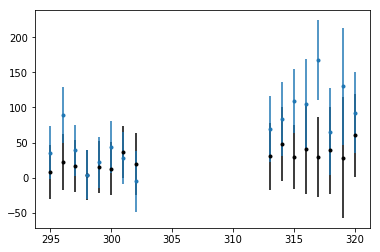

In [71]:
# for gp_time in gp_times:
# #     print gp_time, result[result.index == pd.to_datetime(gp_time)].flux

#     if gp_time in det_time:
#         color="r"
#         fmt = "."
#     else:
#         color="k"
#         fmt = "o"

gp_time = gp_times[0]
        
# plt.errorbar(np.array(GPresult[GPresult.index == pd.to_datetime(gp_time)].band,dtype=int),
#             GPresult[GPresult.index == pd.to_datetime(gp_time)].flux, 
#             yerr=GPresult[GPresult.index == pd.to_datetime(gp_time)].flux_err, 
#             fmt=fmt,  label=gp_time)


plt.errorbar(BG_max_band,dtype=int),
            BG_max, 
            yerr=BG_max_err, 
            fmt="o", color = "k", ecolor="k", label=None)

plt.errorbar(np.array(GPresult[GPresult.index == pd.to_datetime(gp_time)].band,dtype=int),
            GPresult[GPresult.index == pd.to_datetime(gp_time)].flux, 
            yerr=GPresult[GPresult.index == pd.to_datetime(gp_time)].flux_err, 
            fmt=fmt,  label=gp_time)


In [69]:
BG_max = BGresult[BGresult.index == pd.to_datetime(gp_time)\
        ].groupby(BGresult[BGresult.index == pd.to_datetime(gp_time)\
                          ].band).max().flux

BG_max_err = BGresult[BGresult.index == pd.to_datetime(gp_time)\
        ].groupby(BGresult[BGresult.index == pd.to_datetime(gp_time)\
                          ].band).mean().flux_err


BG_max_band = BGresult[BGresult.index == pd.to_datetime(gp_time)\
        ].groupby(BGresult[BGresult.index == pd.to_datetime(gp_time)\
                          ].band).max().flux_err.index



In [74]:

index = GPresult[(GPresult.index == pd.to_datetime(gp_time))   ].sort_values("band").flux.values  >= (BG_max + BG_max_err)


<ErrorbarContainer object of 3 artists>

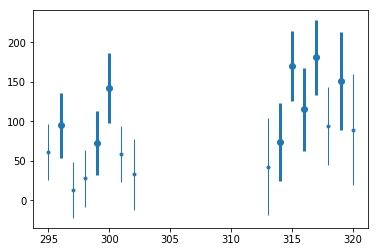

In [102]:
# plt.errorbar(np.array(BG_max_band,dtype=int),
#             BG_max, 
#             yerr=BG_max_err, 
#             fmt=".", color = "k", ecolor="k", label=None)

# plt.errorbar(np.array(GPresult[GPresult.index == pd.to_datetime(gp_time)].band,dtype=int),
#             GPresult[GPresult.index == pd.to_datetime(gp_time)].flux, 
#             yerr=GPresult[GPresult.index == pd.to_datetime(gp_time)].flux_err, 
#             fmt=fmt,  label=gp_time)

# plt.errorbar(np.array(BG_max_band,dtype=int),
#             BG_max, 
#             yerr=BG_max_err, 
#             fmt=".", color = "k", ecolor="k", label=None)



gp_time = gp_times[2]

BG_max = BGresult[BGresult.index == pd.to_datetime(gp_time)\
        ].groupby(BGresult[BGresult.index == pd.to_datetime(gp_time)\
                          ].band).max().flux

BG_max_err = BGresult[BGresult.index == pd.to_datetime(gp_time)\
        ].groupby(BGresult[BGresult.index == pd.to_datetime(gp_time)\
                          ].band).mean().flux_err


BG_max_band = BGresult[BGresult.index == pd.to_datetime(gp_time)\
        ].groupby(BGresult[BGresult.index == pd.to_datetime(gp_time)\
                          ].band).max().flux_err.index


index = GPresult[(GPresult.index == pd.to_datetime(gp_time))\
                ].sort_values("band").flux.values  >= (BG_max + BG_max_err)


plt.errorbar(np.array(GPresult[GPresult.index == pd.to_datetime(gp_time)].sort_values("band").band.values[index.values],dtype=int),
            GPresult[GPresult.index == pd.to_datetime(gp_time)].sort_values("band").flux.values[index.values], 
            yerr=GPresult[GPresult.index == pd.to_datetime(gp_time)].sort_values("band").flux_err.values[index.values], 
            fmt="o", lw=3, color="C0", label=gp_time)


plt.errorbar(np.array(GPresult[GPresult.index == pd.to_datetime(gp_time)].sort_values("band").band.values[~index.values],dtype=int),
            GPresult[GPresult.index == pd.to_datetime(gp_time)].sort_values("band").flux.values[~index.values], 
            yerr=GPresult[GPresult.index == pd.to_datetime(gp_time)].sort_values("band").flux_err.values[~index.values], 
            fmt=".", lw=1,color="C0", label=gp_time)



In [92]:
GPresult[GPresult.index == pd.to_datetime(gp_time)].sort_values("band").flux.values[~index.values]

array([ 35.808081,  39.196392,   4.352781,  22.040933,  43.448317,
        27.625476,  -5.032799,  69.25795 ,  83.825907,  65.451807,
        92.787371])

## KS TEST

Ks_2sampResult(statistic=0.13940648723257421, pvalue=0.64651437927953725)


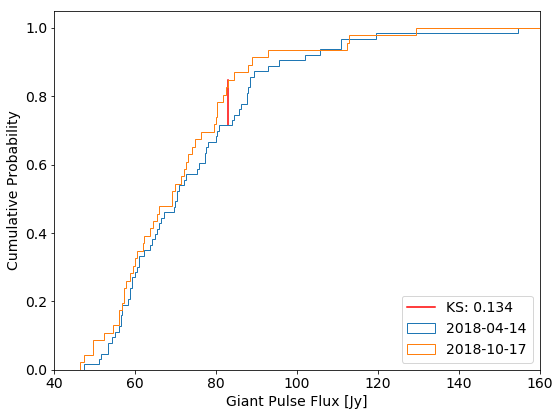

In [13]:
# plt.figure()
# plt.hist(all_GP[(all_GP.freq_eff > 60000000) & (all_GP.db == "ASf_201804141730")].f_int, 
#          color="C0",  histtype="step", cumulative=True, normed=True)
# # plt.hist(all_GP[(all_GP.freq_eff > 60000000) & (all_GP.db == "ASr_20181101")].f_int,  color="C1", histtype="step", cumulative=True, normed=True)
# plt.hist(all_GP[(all_GP.freq_eff > 60000000) & (all_GP.db == "ASr_201810170300")].f_int,  
#          color="C2", histtype="step", cumulative=True, normed=True)
# plt.ylabel("Cumulative Probability")
# plt.xlabel("Giant Pulse Flux [Jy]")

# plt.figure()
# plt.hist(all_GP[(all_GP.freq_eff < 60000000) & (all_GP.db == "ASf_201804141730")].f_int, 
#          color="C0",  histtype="step", cumulative=True, normed=True)
# # plt.hist(all_GP[(all_GP.freq_eff > 60000000) & (all_GP.db == "ASr_20181101")].f_int,  color="C1", histtype="step", cumulative=True, normed=True)
# plt.hist(all_GP[(all_GP.freq_eff < 60000000) & (all_GP.db == "ASr_201810170300")].f_int,  
#          color="C2", histtype="step", cumulative=True, normed=True)
# plt.ylabel("Cumulative Probability")
# plt.xlabel("Giant Pulse Flux [Jy]")

# plt.figure(figsize=(8,6))

# n1 = plt.hist(all_GP[(all_GP.db == "ASf_201804141730")].f_int, color="C0",  
#          histtype="step", bins=len(all_GP[(all_GP.db == "ASf_201804141730")].f_int), cumulative=True, normed=True, label="2018-04-14")
# # plt.hist(all_GP[(all_GP.freq_eff > 60000000) & (all_GP.db == "ASr_20181101")].f_int,  color="C1", histtype="step", cumulative=True, normed=True)
# n2 = plt.hist(all_GP[(all_GP.db == "ASr_201810170300")].f_int,  color="C1", 
#          histtype="step", bins=len(all_GP[(all_GP.db == "ASr_201810170300")].f_int),cumulative=True, normed=True, label="2018-10-17")
# plt.ylabel("Cumulative Probability")
# plt.xlabel("Giant Pulse Flux [Jy]")
# plt.legend(loc="lower right")




plt.figure(figsize=(8,6))

n1 = plt.hist(all_GP[(all_GP.db == "ASf_201804141730")].f_int, color="C0",  
         histtype="step", bins=np.linspace(0,180,400), cumulative=True, normed=True, label="2018-04-14", zorder=1)
# plt.hist(all_GP[(all_GP.freq_eff > 60000000) & (all_GP.db == "ASr_20181101")].f_int,  color="C1", histtype="step", cumulative=True, normed=True)
n2 = plt.hist(all_GP[(all_GP.db == "ASr_201810170300")].f_int,  color="C1", 
         histtype="step", bins=np.linspace(0,180,400),cumulative=True, normed=True, label="2018-10-17", zorder=2)

plt.plot([83,83],[n2[0][184],n1[0][184]], "r", label="KS: {}".format(round(n2[0][184]-n1[0][184],3)), zorder=0)

plt.ylabel("Cumulative Probability")
plt.xlabel("Giant Pulse Flux [Jy]")
plt.legend(loc="lower right")
plt.xlim([40,160])

print stats.ks_2samp(all_GP[(all_GP.db == "ASr_201810170300")].f_int,all_GP[(all_GP.db == "ASf_201804141730")].f_int)

plt.tight_layout()

plt.savefig("/home/kuiack/B0950+08_figs/KS-test_allfreq.pdf")


In [37]:

x1 = (np.sort(all_GP.f_int) *1000.)/55.35
y1 = np.array((np.array(range(len(all_GP))[::-1])))


x2 = (np.sort(all_GP.loc[TF_index.values[:-0.1*len(all_GP)]].f_int) *1000.)/55.35
y2 = np.array((np.array(range(len(all_GP.loc[TF_index.values[:-0.1*len(all_GP)]]))[::-1])))


/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


[ 280.86214645   -4.17156932]
[ 225.32968113   -4.69075533]


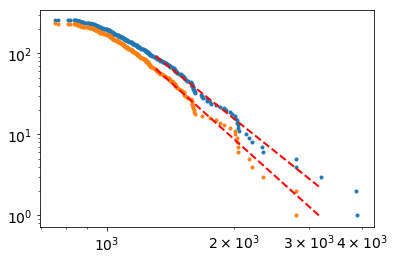

In [39]:
plt.figure()
plt.plot(x1,y1, ".")

fit, cov = curve_fit(powlaw, x1[(x1 > flux_limit)]/1000., y1[(x1 > flux_limit)])
print fit

plt.plot(x[(x > flux_limit)],
         powlaw(x[(x > flux_limit)]/1000.,fit[0],fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy ms) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit))

plt.plot(x2,y2, ".")

fit, cov = curve_fit(powlaw, x2[(x2 > flux_limit)]/1000., y2[(x2 > flux_limit)])
print fit
plt.plot(x[(x > flux_limit)],
         powlaw(x[(x > flux_limit)]/1000.,fit[0],fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy ms) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit))

plt.xscale("log")
plt.yscale("log")
plt.show()

Text(0.5,0,'f_int')

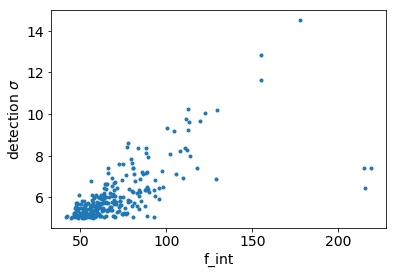

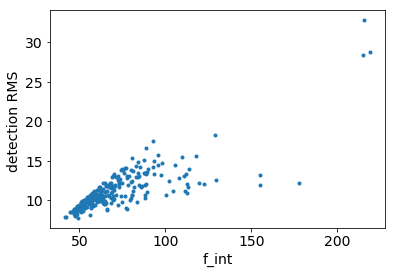

In [336]:
plt.figure()
plt.plot(all_GP.f_int, all_GP.det_sigma, ".")
plt.ylabel(r"detection $\sigma$")
plt.xlabel("f_int")

plt.figure()
plt.plot(all_GP.f_int, all_GP.f_peak/all_GP.det_sigma, ".")
plt.ylabel("detection RMS ")
plt.xlabel("f_int")

In [119]:
%matplotlib inline

print len(pd.to_datetime(all_GP.taustart_ts).dt.round("1s")) 
print len(np.unique(pd.to_datetime(all_GP.taustart_ts).dt.round("1s")))


261
249


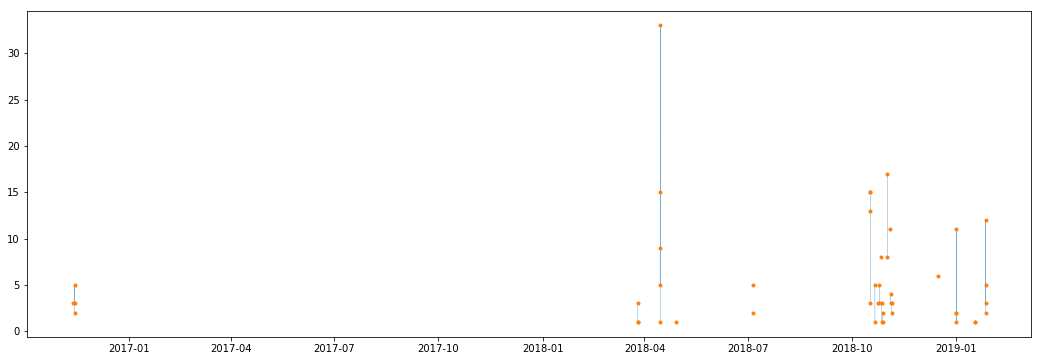

In [130]:
plt.figure(figsize=(18,6))
hour_hist[0][(hour_hist[0] == 0)] = np.nan

plt.plot(pd.date_range(start='2016-11-12 07:00:00', end="2019-01-27 03:00:00", freq="h"),hour_hist[0], lw=0.3)
plt.plot(pd.date_range(start='2016-11-12 07:00:00', end="2019-01-27 03:00:00", freq="h"),hour_hist[0], ".")
# plt.xlim([12200,12700])
plt.show()

In [45]:
print min(pd.to_datetime(all_GP.taustart_ts).dt.round("1h"))
print max(pd.to_datetime(all_GP.taustart_ts).dt.round("1h"))

2016-11-12 07:00:00
2019-01-27 03:00:00


In [47]:
len(pd.date_range(start='2016-11-12 07:00:00', end="2019-01-27 03:00:00", freq="h"))


19341

In [22]:
testdates = [i for i in pd.to_datetime(np.unique(times.taustart_ts.dt.round("1s")))]

In [19]:
times.taustart_ts.dt.round("1s")

In [33]:
% timeit

altaz = position.transform_to(AltAz(obstime=[i for i in pd.to_datetime(np.unique(times.taustart_ts.dt.round("1s")))],
                                    location=CS002))


In [29]:
print len(np.array(testdates))
print len(np.array(testdates)[(90.-altaz.alt.deg < 1.)])

13982
0


In [40]:
datetime.datetime.strftime(times.iloc[-1].values[1], format="%Y-%m-%d %H:%M:%S")

'2016-11-14 08:59:56'

In [43]:
pd.read_csv("~/PSR_0950_uptime.csv").timestamps.sum()*4

505772

In [37]:
psr = pd.read_csv("~/PSR_0950_uptime.csv")
allobs = pd.read_csv("/home/kuiack/survey_stats.csv")

In [39]:
allobs.obs

0     _201608311510
1     _201609051647
2     _201609070340
3     _201611120632
4     _201611132000
5     _201611140501
6     _201702241630
7     _201702250130
8     _201702250800
9     _201702251405
10    _201702260116
11    _201702260800
12    _201702261405
13    _201702270350
14    _201702280900
15    _201809212320
16    _201809220111
17    _201809220609
18    _201809221701
19    _201809230412
20    _201809280900
21    _201809281701
22    _201809290600
23    _201810162000
24    _201810170300
25    _201810210800
26    _201810211605
27        _20181024
28        _20181025
29        _20181026
30        _20181027
31        _20181028
32        _20181029
33        _20181101
34        _20181102
35     ASf_20181103
36     ASf_20181104
37     ASf_20181105
38     ASf_20181231
39     ASf_20190101
Name: obs, dtype: object

In [41]:
# for obs in psr[psr.timestamps > 0].obs:
for obs in allobs.obs:
    
    dbname = obs
    dataset = 1
#     print dbname, dataset
#     print "database name: ",  dbname
    logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

    db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

    db.connect()
    session = db.Session()

    transients_query = """
        SELECT id FROM runningcatalog 
        WHERE runningcatalog.wm_ra >= 53.
        AND runningcatalog.wm_ra <= 54. 
        AND runningcatalog.wm_decl >= 54 
        AND runningcatalog.wm_decl <= 55 ;
        """
    PSR_runcat_ids = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))
    
    db._configured = False
    del db, session
    if len(PSR_runcat_ids.keys()) >= 1:
        print dbname, PSR_runcat_ids.id.values
    

Found 0 new sources
Found 0 new sources
Found 1 new sources
_201609070340 [4448]
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 2 new sources
_201702250800 [4846 4847]
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 1 new sources
_201809290600 [573]
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources
Found 0 new sources


In [20]:
PSR_runcat_ids.keys()

Index([], dtype='object')

### Retrieve monitor sources

In [5]:
AS_db = "AS_PSR_20180414"
dataset = "1"


logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=AS_db)

db.connect()
session = db.Session()

transients_query = """
    SELECT                                                  
        ex.f_int, ex.f_int_err, ex.f_peak,
        ex.det_sigma, 
        ex.ra, 
        ex.decl, 
        im.band, 
        im.taustart_ts,
        im.freq_eff,
        im.url,
        ax.runcat
    FROM 
        extractedsource ex, 
        image im,
        assocxtrsource ax
    WHERE ex.id = ax.xtrsrc
    AND ex.image = im.id
    """

obs_data = pd.DataFrame(run_query(transients_query, AS_db, dataset, engine, host, port, user, password))

db._configured = False
del db, session

#     print "\t", obs_len

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
No handlers could be found for logger "tkp.db.database"


KeyboardInterrupt: 

In [ ]:

for i in [1,2,3,4,5,6,7]:
    plt.figure()
    plt.plot(pd.to_datetime(obs_data[(obs_data.runcat ==i) & (obs_data.freq_eff < 60000000)].taustart_ts),
         obs_data[(obs_data.runcat ==i) & (obs_data.freq_eff < 60000000 )].f_int, ".", label="lower")
    plt.plot(pd.to_datetime(obs_data[(obs_data.runcat ==i) & (obs_data.freq_eff > 60000000)].taustart_ts),
         obs_data[(obs_data.runcat ==i) & (obs_data.freq_eff > 60000000 )].f_int, ".", label="higher")


# plt.plot(pd.to_datetime(obs_data[(obs_data.runcat ==1) & (obs_data.freq_eff > 60000000)].taustart_ts),
#          obs_data[(obs_data.runcat ==1) & (obs_data.freq_eff > 60000000 )].f_int, ".")
    plt.ylim([-20,200])
    plt.ylim([-20,200])
    plt.xticks(rotation="vertical")
    plt.xlim([datetime.datetime(2018, 4, 14, 20, 20),
              datetime.datetime(2018, 4, 14, 20, 22)])
    plt.legend()

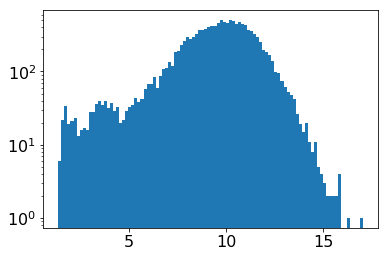

In [86]:
x = plt.hist(obs_data[(obs_data.runcat == 1) & \
                      (obs_data.freq_eff > 60000000 )].det_sigma, 
             bins=100, log=True)

In [98]:
data_ind = (obs_data.url == '/mnt/ais001/ASf_201804141730/2018-04-14T18:00:00-S298.5-B8.fits')

# plt.scatter( obs_data[data_ind].ra,obs_data[data_ind].decl,
#             c=20*obs_data[data_ind].f_peak/obs_data[data_ind].det_sigma)




CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')


list_ra = [x*u.degree for x in obs_data[data_ind].ra]
list_decl = [x*u.degree for x in obs_data[data_ind].decl]

position = SkyCoord(list_ra, list_decl)


obs_times = [i for i in pd.to_datetime(np.unique(obs_data[data_ind].taustart_ts.dt.round("1s")))]


altaz = position.transform_to(AltAz(obstime=obs_times, location=CS002))


# plt.scatter( altaz.alt.deg, obs_data[data_ind].decl,
#             c=20*obs_data[data_ind].f_peak/obs_data[data_ind].det_sigma)


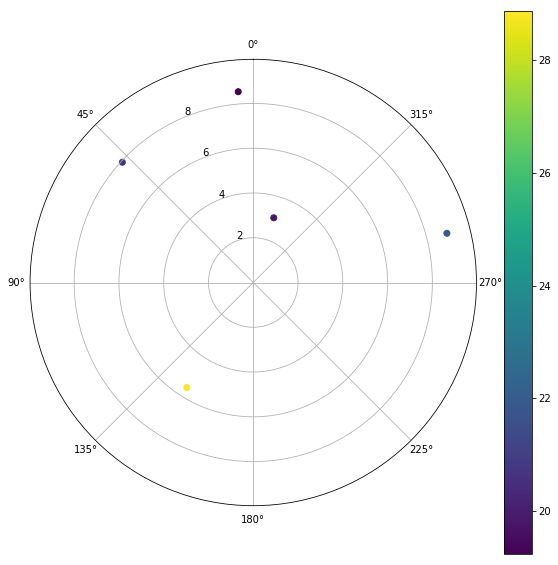

In [129]:
%matplotlib inline

min_r = 10

plt.figure(figsize=(10,10))
ax = plt.subplot(projection="polar")
plt.scatter( altaz.az.rad[(90-altaz.alt.deg) < min_r], 
            (90-altaz.alt.deg)[(90-altaz.alt.deg) < min_r], 
            c=3*(obs_data[data_ind].f_peak/obs_data[data_ind].det_sigma)[(90-altaz.alt.deg) < min_r])

ax.set_theta_zero_location("N")
plt.colorbar()

In [132]:
print (obs_data[data_ind].f_peak)[(90-altaz.alt.deg) < 10]
print 3*(obs_data[data_ind].f_peak/obs_data[data_ind].det_sigma)[(90-altaz.alt.deg) < min_r]

15     63.483778
21     38.043284
22     45.666119
68    192.002290
90     24.596401
Name: f_peak, dtype: float64
15    21.934268
21    20.733030
22    19.829803
68    28.875626
90    19.234336
dtype: float64


### number of detections of a given signicicance vs. number of images,

are these just the tail of a distribution? 

In [ ]:
"""SELECT ex.f_int, ex.f_int_err,ex.f_peak, 
    ex.det_sigma, extract_type, 
    ex.ra, 
    ex.decl, 
    im.band, 
    im.taustart_ts, im.url 
    FROM extractedsource ex, image im 
    WHERE ex.id IN ( select xtrsrc FROM assocxtrsource WHERE runcat = 4448) 
    AND ex.image = im.id
    ORDER BY ex.det_sigma DESC;
    """


In [8]:
AS_db = "A12_20190303"
dataset = "1"


logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=AS_db)

db.connect()
session = db.Session()

transients_query = """
    SELECT id, wm_ra, wm_decl, datapoints FROM runningcatalog WHERE 
        runningcatalog.wm_ra >= 178. AND 
        runningcatalog.wm_ra <= 179. AND 
        runningcatalog.wm_decl >= 54. AND 
        runningcatalog.wm_decl <= 55.
    """

obs_GP = pd.DataFrame(run_query(transients_query, AS_db, dataset, engine, host, port, user, password))


print "database name: ",  AS_db
print obs_GP.id.values
obs_GP["db"] = AS_db
all_GP_db = all_GP_db.append(obs_GP)

db._configured = False
del db, session

obs_GP.sort_values("datapoints")
#     print "\t", obs_len

database name:  A12_20190303
[  199   986  7200  2088   275    40   792  5700   604  1048   475  1399
  1581 16756   355  5941  1243  1771   418  3301   128  1111   851  2202
   542  3088  1711  6171  1457   672  1651  2874   920  2037  1304  1174
  2471  1520  1861  4454   728  2146  1979  2255  2530  2633  2689  2926
  1922  2818  2307  2986  3748  2745  2363  3191  3646  2415  2579  6298
  3429  3142  3495  3378  6660  3243  5581  5013  3541  4610  3598  6415
  4516  3886  5408  4154  3834  5164  4730  4950  3979  5105  4260  5466
  6054  5225  5763 13894  5343  9382  6239  5876  5522  5287  5820  6775
  5639 10078  6114  7138  6358 12713  6000  8382  6476  7012  6835  7072
  6592 14676  6534 14961  6889  6720  6950  7267  7645  7706  7327  7394
  7584  8452  7458  7518  7838  9115  7899  9467  8969  7766  9042  7998
  8515 17847 18047  8253  8318  8068  8130  8901  8187  8837 16058  9312
 17130 12984  8643 17911 17980  8714 10190  8771  8585  9581 15293  9188
 11362  9639  9247  95

datapoints     id    wm_decl       wm_ra            db
0             2    199  54.892532  178.830115  A12_20190303
169           2  10751  54.877939  178.794350  A12_20190303
170           2  10804  54.855547  178.822142  A12_20190303
171           2  10358  54.897896  178.809077  A12_20190303
172           2  14413  54.890163  178.854438  A12_20190303
173           2  11477  54.895428  178.806962  A12_20190303
174           2  10698  54.880308  178.804657  A12_20190303
175           2  10416  54.872687  178.791588  A12_20190303
176           2  10533  54.873487  178.798858  A12_20190303
177           2  10477  54.873794  178.811392  A12_20190303
178           2  15026  54.885616  178.824300  A12_20190303
179           2  10592  54.863529  178.822996  A12_20190303
180           2  11651  54.883514  178.825553  A12_20190303
181           2  16124  54.885391  178.818989  A12_20190303
182           2  10641  54.877844  178.806186  A12_20190303
183           2  10985  54.863631  178.828341  A12_20190303
184           2  10863  54.864247  178.837552  A12_20190303
185           2  11535  54.891382  178.804461  A12_20190303
186           2  15697  54.883791  178.849438  A12_20190303
187           2  11088  54.882893  178.822208  A12_20190303
188           2  11592  54.899232  178.817334  A12_20190303
189           2  11142  54.875973  178.823074  A12_20190303
190           2  11420  54.885487  178.813822  A12_20190303
191           2  11195  54.881287  178.779100  A12_20190303
192           2  12175  54.896615  178.786210  A12_20190303
193           2  11252  54.896086  178.817812  A12_20190303
194           2  13113  54.863257  178.808092  A12_20190303
195           2  14162  54.904487  178.848414  A12_20190303
196           2  11305  54.875261  178.816031  A12_20190303
197           2  12337  54.887855  178.810604  A12_20190303
..          ...    ...        ...         ...           ...
70            2   3598  54.902276  178.847078  A12_20190303
71            2   6415  54.905815  178.775835  A12_20190303
72            2   4516  54.906623  178.831702  A12_20190303
73            2   3886  54.899127  178.820072  A12_20190303
74            2   5408  54.899412  178.816016  A12_20190303
75            2   4154  54.905293  178.849470  A12_20190303
76            2   3834  54.895179  178.828985  A12_20190303
77            2   5164  54.915298  178.830891  A12_20190303
78            2   4730  54.896253  178.835759  A12_20190303
79            2   4950  54.905238  178.834061  A12_20190303
80            2   3979  54.904323  178.824264  A12_20190303
81            2   5105  54.895905  178.821306  A12_20190303
66            2   5581  54.904400  178.815093  A12_20190303
82            2   4260  54.884992  178.826414  A12_20190303
84            2   6054  54.911330  178.791176  A12_20190303
85            2   5225  54.916105  178.826973  A12_20190303
86            2   5763  54.906345  178.796986  A12_20190303
87            2  13894  54.899253  178.873304  A12_20190303
88            2   5343  54.902049  178.811975  A12_20190303
89            2   9382  54.884312  178.810436  A12_20190303
90            2   6239  54.904332  178.800341  A12_20190303
91            2   5876  54.892150  178.799721  A12_20190303
92            2   5522  54.909876  178.799583  A12_20190303
93            2   5287  54.904027  178.810026  A12_20190303
94            2   5820  54.901340  178.810616  A12_20190303
95            2   6775  54.879231  178.802849  A12_20190303
96            2   5639  54.897785  178.797374  A12_20190303
97            2  10078  54.864867  178.809624  A12_20190303
83            2   5466  54.896628  178.816905  A12_20190303
266           2  17712  54.895880  178.788562  A12_20190303

[267 rows x 5 columns]

### Flux calibrate in DB

In [66]:
dbname = "_201611132000"
dataset = 1
#     print dbname, dataset
#     print "database name: ",  dbname
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                 user=user, password=password, database=dbname)

db.connect()
session = db.Session()

transients_query = """SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl 
FROM extractedsource ex 
WHERE ex.image = (SELECT id FROM image WHERE taustart_ts = '2016-11-13 20:00:21.619' AND band = 24);"""

image_pyse = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

db._configured = False
del db, session


Found 73 new sources


/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


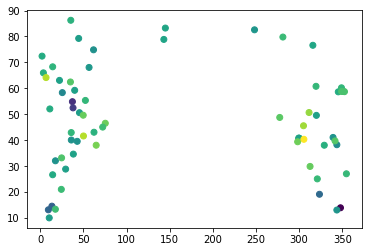

In [67]:
plt.scatter(image_pyse.ra,image_pyse.decl, c=np.log10(image_pyse.f_int))

In [7]:
def distSquared(p0, p1):
    '''
    Calculate the distance between point p0, [x,y], and a list of points p1, [[x0..xn],[y0..yn]]. 
    '''
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 1.0:
        return np.where(distance == np.min(distance))[0]
    else:
        return None

def pol2cart(rho, phi):
    """
    Polar to Cartesian coordinate conversion, for distance measure around celestial pole.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def compare_flux(sr, catalog_ras, catalog_decs, catalog_fluxs, catalog_flux_errs):
    '''
    Compares the two catalogues, matching sources, and outputs the results of linear fit to the fluxes. 
    '''
    x = []
    y = []

    w = []
    sr_indexes = []
    cat_indexes = []


    for i in range(len(sr)):

        sr_x, sr_y = pol2cart(np.abs(90-sr.iloc[i].decl),
                np.deg2rad(sr.iloc[i].ra))

        cat_x, cat_y = pol2cart(np.abs(90-catalog_decs),
                np.deg2rad(catalog_ras))

        index = distSquared((sr_x,sr_y),
                   np.array([cat_x, cat_y]))

        if type(index) == np.ndarray:
            flux = catalog_fluxs[index]
            flux_err = catalog_flux_errs[index]

            cat_indexes.append(index)
            sr_indexes.append(i)
            y.append(float(sr.iloc[i].f_int))
            x.append(float(flux))
            w.append(float(sr.iloc[i].f_int_err))
        else:
            continue
            
    if len(x) > 2:
        w = np.array(w,dtype=float)
        fit = np.polyfit(x,y,1,w=1./w)
    else:
        fit = [1e9,1e9]

    return fit[0], fit[1]




In [69]:
ref_cat = pd.read_csv("~/AARTFAAC_catalogue.csv")

slope_cor, intercept_cor = compare_flux(image_pyse,
                                       ref_cat["ra"],
                                       ref_cat["decl"],
                                       ref_cat["f_int"],
                                       ref_cat["f_int_err"])

In [70]:
print slope_cor, intercept_cor

1.66783999995 8.24990832664


In [78]:
for i in range(len(image_pyse.f_int)):
    print (image_pyse.iloc[i].f_int- intercept_cor)/slope_cor, image_pyse.iloc[i].ra, image_pyse.iloc[i].decl

43.8268919373 248.320319563 82.5828355717
51.423244475 45.375890415 50.5910973229
32.4667433457 343.769229672 38.2147480897
11.466642275 9.33354032717 13.0882306606
57.0890909261 22.24018133 63.0617748736
49.87832747 10.3465887931 9.96728694655
-5.46631753189 36.8741749291 28.0154887323
-5.87252781496 95.8518262839 71.5137043608
30.3084596406 25.5140522168 58.332866017
-37.4043772744 354.325009505 57.1113004148
42.8388937584 351.157008656 58.8255502618
-8.19852977727 347.669840205 60.4345261875
-2.20068547679 347.969838059 13.8662037391
13.0139955802 323.602823919 19.0842583564
39.2226399349 339.361666799 41.0319681564
59.4108918159 300.103092886 40.7163197247
74.6955608164 299.5123121 40.7785496343
-9.7132887652 341.635997119 14.2031027784
-14.6276620228 286.60979915 73.89872368
-25.6864005149 350.795450171 29.5823027396
10.177770196 13.4375321057 14.4915135999
57.8734142447 320.046077254 49.5462588247
52.574917023 44.4769080499 79.2577022613
37.8001998657 61.6975801571 74.8615844276


In [81]:
# image_pyse.f_int = (image_pyse.f_int - intercept_cor)/slope_cor
image_pyse.f_int_err = (image_pyse.f_int_err - intercept_cor)/slope_cor

In [82]:
image_pyse.to_csv("~/DB_fluxfit.csv")

In [ ]:
# Get elements were the datapoints are greater than half

''' SELECT id, wm_ra, wm_decl, datapoints  
FROM runningcatalog 
WHERE datapoints >= 0.5* (SELECT MAX(datapoints) FROM runningcatalog)'''


# Get elements between the date range
'''SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, rm.id 
            FROM extractedsource ex, runningcatalog rm
            WHERE ex.image IN (SELECT id FROM image 
            WHERE taustart_ts BETWEEN '2017-02-25 01:45:00' AND '2017-02-25 02:00:00');'''

# Get flux measurements and running catalog ids between time range
# Seem to be the same speed
'''SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat 
            FROM extractedsource ex, assocxtrsource ax
            WHERE ex.image IN (SELECT id FROM image 
            WHERE taustart_ts BETWEEN '2017-02-25 01:45:00' AND '2017-02-25 02:00:00') 
            AND ax.xtrsrc = ex.id;'''

'''SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat 
            FROM extractedsource ex, assocxtrsource ax, image im  
            WHERE im.taustart_ts BETWEEN '2017-02-25 01:45:00' AND '2017-02-25 02:00:00' 
            AND ax.xtrsrc = ex.id AND ex.image = im.id;'''


## Time intensity correlation 

<IPython.core.display.Javascript object>


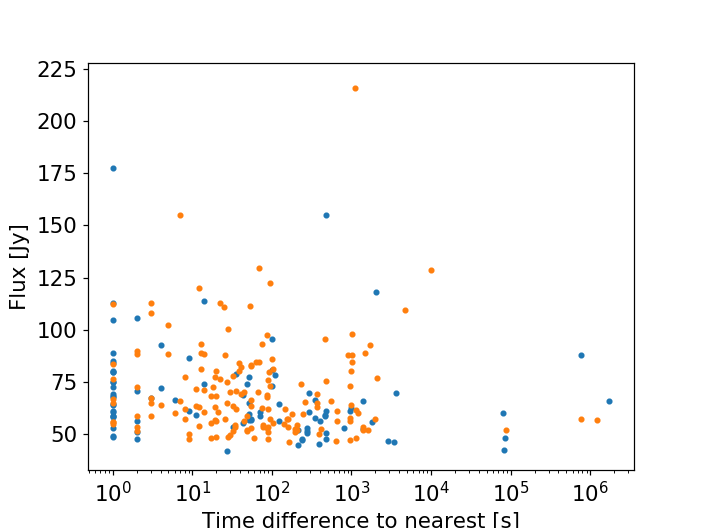

In [74]:

diff = []
flux = []

sub_GP = all_GP[all_GP.freq_eff < 60000000]

n = 0
for t in sub_GP.taustart_ts:
    
    ind =  np.argmin(np.abs(pd.to_datetime(t) - pd.to_datetime(sub_GP.taustart_ts.drop(sub_GP.index[n]))))
    diff.append(np.abs(pd.to_datetime(sub_GP.taustart_ts.loc[ind]) - pd.to_datetime(t)).total_seconds())
    flux.append(sub_GP.f_int.loc[sub_GP.index[n]])
    n += 1
    
plt.figure()
plt.plot(diff,flux,".")
plt.xscale("log")

plt.xlabel("Time difference to nearest [s]")
plt.ylabel("Flux [Jy]")
# plt.xlim([0,5000])


diff = []
flux = []

sub_GP = all_GP[all_GP.freq_eff > 60000000]

n = 0
for t in sub_GP.taustart_ts:
    
    ind =  np.argmin(np.abs(pd.to_datetime(t) - pd.to_datetime(sub_GP.taustart_ts.drop(sub_GP.index[n]))))
    diff.append(np.abs(pd.to_datetime(sub_GP.taustart_ts.loc[ind]) - pd.to_datetime(t)).total_seconds())
    flux.append(sub_GP.f_int.loc[sub_GP.index[n]])
    n += 1
    

plt.plot(diff,flux,".")
plt.xscale("log")

plt.xlabel("Time difference to nearest [s]")
plt.ylabel("Flux [Jy]")
# plt.xlim([0,5000])

plt.show()

<IPython.core.display.Javascript object>


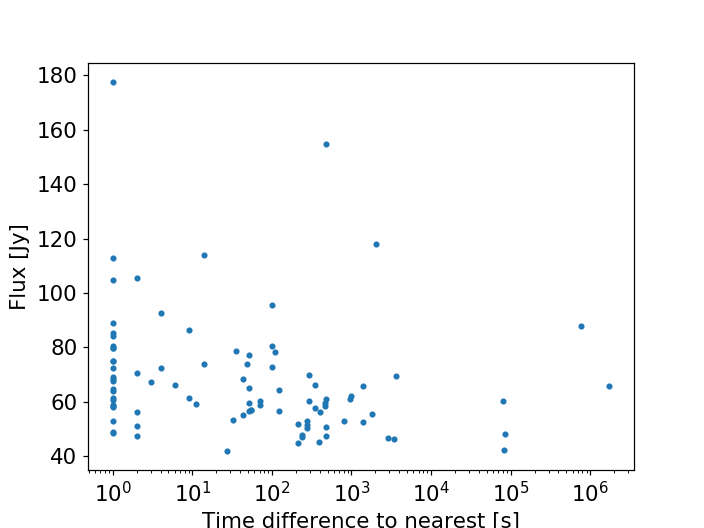

## Flux calibrate Giant Pulses. 



In [ ]:

def distSquared(p0, p1):
    '''
    Calculate the distance between point p0, [x,y], and a list of points p1, [[x0..xn],[y0..yn]]. 
    '''
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 0.5:
        return np.where(distance == np.min(distance))[0]
    else:
        return None

def pol2cart(rho, phi):
    """
    Polar to Cartesian coordinate conversion, for distance measure around celestial pole.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def run_query(transients_query, dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
#     print "Found", len(transients), "new sources"
    return transients

def compare_flux(sr, catalog_ras, catalog_decs, catalog_fluxs, catalog_flux_errs):
    '''
    Compares the two catalogues, matching sources, and outputs the results of linear fit to the fluxes. 
    '''
    x = []
    y = []

    w = []
    sr_indexes = []
    cat_indexes = []


    for i in range(len(sr)):

        sr_x, sr_y = pol2cart(np.abs(90-sr.iloc[i].decl),
                np.deg2rad(sr.iloc[i].ra))

        cat_x, cat_y = pol2cart(np.abs(90-catalog_decs),
                np.deg2rad(catalog_ras))

        index = distSquared((sr_x,sr_y),
                   np.array([cat_x, cat_y]))

        if type(index) == np.ndarray:
            flux = catalog_fluxs[index]
            flux_err = catalog_flux_errs[index]

            cat_indexes.append(index)
            sr_indexes.append(i)
            y.append(float(sr.iloc[i].f_int))
            x.append(float(flux))
            w.append(float(sr.iloc[i].f_int_err))
        else:
            continue

    if len(x) > 2:
        w = np.array(w,dtype=float)
        fit = np.polyfit(x,y,1,w=1./w)
    else:
        fit = [1e9,1e9]

    return fit[0], fit[1], x, y, cat_indexes

In [ ]:
ref_cat = pd.read_csv("~/AARTFAAC_catalogue.csv")
engine = 'postgresql'
host = 'ads001'
port = 5432
user = 'mkuiack'
password = 'Morecomplicatedpass1234'

query_loglevel = logging.WARNING 



In [ ]:
db._configured = False
del db, session


In [ ]:
t1 = time.time()

flux_compare = []
giant_pulse_list = glob.glob("/home/kuiack/PSR_0950+08/*csv")

for i in giant_pulse_list:

    dbname = i.split("-")[1]

    if dbname[0] == "_":
        dbname = "ASr"+dbname
    
    dataset = 1

#     logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)


    db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

    db.connect()
    session = db.Session()
        



    GP_df = pd.read_csv(i, delimiter="|")
    GP_df = GP_df.rename(columns=lambda x: x.strip())

    GP_df['f_int_cal'] = pd.Series(np.zeros(len(GP_df)), index=GP_df.index)
    GP_df['slope'] = pd.Series(np.zeros(len(GP_df)), index=GP_df.index)
    GP_df['intercept'] = pd.Series(np.zeros(len(GP_df)), index=GP_df.index)


    for j in range(len(GP_df)):


        transients_query = """SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl 
        FROM extractedsource ex 
        WHERE ex.image = (SELECT id FROM image 
        WHERE taustart_ts = '{}' AND band = {});""".format(GP_df.iloc[j].taustart_ts.strip(),
                                                           GP_df.iloc[j].band)
    


        image_pyse = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

        slope_cor, intercept_cor, ref_match, image_match, index_match = compare_flux(image_pyse,
                                           ref_cat["ra"],
                                           ref_cat["decl"],
                                           ref_cat["f_int"],
                                           ref_cat["f_int_err"])

#         print slope_cor, intercept_cor

        GP_df["f_int_cal"].iloc[j] = (GP_df.iloc[j].f_int - intercept_cor)/slope_cor
        GP_df["slope"].iloc[j] = slope_cor
        GP_df["intercept"].iloc[j] = intercept_cor

        flux_compare.append([np.array(ref_match),
                             (np.array(image_match) - intercept_cor)/slope_cor,
                            np.array(np.ravel(index_match))])
        if max((np.array(image_match) - intercept_cor)/slope_cor) > 600:
            print dbname, GP_df.iloc[j].taustart_ts.strip(), GP_df.iloc[j].band
        
    db._configured = False
    del db, session
#     GP_df.to_csv(i+"corr", index=False)

print "processing time:", time.time() -t1


In [ ]:
test = pd.DataFrame([])

for i in range(len(flux_compare)):

    if len(test) == 0:
        test = pd.DataFrame({"reference":flux_compare[i][0],
                             "image":flux_compare[i][1]},
                            index=flux_compare[i][2])

    else:
        test = pd.concat([test,
               pd.DataFrame({"reference":flux_compare[i][0],
                             "image":flux_compare[i][1]},
                            index=flux_compare[i][2])])
group_test = test.groupby(test.index).median()


In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14
       }
matplotlib.rc('font', **font)


plt.figure(figsize=(8,8))
upper_limit = 700
lower_limit = -40
plt.plot([lower_limit,upper_limit],
         [lower_limit,upper_limit],"--",c="k", label="1:1", zorder =1)
plt.plot( test.reference,test.image, ".", label="Individual Extraction")
# plt.plot(group_test.reference, group_test.image, ".", label="Measurement median")
plt.errorbar(group_test.reference, group_test.image, yerr=0.25*group_test.image,
             fmt=".",color="C3",ecolor="C1", label="Measurement Median", zorder=10)




plt.xlim([lower_limit,upper_limit])
plt.ylim([lower_limit,upper_limit])

plt.xlabel("Reference [Jy]")
plt.ylabel("Image [Jy]")
plt.legend()

In [ ]:
import matplotlib.gridspec as gridspec

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14
       }
matplotlib.rc('font', **font)

plt.figure(figsize=(8,6))
gs1 = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
gs1.update(wspace=0.0, hspace=0.0)



# plt.subplot(121)
plt.subplot(gs1[0])
plt.plot( test.image/test.reference, ".", label="Individual Extraction")
plt.ylabel("Image / Reference")
plt.xlabel("Extracted sources")
(mu, sigma) = norm.fit(test.image/test.reference)
#     n, bins, patches   =  plt.hist(source_df["f_int"].values[hist_index],
#                                    bins=100,normed=1, orientation='horizontal',facecolor="#1f77b4")


# plt.subplot(122)
plt.subplot(gs1[1])
n, bins, patches   =  plt.hist(test.image/test.reference, bins=100, normed=1, orientation="horizontal")
y = mlab.normpdf( bins, mu, sigma)
plt.plot(y,bins,"--", c="red", label=r"$\mu$"": {}\n"r"$\sigma$"": {}".format(round(mu,3),round(sigma,3)))
plt.legend()
plt.yticks([])


# plt.xlim([-0.5,4])
print "mu:", mu,"sigma:", sigma

plt.tight_layout()
plt.savefig("/home/kuiack/B0950+08_figs/source_compare.pdf")
# plt.tight_layout()

## Monitor list 

In [5]:
t1 = time.time()
dbname = "AS_PSR_20180414"
dataset = 1

logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                 user=user, password=password, database=dbname)

db.connect()
session = db.Session()

transients_query = """SELECT ex.f_int, 
ex.f_int_err, ex.det_sigma,ex.chisq, ex.reduced_chisq, 
ex.ra, 
ex.decl, 
ax.runcat,
im.taustart_ts, im.freq_eff, im.rms_min, im.rms_max  
            FROM extractedsource ex, assocxtrsource ax, image im
            WHERE ax.xtrsrc = ex.id 
            AND ex.image = im.id; 
"""

#  Takes a long time when runningcatalog is included in the FROM, 

# transients_query = """SELECT ex.f_int, 
# ex.f_int_err, ex.det_sigma,ex.chisq,ex.reduced_chisq, 
# ex.ra, 
# ex.decl, 
# ax.runcat,
# im.taustart_ts, im.freq_eff, im.rms_min, im.rms_max  
#             FROM extractedsource ex, assocxtrsource ax, image im, runningcatalog rc
#             WHERE ax.xtrsrc = ex.id 
#             AND ex.image = im.id
#             AND rc.wm_ra >= 143. 
#             AND rc.wm_ra <= 153. 
#             AND rc.wm_decl >= 3. 
#             AND rc.wm_decl <= 12. ; 
# """


image_pyse = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

db._configured = False
del db, session

print "time:", time.time() - t1

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
No handlers could be found for logger "tkp.db.database"


time: 117.800477982


In [6]:
print np.min(image_pyse.taustart_ts)

print np.max(image_pyse.taustart_ts)

2018-04-14 18:00:00
2018-04-14 21:59:59


1
13692


/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


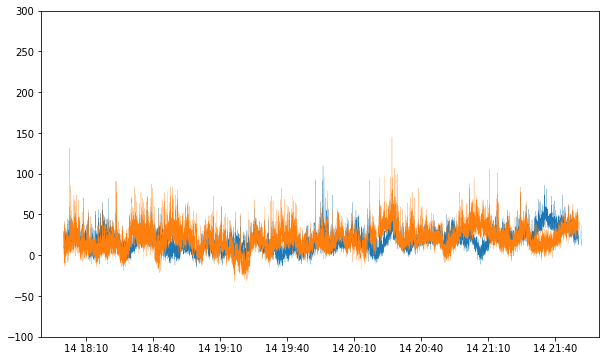

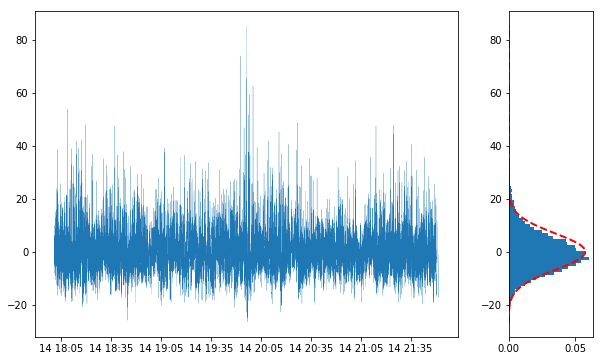

40
13346


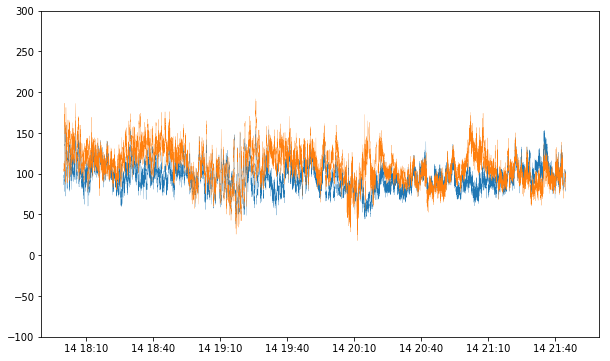

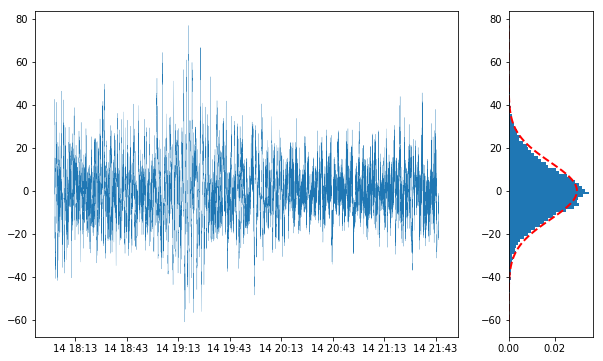

3
13123


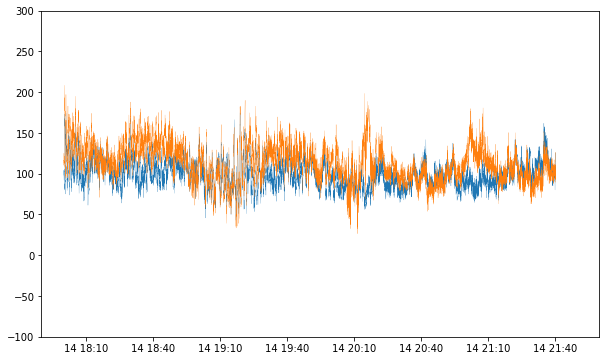

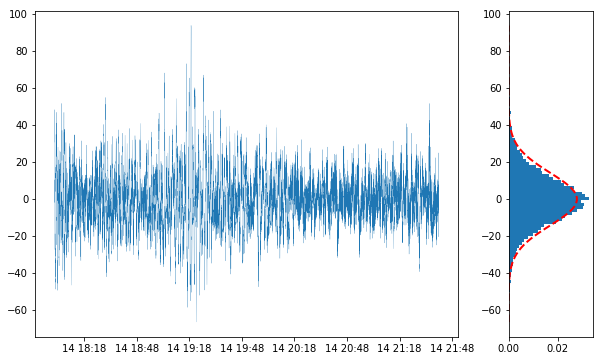

111
10906


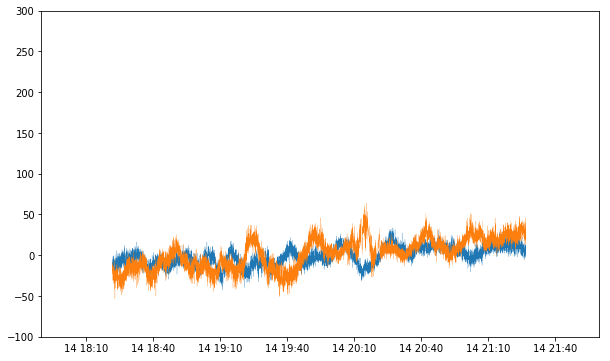

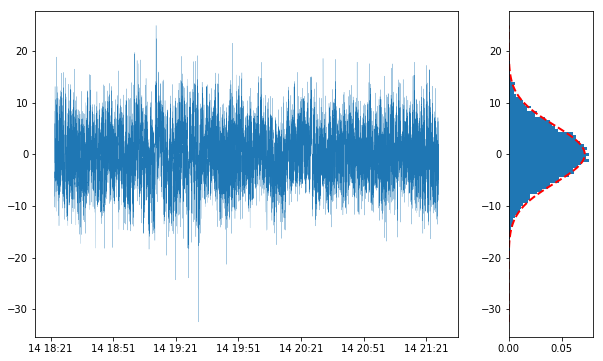

114
10862


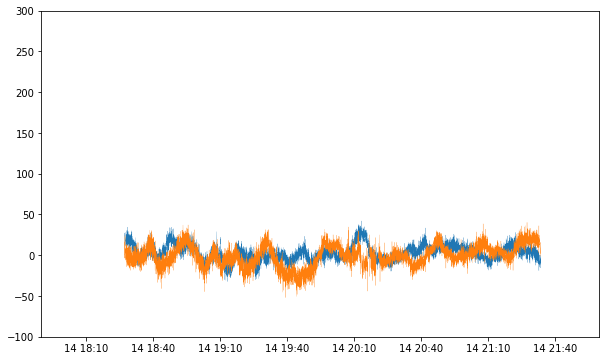

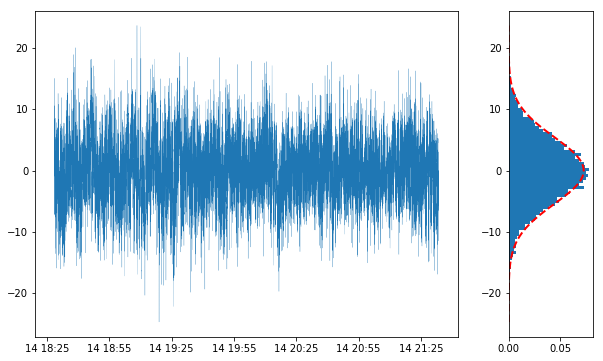

105
13449


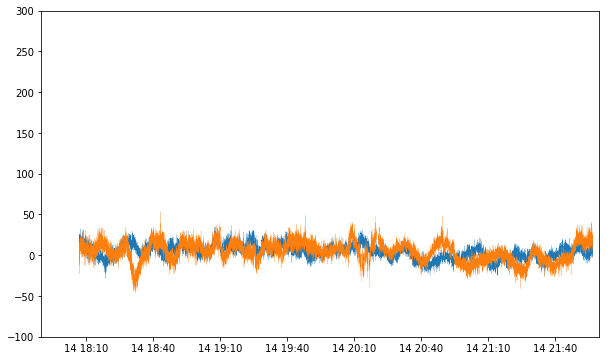

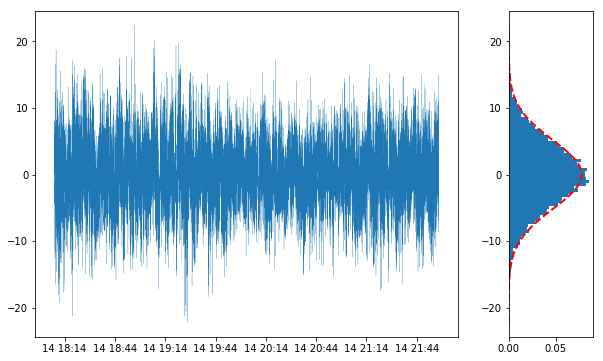

2
14033


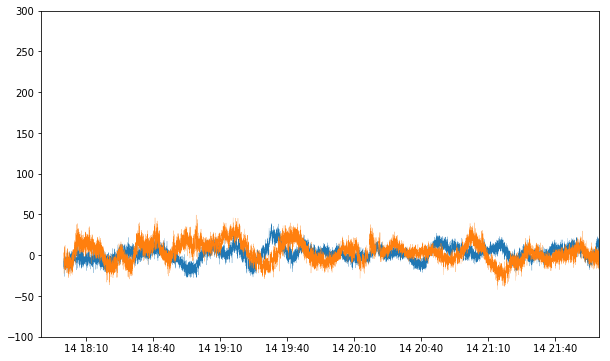

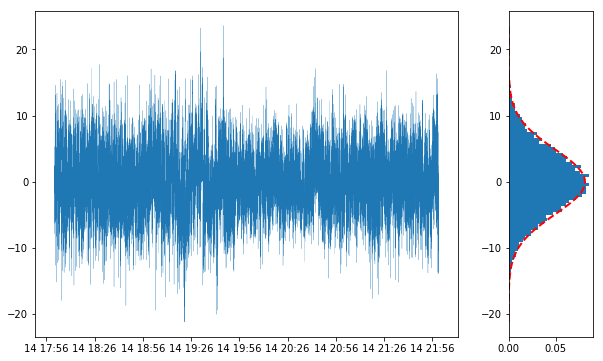

In [6]:


roll_len = 1*60
roll_type = 'triang'


for i in [1,40,3,111,114,105,2,]:
    print i
    plt.figure(figsize=(10,6))
    bool_index = (image_pyse.runcat == i) &\
                        (image_pyse.freq_eff < 60000000) &\
                        (image_pyse.rms_min < 12)
            
    plt.plot(image_pyse[bool_index].taustart_ts,
             image_pyse[bool_index].f_int, lw=0.2)
    
    print len(image_pyse[bool_index].f_int)
    
    plt.xlim([datetime.datetime(2018, 4, 14,18,3), 
          datetime.datetime(2018, 4, 14, 22,0)])
    
    
    bool_index = (image_pyse.runcat == i) &\
                        (image_pyse.freq_eff > 60000000) &\
                        (image_pyse.rms_min < 12)
    
            
    plt.plot(image_pyse[bool_index].taustart_ts,
             image_pyse[bool_index].f_int, lw=0.2)
    
    plt.xlim([datetime.datetime(2018, 4, 14, 17, 50), 
          datetime.datetime(2018, 4, 14, 22, 0)])
    
    plt.ylim([-100,300])

    

    plt.figure(figsize=(10,6))

    gs = gridspec.GridSpec(1, 2, width_ratios=[5,1])

    bool_index = (image_pyse.runcat == i) &\
                        (image_pyse.freq_eff < 60000000) &\
                        (image_pyse.rms_min < 12)

    rolling = image_pyse[bool_index].f_int.rolling(roll_len, win_type=roll_type)

    plt.subplot(gs[0])
    plt.plot(image_pyse[bool_index].taustart_ts,
             image_pyse[bool_index].f_int-rolling.mean()  , lw=0.2)
#     plt.plot(image_pyse[bool_index].taustart_ts,
#              image_pyse[bool_index].f_int  , lw=0.2)

    plt.subplot(gs[1])
    hist_dat = image_pyse[bool_index].f_int-rolling.mean()
#     hist_dat = image_pyse[bool_index].f_int
    
    n, bins, patches = plt.hist(hist_dat[np.isfinite(hist_dat)], 
                                orientation="horizontal", bins=100, normed=1)

#     (mu, sigma) = norm.fit(hist_dat[np.isfinite(hist_dat)])
    
    (mu, sigma) = halfnorm.fit(np.abs(hist_dat[np.isfinite(hist_dat) & (hist_dat < 0)]))
#     (mu, sigma) = halfnorm.fit(np.abs(hist_dat[np.isfinite(hist_dat)]))

    y = mlab.normpdf( bins, -mu, sigma)
    l = plt.plot(y,bins,'r--', linewidth=2)
    
    
    
#     plt.figure(figsize=(10,6))
#     (mu, sigma) = halfnorm.fit(np.abs(hist_dat[np.isfinite(hist_dat) & (hist_dat < 0)]))
#     n, bins, patches = plt.hist(np.abs(hist_dat[np.isfinite(hist_dat) & (hist_dat < 0)]), 
#                             orientation="horizontal", bins=30, normed=1)
#     print (mu, sigma)
#     # y = mlab.normpdf( bins, mu, sigma)
#     # l = plt.plot(y,bins,'r--', linewidth=2)

#     plt.plot(halfnorm.pdf(bins, loc=mu, scale=sigma), bins, 'k-', lw=2, label='frozen pdf')

    
    
    
    
    
    plt.show()


779
396


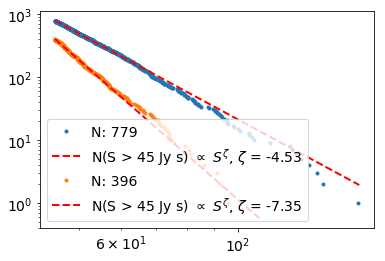

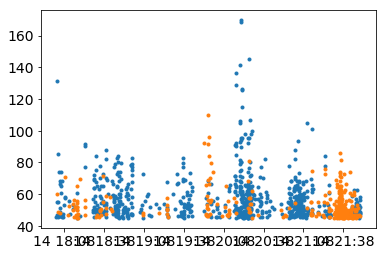

In [73]:
Smin = 45


# bool_index = (image_pyse.runcat == i) &\
#                     (image_pyse.freq_eff < 60000000) &\
#                     (image_pyse.rms_min < 12)
plt.figure(1)
index = ((image_pyse.runcat == 1) &\
         (image_pyse.f_int/image_pyse.det_sigma < Smin )  &\
         (image_pyse.f_int > Smin ) &\
         (image_pyse.freq_eff > 60000000.0)).values 

print np.sum(index)

x = np.sort(image_pyse[index].f_int) 
# print "max:", np.max(x), "min", np.min(x)

y = np.array((np.array(range(len(image_pyse[index].f_int))[::-1])))


fit, cov = curve_fit(powlaw, x, y)

plt.plot(x,y, ".", label="N: "+str(np.sum(index)))

plt.plot(x,
         powlaw(x, fit[0], fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy s) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( Smin , 
                                                        round(fit[1],2)),zorder=5)
plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.figure(2)
plt.plot(image_pyse[index].taustart_ts, image_pyse[index].f_int,".")

plt.figure(1)

index = ((image_pyse.runcat == 1) &\
         (image_pyse.f_int/image_pyse.det_sigma < Smin )  &\
         (image_pyse.f_int > Smin ) &\
         (image_pyse.freq_eff < 60000000.0)).values 

print np.sum(index)

x = np.sort(image_pyse[index].f_int) 
# print "max:", np.max(x), "min", np.min(x)

y = np.array((np.array(range(len(image_pyse[index].f_int))[::-1])))


fit, cov = curve_fit(powlaw, x, y, maxfev = 1800)

plt.plot(x,y, ".", label="N: "+str(np.sum(index)))

plt.plot(x,
         powlaw(x, fit[0], fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy s) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( Smin , 
                                                        round(fit[1],2)),zorder=5)
plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.figure(2)
plt.plot(image_pyse[index].taustart_ts, image_pyse[index].f_int,".")




1.29110414728
2.59486672747


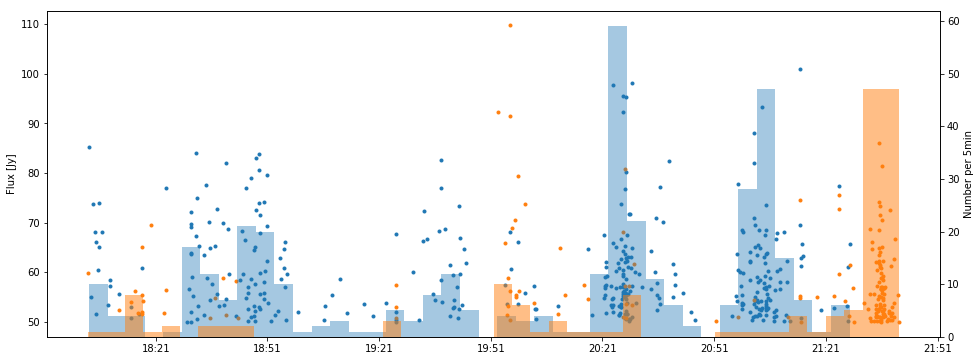

In [8]:
_interval = "5min"

Smin = 50

fig = plt.figure(figsize=(16,6))

ax1 = plt.subplot(111)

index = ((image_pyse.runcat == 1) &\
         (5*image_pyse.f_int/image_pyse.det_sigma < Smin )  &\
         (image_pyse.f_int > Smin ) &\
         (image_pyse.freq_eff > 60000000.0) & (image_pyse.rms_min < 12)).values 


ax1.plot(image_pyse[index].taustart_ts, image_pyse[index].f_int,".", color="C0")





# ax1.plot(image_pyse[index].taustart_ts, image_pyse[index].f_int,".",color="C0")



ax2 = ax1.twinx()

ax2.set_ylabel("Number per {}".format(_interval))

n = ax2.hist(image_pyse[index].taustart_ts, 
             bins=len(pd.date_range(start=np.min(pd.to_datetime( image_pyse[index].taustart_ts)),
                                    end=np.max(pd.to_datetime(image_pyse[index].taustart_ts)),
             freq=_interval)), alpha=0.4)

# D = std(n)/mean(n)
# D = 1: poisson, D > 1: clustered, D < 1: anit-clusterd (over regular)

print np.std(n[0])/np.mean(n[0])


index = ((image_pyse.runcat == 1) &\
         (5*image_pyse.f_int/image_pyse.det_sigma < Smin )  &\
         (image_pyse.f_int > Smin ) &\
         (image_pyse.freq_eff < 60000000.0)& (image_pyse.rms_min < 12)).values 

ax1.plot(image_pyse[index].taustart_ts, image_pyse[index].f_int,".", color="C1")


raw_X = np.array((image_pyse[index].taustart_ts.values[1:] - image_pyse[index].taustart_ts.values[:-1])/1e9, dtype=np.float)
ax1.set_ylabel("Flux [Jy]")

n = ax2.hist(image_pyse[index].taustart_ts, 
             bins=len(pd.date_range(start=np.min(pd.to_datetime( image_pyse[index].taustart_ts)),
                                    end=np.max(pd.to_datetime(image_pyse[index].taustart_ts)),
             freq=_interval)), alpha=0.5, color="C1")

# D = std(n)/mean(n)
# D = 1: poisson, D > 1: clustered, D < 1: anit-clusterd (over regular)

myFmt = mdates.DateFormatter('%H:%M')
ax2.xaxis.set_major_formatter(myFmt)

ax1.xaxis.set_label("Time UTC [hh:mm]")


print np.std(n[0])/np.mean(n[0])


plt.savefig("/home/kuiack/B0950+08_figs/raw_cluster_timeseries.pdf")



(1.0, 65.02185792349727)
(1.0, 65.02185792349727)
Power_divergenceResult(statistic=0.1297936920026885, pvalue=1.0)


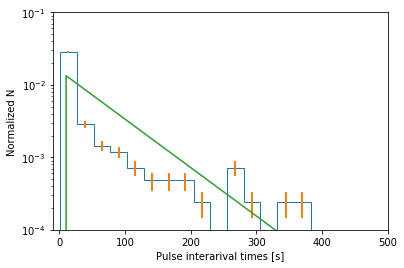

In [36]:
raw_P= ss.expon.fit(raw_X)
print P

print P
raw_n = plt.hist(raw_X, normed=True, bins=100, histtype="step")
raw_mid = 0.5*(raw_n[1][1:] + raw_n[1][:-1])
plt.errorbar(raw_mid, raw_n[0], yerr=np.sqrt(raw_n[0])/len(raw_X), fmt='none',elinewidth=2)



raw_rX = np.linspace(0,1000, 100)
raw_rP = ss.expon.pdf(raw_rX, *P)

plt.plot(raw_rX, raw_rP)
plt.yscale("log")
# plt.xscale("log")

print chisquare(n[0], 
          f_exp=ss.expon.pdf(n[1][:-1], *P))

plt.ylim([1e-4,1e-1])
plt.xlim([-10,500])
plt.ylabel("Normalized N")
plt.xlabel("Pulse interarival times [s]")
plt.savefig("/home/kuiack/B0950+08_figs/raw_cluster_dist.pdf")

/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in power


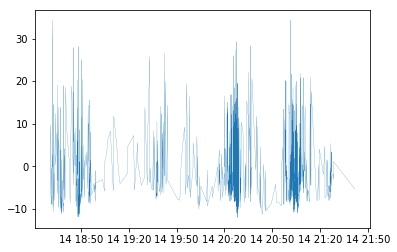

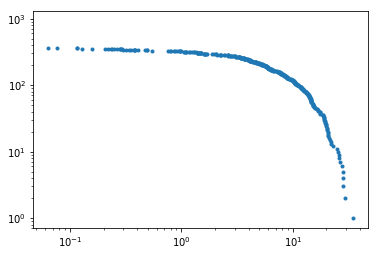

In [17]:
Smin = 40

roll_len = 1*60
roll_type = 'triang'


# complete
index = ((image_pyse.runcat == 1) &\
         (5*image_pyse.f_int/image_pyse.det_sigma < Smin )  &\
         (image_pyse.f_int > Smin ) &\
         (image_pyse.freq_eff > 60000000.0)).values 


plt.figure(3)
# smooth
rolling = image_pyse[index].f_int.rolling(roll_len, win_type=roll_type)



plt.subplot()
plt.plot(image_pyse[index].taustart_ts,
         image_pyse[index].f_int-rolling.mean(), lw=0.2)


f_smooth = (image_pyse[index].f_int-rolling.mean())[np.isfinite(image_pyse[index].f_int-rolling.mean())]

plt.figure()

x = np.sort(f_smooth)
y = np.array((np.array(range(len(f_smooth))[::-1])))


fit, cov = curve_fit(powlaw, x, y, maxfev = 1800)

plt.plot(x,y, ".", label="N: "+str(np.sum(index)))

plt.plot(x,
         powlaw(x, fit[0], fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy s) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( Smin , 
                                                        round(fit[1],2)),zorder=5)

plt.xscale("log")
plt.yscale("log")



/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in power


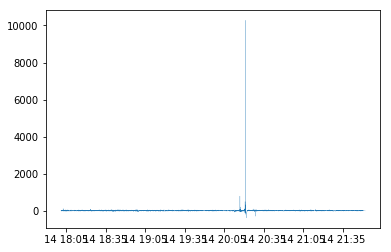

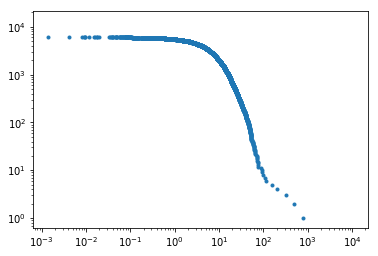

In [18]:
Smin = 40

roll_len = 1*60
roll_type = 'triang'

index = ((image_pyse.runcat == 1) &\
         (image_pyse.freq_eff > 60000000.0)).values 


plt.figure(3)

rolling = image_pyse[index].f_int.rolling(roll_len, win_type=roll_type)



plt.subplot()
plt.plot(image_pyse[index].taustart_ts,
         image_pyse[index].f_int-rolling.mean(), lw=0.2)


f_smooth = (image_pyse[index].f_int-rolling.mean())[np.isfinite(image_pyse[index].f_int-rolling.mean())]

plt.figure()

x = np.sort(f_smooth)
y = np.array((np.array(range(len(f_smooth))[::-1])))


fit, cov = curve_fit(powlaw, x, y, maxfev = 1800)

plt.plot(x,y, ".", label="N: "+str(np.sum(index)))

plt.plot(x,
         powlaw(x, fit[0], fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy s) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( Smin , 
                                                        round(fit[1],2)),zorder=5)

plt.xscale("log")
plt.yscale("log")



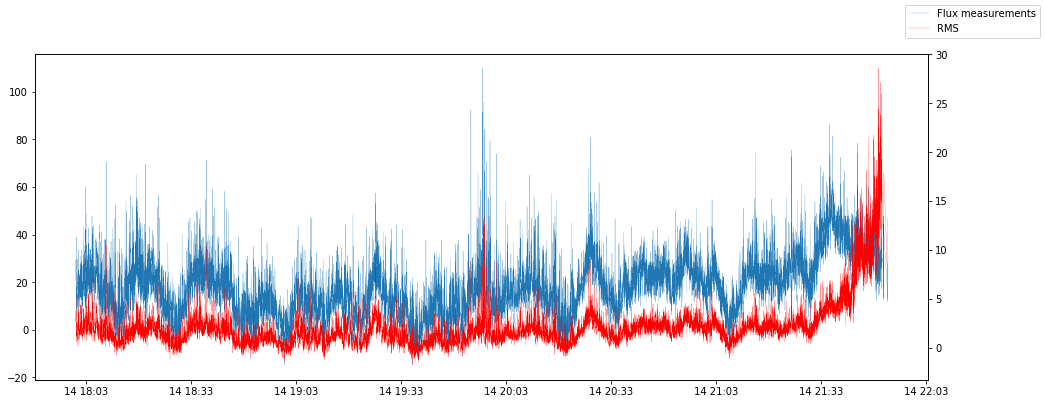

In [22]:
index = ((image_pyse.runcat == 1) &\
         (image_pyse.freq_eff < 60000000.0)).values 

fig = plt.figure(figsize=(16,6))

ax1 = plt.subplot(111)
ax1.plot(image_pyse[index].taustart_ts,
         image_pyse[index].f_int, lw=0.2, label="Flux measurements")
# fig.legend()
ax2 = ax1.twinx()

ax2.plot(image_pyse[index].taustart_ts,
         image_pyse[index].f_int/image_pyse[index].det_sigma, lw=0.2, c="red", label="RMS")

fig.legend()


In [24]:
# select source at frequency
index = ((image_pyse.runcat == 1) &\
         (image_pyse.freq_eff > 60000000.0)& (image_pyse.rms_min < 12)).values 


fint_rolling = image_pyse[index].f_int.rolling(roll_len, win_type=roll_type)
rms_rolling = (image_pyse[index].f_int/image_pyse[index].det_sigma).rolling(roll_len, win_type=roll_type)
# subtract rolling mean from f_int
fint_smooth = (image_pyse[index].f_int-fint_rolling.mean())
rms_smooth = (image_pyse[index].f_int/image_pyse[index].det_sigma)-rms_rolling.mean()



times = image_pyse[index].taustart_ts

Smin = 30

# select complete sample
index = ((5*rms_smooth < Smin )  &\
         (fint_smooth > Smin )).values 

# add rolling mean back to remaining data points
z = (fint_smooth[index])#+fint_rolling.mean()[index])[np.isfinite(fint_smooth[index]+fint_rolling.mean()[index])]

z_time = times[index]

0.651459757259
1.26631366409


/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pandas/core/internals.py:262: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 13692 but corresponding boolean dimension is 27016
  return self.values[slicer]
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pandas/core/indexes/base.py:1754: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 13692 but corresponding boolean dimension is 27016
  result = getitem(key)


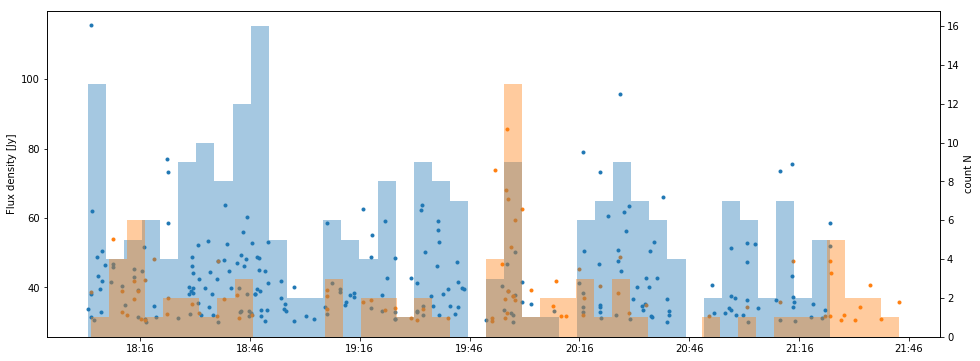

In [25]:
_interval = "5min"
Smin = 30

# select source at frequency
index = ((image_pyse.runcat == 1) &\
         (image_pyse.freq_eff > 60000000.0)& (image_pyse.rms_min < 12)).values 


fint_rolling = image_pyse[index].f_int.rolling(roll_len, win_type=roll_type)

# subtract rolling mean from f_int
fint_smooth = (image_pyse[index].f_int-fint_rolling.mean())

times = image_pyse[index].taustart_ts



# select complete sample
index = ((5*rms_smooth < Smin )  &\
         (fint_smooth > Smin )).values 

# add rolling mean back to remaining data points
z = (fint_smooth[index])#+fint_rolling.mean()[index])[np.isfinite(fint_smooth[index]+fint_rolling.mean()[index])]

z_time = times[index]



fig = plt.figure(figsize=(16,6))

ax1 = plt.subplot(111)
ax1.set_label("hellow")
# complete
index = ( fint_smooth > Smin).values 

ax1.plot(times[index], fint_smooth[index],".", color="C0")
ax1.set_ylabel("Flux density [Jy]")

myFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(myFmt)

# ax1.plot(image_pyse[index].taustart_ts, image_pyse[index].f_int,".",color="C0")

ax2 = ax1.twinx()

ax2.set_ylabel("count N")

n = ax2.hist(times[index], 
             bins=len(pd.date_range(start=np.min(times[index]),
                                    end=np.max(times[index]),
             freq=_interval)), alpha=0.4)
print np.std(n[0])/np.mean(n[0])

######

# select source at frequency
index = ((image_pyse.runcat == 1) &\
         (image_pyse.freq_eff < 60000000.0)& (image_pyse.rms_min < 12)).values 


fint_rolling = image_pyse[index].f_int.rolling(roll_len, win_type=roll_type)

# subtract rolling mean from f_int
fint_smooth = (image_pyse[index].f_int-fint_rolling.mean())

times = image_pyse[index].taustart_ts



# select complete sample
index = ((5*rms_smooth < Smin )  &\
         (fint_smooth > Smin )).values 

# add rolling mean back to remaining data points
z = (fint_smooth[index])#+fint_rolling.mean()[index])[np.isfinite(fint_smooth[index]+fint_rolling.mean()[index])]

z_time = times[index]

# complete
index = ( fint_smooth > Smin).values 

ax1.plot(times[index], fint_smooth[index],".", color="C1")


# ax1.plot(image_pyse[index].taustart_ts, image_pyse[index].f_int,".",color="C0")

ax2.set_ylabel("count N")

n = ax2.hist(times[index], 
             bins=len(pd.date_range(start=np.min(times[index]),
                                    end=np.max(times[index]),
             freq=_interval)), alpha=0.4, color="C1")


myFmt = mdates.DateFormatter('%H:%M')
ax2.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_label("Time UTC [hh:mm]")
# plt.tight_layout()
plt.xlabel("hellow")
print np.std(n[0])/np.mean(n[0])

plt.savefig("/home/kuiack/B0950+08_figs/bgsub_cluster_timeseries.pdf")

180


/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in power
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


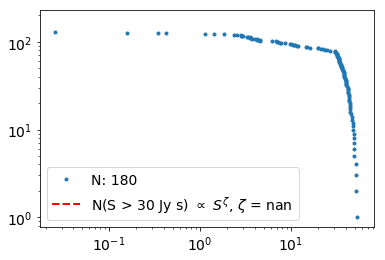

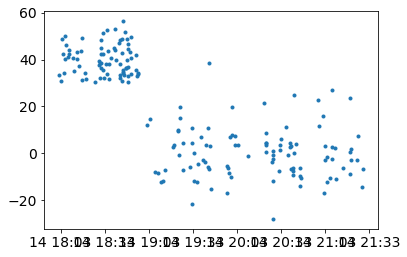

In [68]:
x = np.sort(z)
y = np.array((np.array(range(len(z))[::-1])))


fit, cov = curve_fit(powlaw, x, y, maxfev = 1800)

plt.plot(x,y, ".", label="N: "+str(np.sum(index)))

plt.plot(x,
         powlaw(x, fit[0], fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy s) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( Smin , 
                                                        round(fit[1],2)),zorder=5)
print len(x)
plt.xscale("log")
plt.yscale("log")
plt.legend()


plt.figure()
plt.plot(z_time, z,".")

0.563394494005


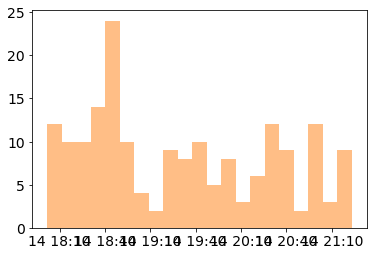

In [34]:

_interval = "10min"

plt.figure()
n = plt.hist(z_time, 
             bins=len(pd.date_range(start=np.min(pd.to_datetime(z_time)),
                                    end=np.max(pd.to_datetime(z_time)),
             freq=_interval)), alpha=0.5, color="C1")

print np.std(n[0])/np.mean(n[0])

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c,d):
    return a * np.exp(-b * (x+d)) + c



(1.0, 65.02185792349727)


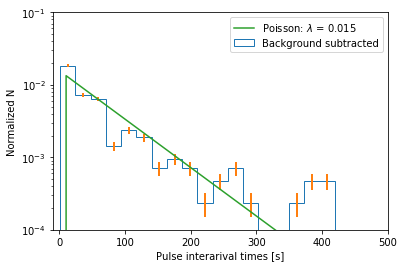

In [26]:
# select source at frequency
index = ((image_pyse.runcat == 1) &\
         (image_pyse.freq_eff > 60000000.0)& (image_pyse.rms_min < 12)).values 


fint_rolling = image_pyse[index].f_int.rolling(roll_len, win_type=roll_type)

# subtract rolling mean from f_int
fint_smooth = (image_pyse[index].f_int-fint_rolling.mean())

times = image_pyse[index].taustart_ts

Smin = 30

# select complete sample
index = ((5*rms_smooth < Smin )  &\
         (fint_smooth > Smin )).values 

# add rolling mean back to remaining data points
z = (fint_smooth[index])#+fint_rolling.mean()[index])[np.isfinite(fint_smooth[index]+fint_rolling.mean()[index])]

z_time = times[index]

X = np.array((z_time.values[1:] - z_time.values[:-1])/1e9, dtype=np.float)

P = ss.expon.fit(X)
print P
n = plt.hist(X, normed=True, bins=30, label="Background subtracted", histtype="step")
mid = 0.5*(n[1][1:] + n[1][:-1])
plt.errorbar(mid, n[0], yerr=np.sqrt(n[0])/len(X), fmt='none',elinewidth=2)

rX = np.linspace(0,1000, 100)
rP = ss.expon.pdf(rX, *P)

# def exponent(x,u,b):
#     return (1./b)*np.exp((-x-u)/b)

# plt.plot(rX,exponent(rX,1,4.))



plt.plot(rX, rP, label="Poisson: "r"$\lambda$"" = {}".format(round(1./P[1],3)))

r = ss.expon.rvs(*P,size=len(X))

# plt.hist(r, normed=True, bins=30, alpha=0.5, label="Poisson")
plt.yscale("log")

# plt.xscale("log")
plt.ylim([1e-4,1e-1])
plt.xlim([-10,500])

plt.ylabel("Normalized N")
plt.xlabel("Pulse interarival times [s]")

plt.legend()

plt.savefig("/home/kuiack/B0950+08_figs/bgsub_cluster_dist.pdf")

Power_divergenceResult(statistic=0.1297936920026885, pvalue=1.0)


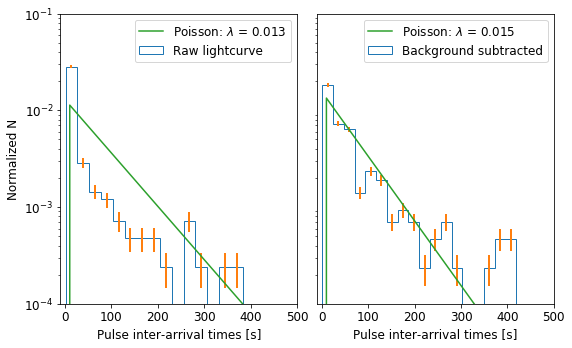

In [43]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12
       }

%matplotlib inline

matplotlib.rc('font', **font)

plt.figure(figsize=(8,5))

plt.subplot(121)

raw_n = plt.hist(raw_X, normed=True, bins=100, histtype="step", label="Raw lightcurve")
raw_mid = 0.5*(raw_n[1][1:] + raw_n[1][:-1])
plt.errorbar(raw_mid, raw_n[0], yerr=np.sqrt(raw_n[0])/len(raw_X), fmt='none',elinewidth=2)



raw_rX = np.linspace(0,1000, 100)
raw_rP = ss.expon.pdf(raw_rX, *raw_P)

plt.plot(raw_rX, raw_rP, label="Poisson: "r"$\lambda$"" = {}".format(round(1./raw_P[1],3)))
plt.yscale("log")
# plt.xscale("log")

print chisquare(n[0], 
          f_exp=ss.expon.pdf(n[1][:-1], *P))

plt.ylim([1e-4,1e-1])
plt.xlim([-10,500])
plt.ylabel("Normalized N")
plt.xlabel("Pulse inter-arrival times [s]")
plt.legend()


plt.subplot(122)
n = plt.hist(X, normed=True, bins=30, label="Background subtracted", histtype="step")
mid = 0.5*(n[1][1:] + n[1][:-1])
plt.errorbar(mid, n[0], yerr=np.sqrt(n[0])/len(X), fmt='none',elinewidth=2)

rX = np.linspace(0,1000, 100)
rP = ss.expon.pdf(rX, *P)

# def exponent(x,u,b):
#     return (1./b)*np.exp((-x-u)/b)

# plt.plot(rX,exponent(rX,1,4.))



plt.plot(rX, rP, label="Poisson: "r"$\lambda$"" = {}".format(round(1./P[1],3)))

r = ss.expon.rvs(*P,size=len(X))

# plt.hist(r, normed=True, bins=30, alpha=0.5, label="Poisson")
plt.yscale("log")

# plt.xscale("log")
plt.ylim([1e-4,1e-1])
plt.xlim([-10,500])
plt.yticks([])
# plt.ylabel("Normalized N")
plt.xlabel("Pulse inter-arrival times [s]")

plt.legend()
plt.tight_layout()

plt.savefig("/home/kuiack/B0950+08_figs/Cluster_dist.pdf")

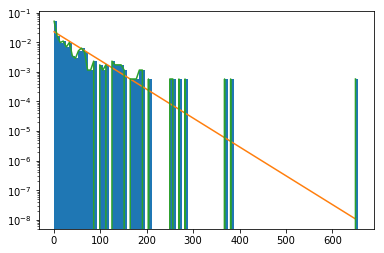

In [306]:
n = plt.hist(X,bins=100, normed=True)

plt.plot(n[1][:-1],ss.expon.pdf(n[1][:-1], *P))
plt.plot(n[1][:-1], n[0])
plt.yscale("log")

In [255]:
print 1./np.mean(X)

print 1./P[1]

0.021942800789
0.0224350894883


(0.0001, 1.0)

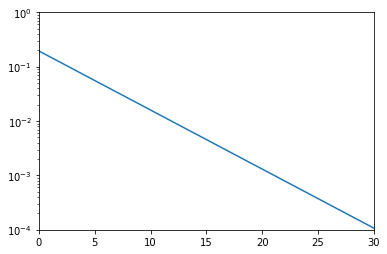

In [252]:
plt.plot(rX,exponent(rX,1,4.))
plt.yscale("log")
plt.xlim([0,30])
plt.ylim([1e-4,1e0])

<IPython.core.display.Javascript object>


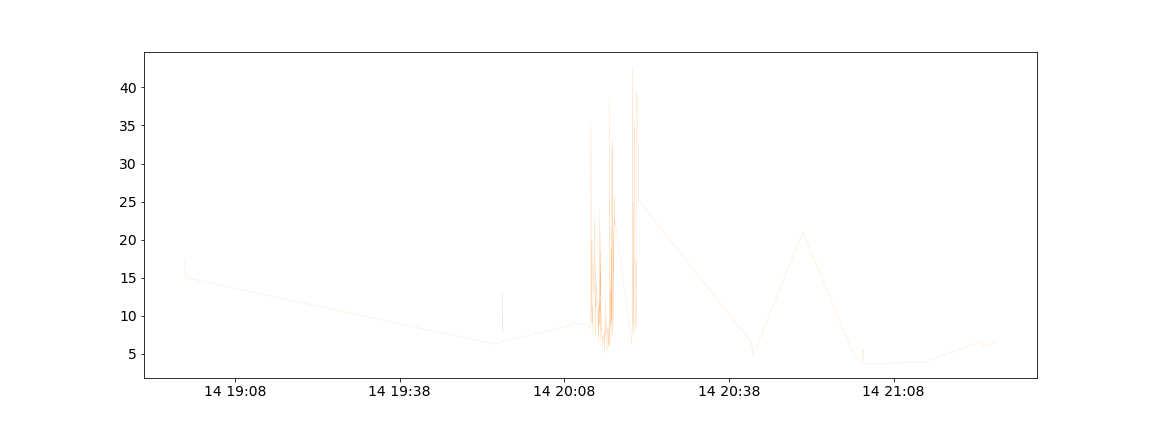

In [115]:
Smin = 45
plt.figure(figsize=(16,6))
index = ((image_pyse.runcat == 111) &\
         (image_pyse.f_int/image_pyse.det_sigma < Smin )  &\
         (image_pyse.f_int > Smin ) &\
         (image_pyse.freq_eff < 60000000.0)).values 

plt.plot(image_pyse[index].taustart_ts, image_pyse[index].f_int/image_pyse[index].det_sigma, lw=.1)


# plt.figure(figsize=(16,6))
index = ((image_pyse.runcat == 111) &\
         (image_pyse.f_int/image_pyse.det_sigma < Smin )  &\
         (image_pyse.f_int > Smin ) &\
         (image_pyse.freq_eff > 60000000.0)).values 

plt.plot(image_pyse[index].taustart_ts, image_pyse[index].f_int/image_pyse[index].det_sigma, lw=.1)





111
10906


/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


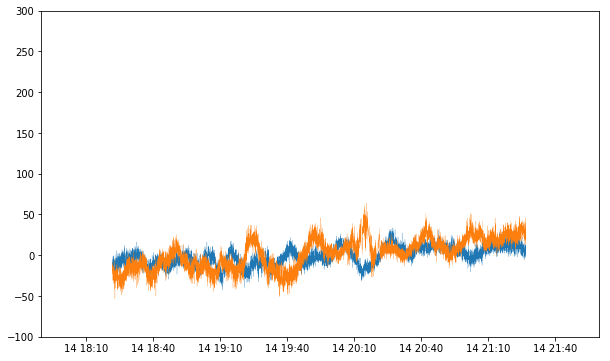

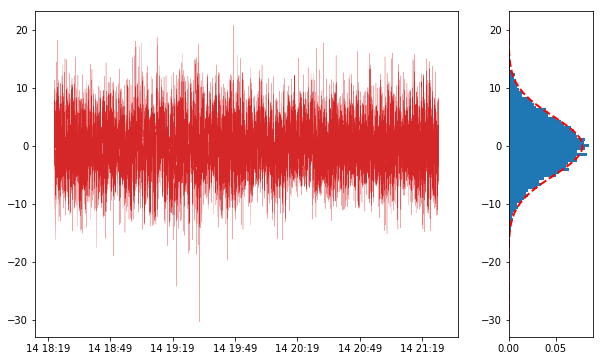

In [111]:
%matplotlib inline

from scipy.stats import norm
from scipy.stats import halfnorm
import matplotlib.mlab as mlab
from matplotlib import gridspec

roll_len = 1*30
roll_type = 'boxcar'


for i in [111]:
    print i
    plt.figure(figsize=(10,6))
    bool_index = (image_pyse.runcat == i) &\
                        (image_pyse.freq_eff < 60000000) &\
                        (image_pyse.rms_min < 12)
    
    plt.plot(image_pyse[bool_index].taustart_ts,
             image_pyse[bool_index].f_int, lw=0.2)
    
    print len(image_pyse[bool_index].f_int)
    
    plt.xlim([datetime.datetime(2018, 4, 14,18,3), 
          datetime.datetime(2018, 4, 14, 22,0)])
    
    
    bool_index = (image_pyse.runcat == i) &\
                        (image_pyse.freq_eff > 60000000) &\
                        (image_pyse.rms_min < 12)
    
            
    plt.plot(image_pyse[bool_index].taustart_ts,
             image_pyse[bool_index].f_int, lw=0.2)
    
    plt.xlim([datetime.datetime(2018, 4, 14, 17, 50), 
          datetime.datetime(2018, 4, 14, 22, 0)])
    
    plt.ylim([-100,300])

    

    plt.figure(2,figsize=(10,6))

    gs = gridspec.GridSpec(1, 2, width_ratios=[5,1])

    bool_index = (image_pyse.runcat == i) &\
                        (image_pyse.freq_eff < 60000000) &\
                        (image_pyse.rms_min < 12)

    rolling = image_pyse[bool_index].f_int.rolling(roll_len, win_type=roll_type)

    plt.subplot(gs[0])
    plt.plot(image_pyse[bool_index].taustart_ts,
             image_pyse[bool_index].f_int-rolling.mean(), c="C3", lw=0.2)
#     plt.plot(image_pyse[bool_index].taustart_ts,
#              image_pyse[bool_index].f_int  , lw=0.2)

    plt.subplot(gs[1])
    hist_dat = image_pyse[bool_index].f_int-rolling.mean()
#     hist_dat = image_pyse[bool_index].f_int
    
    n, bins, patches = plt.hist(hist_dat[np.isfinite(hist_dat)], 
                                orientation="horizontal", bins=100, normed=1)

#     (mu, sigma) = norm.fit(hist_dat[np.isfinite(hist_dat)])

    (mu, sigma) = halfnorm.fit(np.abs(hist_dat[np.isfinite(hist_dat) & (hist_dat < 0)]))
#     (mu, sigma) = halfnorm.fit(np.abs(hist_dat[np.isfinite(hist_dat)]))

    y = mlab.normpdf(bins, -mu, sigma)
    l = plt.plot(y, bins,'r--', linewidth=2)
    
    

    
#     plt.figure(figsize=(10,6))
#     (mu, sigma) = halfnorm.fit(np.abs(hist_dat[np.isfinite(hist_dat) & (hist_dat < 0)]))
#     n, bins, patches = plt.hist(np.abs(hist_dat[np.isfinite(hist_dat) & (hist_dat < 0)]), 
#                             orientation="horizontal", bins=30, normed=1)
#     print (mu, sigma)
#     # y = mlab.normpdf( bins, mu, sigma)
#     # l = plt.plot(y,bins,'r--', linewidth=2)

#     plt.plot(halfnorm.pdf(bins, loc=mu, scale=sigma), bins, 'k-', lw=2, label='frozen pdf')


    
    plt.show()


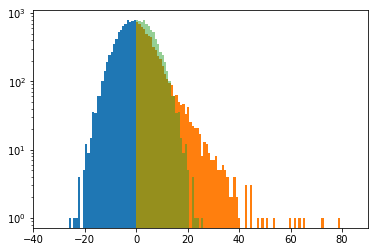

In [13]:
plt.figure()
n, bins, patches = plt.hist(hist_dat[np.isfinite(hist_dat) & (hist_dat < 0)], 
                            bins=100,range=[-90,0])


pulse_n, bins, patches = plt.hist(hist_dat[np.isfinite(hist_dat) & (hist_dat > 0)], 
                            bins=100, range=[0,90], log=True)

mirror_n, bins, patches = plt.hist(np.abs(hist_dat[np.isfinite(hist_dat) & (hist_dat < 0)]), 
                            bins=100, range=[0,90], alpha=0.5)
plt.xlim([-40,90])
plt.show()

In [14]:
n_vals = pulse_n-mirror_n

data = np.array([]) 

for i in range(len(bins)-1):
    
    if not n_vals[i] > 0:
        continue
    
    bool_index = (image_pyse.runcat == i) &\
                    (image_pyse.freq_eff < 60000000) &\
                    (image_pyse.rms_min < 12) &\
                    (image_pyse.f_int > bins[i]) & (image_pyse.f_int < bins[i+1])
                            
#     print  44+bins[i], 44+bins[i+1]
    
    
    try:
        data = np.append(data,np.random.choice(hist_dat[(hist_dat > bins[i]) & (hist_dat < bins[i+1])].index, size=n_vals[i]))
    except ValueError:

        print n_vals[i], 26+bins[i], 26+bins[i+1]

/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


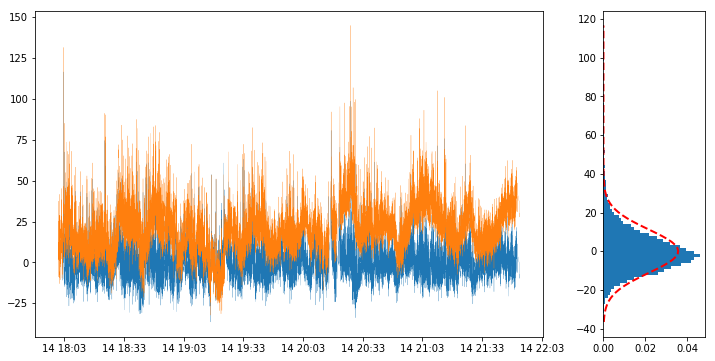

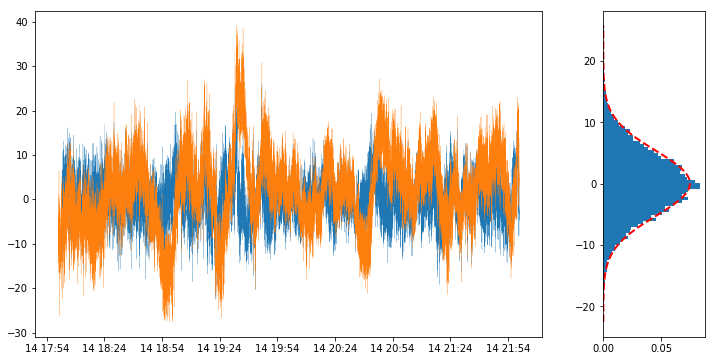

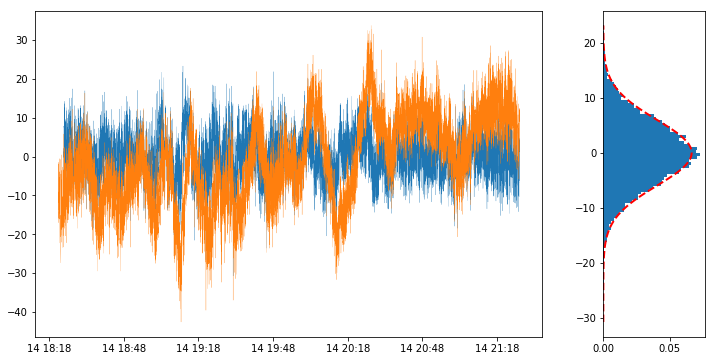

In [7]:
# rolling = source_df.f_int.rolling(roll_len, win_type=roll_type)
# source_df.f_int = source_df.f_int-rolling.mean()
from scipy.stats import norm
import matplotlib.mlab as mlab
from matplotlib import gridspec

roll_len = 2*60
roll_type = 'boxcar'

i = 1
plt.figure(figsize=(12,6))

gs = gridspec.GridSpec(1, 2, width_ratios=[5,1])

bool_index = (image_pyse.runcat == i) &\
                    (image_pyse.freq_eff > 60000000) &\
                    (image_pyse.rms_min < 12)

rolling = image_pyse[bool_index].f_int.rolling(roll_len, win_type=roll_type)
  
plt.subplot(gs[0])
plt.plot(image_pyse[bool_index].taustart_ts,
         image_pyse[bool_index].f_int-rolling.mean()  , lw=0.2)

plt.plot(image_pyse[bool_index].taustart_ts,
         image_pyse[bool_index].f_int  , lw=0.2)

plt.subplot(gs[1])
hist_dat = image_pyse[bool_index].f_int-rolling.mean()

n, bins, patches = plt.hist(hist_dat[np.isfinite(hist_dat)], 
                            orientation="horizontal", bins=100, normed=1)

(mu, sigma) = norm.fit(hist_dat[np.isfinite(hist_dat)],)
 
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(y,bins,'r--', linewidth=2)


i = 2
plt.figure(figsize=(12,6))

gs = gridspec.GridSpec(1, 2, width_ratios=[5,1])

bool_index = (image_pyse.runcat == i) &\
                    (image_pyse.freq_eff < 60000000) &\
                    (image_pyse.rms_min < 12)

rolling = image_pyse[bool_index].f_int.rolling(roll_len, win_type=roll_type)
  
plt.subplot(gs[0])
plt.plot(image_pyse[bool_index].taustart_ts,
         image_pyse[bool_index].f_int-rolling.mean()  , lw=0.2)

plt.plot(image_pyse[bool_index].taustart_ts,
         image_pyse[bool_index].f_int  , lw=0.2)

plt.subplot(gs[1])
hist_dat = image_pyse[bool_index].f_int-rolling.mean()

n, bins, patches = plt.hist(hist_dat[np.isfinite(hist_dat)], 
                            orientation="horizontal", bins=100, normed=1)

(mu, sigma) = norm.fit(hist_dat[np.isfinite(hist_dat)],)
 
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(y,bins,'r--', linewidth=2)


i = 111
plt.figure(figsize=(12,6))

gs = gridspec.GridSpec(1, 2, width_ratios=[5,1])

bool_index = (image_pyse.runcat == i) &\
                    (image_pyse.freq_eff < 60000000) &\
                    (image_pyse.rms_min < 12)

rolling = image_pyse[bool_index].f_int.rolling(roll_len, win_type=roll_type)
  
plt.subplot(gs[0])
plt.plot(image_pyse[bool_index].taustart_ts,
         image_pyse[bool_index].f_int-rolling.mean()  , lw=0.2)

plt.plot(image_pyse[bool_index].taustart_ts,
         image_pyse[bool_index].f_int  , lw=0.2)

plt.subplot(gs[1])
hist_dat = image_pyse[bool_index].f_int-rolling.mean()

n, bins, patches = plt.hist(hist_dat[np.isfinite(hist_dat)], 
                            orientation="horizontal", bins=100, normed=1)

(mu, sigma) = norm.fit(hist_dat[np.isfinite(hist_dat)],)
 
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(y,bins,'r--', linewidth=2)

# plt.xlim([datetime.datetime(2018, 4, 14,18,3), 
#       datetime.datetime(2018, 4, 14, 22,0)])


# bool_index = (image_pyse.runcat == i) &\
#                     (image_pyse.freq_eff > 60000000) &\
#                     (image_pyse.rms_min < 12)


# plt.plot(image_pyse[bool_index].taustart_ts,
#          image_pyse[bool_index].f_int, lw=0.2)

# plt.xlim([datetime.datetime(2018, 4, 14, 17, 50), 
#       datetime.datetime(2018, 4, 14, 22, 0)])

In [5]:
t1 = time.time()
dbname = "AS_PSR_20180414"
dataset = 1

logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                 user=user, password=password, database=dbname)

db.connect()
session = db.Session()

transients_query = """SELECT ex.f_int, 
ex.f_int_err, ex.det_sigma,ex.chisq,ex.reduced_chisq, 
ex.ra, 
ex.decl, 
ax.runcat,
im.taustart_ts, im.freq_eff, im.rms_min, im.rms_max  
            FROM extractedsource ex, assocxtrsource ax, image im
            WHERE ax.xtrsrc = ex.id 
            AND ex.image = im.id; 
"""

#  Takes a long time when runningcatalog is included in the FROM, 

# transients_query = """SELECT ex.f_int, 
# ex.f_int_err, ex.det_sigma,ex.chisq,ex.reduced_chisq, 
# ex.ra, 
# ex.decl, 
# ax.runcat,
# im.taustart_ts, im.freq_eff, im.rms_min, im.rms_max  
#             FROM extractedsource ex, assocxtrsource ax, image im, runningcatalog rc
#             WHERE ax.xtrsrc = ex.id 
#             AND ex.image = im.id
#             AND rc.wm_ra >= 143. 
#             AND rc.wm_ra <= 153. 
#             AND rc.wm_decl >= 3. 
#             AND rc.wm_decl <= 12. ; 
# """


image_pyse = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

db._configured = False
del db, session

print "time:", time.time() - t1

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
No handlers could be found for logger "tkp.db.database"


time: 126.83615303


In [75]:
image_pyse = image_pyse.dropna()

/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:41: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


2 [  6.24011453e-08  -6.88967565e+00] [ 0.09000368]
4 [  2.13898526e-08  -7.26699502e+00] [ 0.08801804]
103 [  6.53066827e-08  -6.95577956e+00] [ 0.09269151]
111 [  1.29213212e-07  -6.73345225e+00] [ 0.0948298]
114 [  3.53382544e-07  -6.04026822e+00] [ 0.08548228]
1 [  1.07386150e-04  -4.10156244e+00] [ 0.10772274]
max: 3949.95252143 218.629872061 min 839.960980954


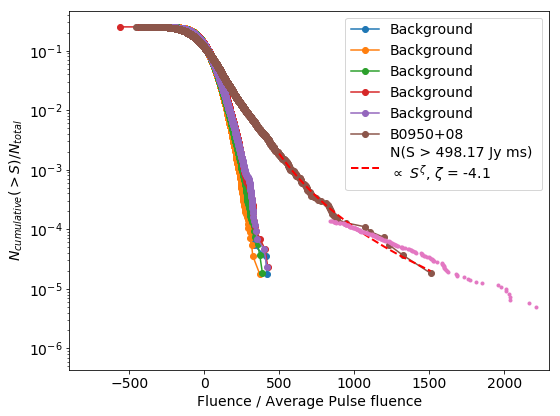

In [47]:
import scipy.optimize as so


def min_powlaw(x,a,b,c):
    return np.abs(a*x**b - c)

def powlaw(x,a,b):
    return a*x**b



font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14
       }

%matplotlib inline

matplotlib.rc('font', **font)

from matplotlib.ticker import ScalarFormatter

x_s = []
y_s = [] 


roll_len = 1*60
roll_type = 'boxcar'

i = 1
# plt.figure(1)
fig1, ax1 = plt.subplots(figsize=(8,6))

for i in [2, 4,103, 111,114,1]:

    bool_index = (image_pyse.runcat == i) &\
                            (image_pyse.freq_eff < 60000000) & (image_pyse.rms_min < 12)


    _source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                      end=np.max(image_pyse[bool_index].taustart_ts),
                      freq="1S")]
    
    _source_data = _source_data.dropna()
    
    
    
    rolling = _source_data.f_int.rolling(roll_len, win_type=roll_type)
  


    flux = _source_data.f_int -rolling.mean().values#- np.median(_source_data.f_int) #-rolling.mean().values
    flux = flux[np.isfinite(flux)]
    x = np.sort((flux) *1000.)/55.35

    
    x_s.append(x)
    

    y = np.array((1.+np.array(range(len(x))[::-1])))/(4.*len((x)))
    y_s.append(y)
    
    flux_limit = x[-100]#  40000/55.35
    fit, cov = curve_fit(powlaw, x[(x > flux_limit)]/1000., y[(x > flux_limit)])

#     fit, cov = curve_fit(powlaw, x[(x > flux_limit)], y[(x > flux_limit)])

#     print fit
    if i == 1:
        ax1.plot(x,y,"o-",  label="B0950+08")
    else:
        ax1.plot(x,y,"o-", label="Background")
        
        
    if i == 1:
        ax1.plot(x[(x > flux_limit)],
                 powlaw(x[(x > flux_limit)]/1000.,fit[0],fit[1]), "--", c="r",lw =2, 
                 label="N(S > {} Jy ms) \n"r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                                round(fit[1],2), 
                                                                flux_limit))


#     ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_ylabel(r"$N_{cumulative}( > S)/N_{total}$")
    ax1.set_xlabel("Fluence / Average Pulse fluence")
#     ax1.set_xlim([-1.5e3,3e5])
    # ax1.set_ylim([1e-6,0.1])

    # ax1.set_xticks([50,80,100, 120,140] )

    # for axis in [ax1.xaxis, ax1.yaxis]:
    #     axis.set_major_formatter(ScalarFormatter())
    ax1.xaxis.set_major_formatter(ScalarFormatter())

#     ax1.plot(x[(x > flux_limit)],
#              powlaw(x[(x > flux_limit)]/1000.,fit[0],fit[1]), "--", c="r",lw =2, 
#              label="N(S > {} Jy ms) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
#                                                             round(fit[1],2), 
#                                                             flux_limit))




    s_root = so.root(min_powlaw, 0.1, args = (fit[0], fit[1], 1.0) )

    print i, fit, s_root["x"]
#     ax1.plot(x[(x > 0.15875389*1000)],
#              powlaw(x[(x > 0.15875389*1000)]/1000,fit[0],fit[1]), "--", c="r",lw =2, 
#              label="N(S > {} Jy ms) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
#                                                             round(fit[1],2), 
#                                                             flux_limit))


#     ax1.plot(x[(x > 1000)],
#              powlaw(x[(x > 1000)],fit[0],fit[1]), "--", c="r",lw =2, 
#              label="N(S > {} Jy ms) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
#                                                             round(fit[1],2), 
#                                                             flux_limit))


    # ax1.plot(np.logspace(1,1.5)/2., powlaw(np.logspace(1,1.5),13., -4.09), "--", 
    #          label="74 MHz, Tsai et al. 2016, "r"$\zeta$ = -5.06"  )



    # ax1.plot(np.logspace(1,1.5)/2., powlaw(np.logspace(1,1.5),137., -5.06),"--", 
    #          label="42 MHz, Tsai et al. 2016, "r"$\zeta$ = -4.09")


#     ax1.legend()
    plt.tight_layout()


# bool_index = (image_pyse.runcat == 1) &\
#                         (image_pyse.freq_eff > 60000000) &\
#                         (image_pyse.rms_min < 12)
        
        
# x = (np.sort(image_pyse.iloc[data].f_int) *1000.)/55.35

# #     x = (np.sort(image_pyse[bool_index].f_int.values) *1000.)/55.35

# print "max:", np.max(x), "min", np.min(x)



# len_bool_index = (image_pyse.runcat == 1) &\
#                         (image_pyse.freq_eff > 60000000) &\
#                         (image_pyse.rms_min < 12)


# y = np.array((np.array(range(len(image_pyse.iloc[data].f_int))[::-1])))/(4.*len(image_pyse[len_bool_index].taustart_ts))


# #     y = np.array((np.array(range(len(image_pyse[bool_index].f_int.values))[::-1])))/(4.*len(image_pyse[bool_index].taustart_ts))

# # 
# # flux_limit = 0#  40000/55.35
# flux_limit = x[-100]#

# fit, cov = curve_fit(powlaw, x[(x > flux_limit)]/1000., y[(x > flux_limit)])

# print fit



# ax1.plot(x,y, ".", label="60 MHz, PSR B0950+08, ID {}".format(i))

# ax1.set_xscale("log")
# ax1.set_yscale("log")
# ax1.set_ylabel(r"$N_{cumulative}( > S)/N_{total}$")
# ax1.set_xlabel("Fluence / Average Pulse fluence")

# ax1.set_ylim([1e-6,1])

# # ax1.set_xticks([50,80,100, 120,140] )

# # for axis in [ax1.xaxis, ax1.yaxis]:
# #     axis.set_major_formatter(ScalarFormatter())
# ax1.xaxis.set_major_formatter(ScalarFormatter())

# ax1.plot(x[(x > flux_limit)],
#          powlaw(x[(x > flux_limit)]/1000.,fit[0],fit[1]), "--", c="r",lw =2, 
#          label="N(S > {} Jy ms) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
#                                                         round(fit[1],2), 
#                                                         flux_limit))


# # ax1.plot(np.logspace(1,1.5)/2., powlaw(np.logspace(1,1.5),13., -4.09), "--", 
# #          label="74 MHz, Tsai et al. 2016, "r"$\zeta$ = -5.06"  )



# # ax1.plot(np.logspace(1,1.5)/2., powlaw(np.logspace(1,1.5),137., -5.06),"--", 
# #          label="42 MHz, Tsai et al. 2016, "r"$\zeta$ = -4.09")


# ax1.set_ylim([1e-5,2])
ax1.set_xlim([-900,2300])
ax1.legend(loc="upper right")
plt.tight_layout()

x = (np.sort(all_GP[(all_GP.freq_eff > 60000000) ].f_int) *1000.)/55.35
print "max:", np.max(x),np.max(x)/1000.*55.35, "min", np.min(x)

y = np.array((np.array(range(len(x))[::-1])))/(4.*concat_R.n_images.sum())

plt.plot(x,y,".")



# plt.savefig("/home/kuiack/B0950+08_figs/monitor_bgsub.pdf")
plt.show()

/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:29: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:74: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:151: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.htm

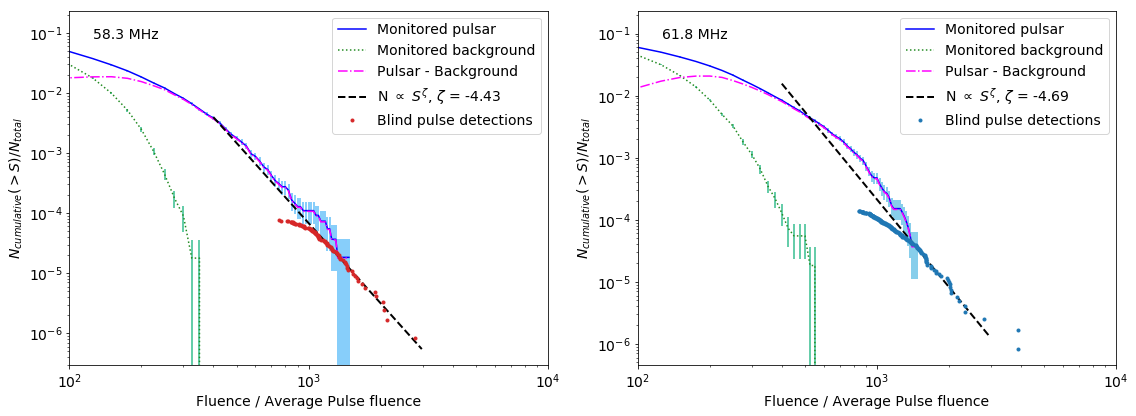

In [59]:
plt.rcParams['axes.facecolor'] = 'white'
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14
       }
matplotlib.rc('font', **font)

roll_len =1*60
roll_type = "boxcar"

xmin = 0
xmax = 1500
stepsize = 25

flux_limit = 600#  40000/55.35


plt.figure(1, figsize=(16,6))
ax  = plt.subplot(121)
# plt.title("58.3 MHz")

i = 1 
# for i in [2, 4,103, 111,114,1]:
bool_index = (image_pyse.runcat == i) &\
                        (image_pyse.freq_eff < 60000000) & (image_pyse.rms_min < 12)


_source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                  end=np.max(image_pyse[bool_index].taustart_ts),
                  freq="1S")]

_source_data = _source_data.dropna()



rolling = _source_data.f_int.rolling(roll_len, win_type=roll_type)



flux = _source_data.f_int -rolling.mean().values#- np.median(_source_data.f_int) #-rolling.mean().values
flux = flux[np.isfinite(flux)]
x = np.sort((flux) *1000.)/55.35

y_1 = np.array([np.sum(x > level)  for level in np.arange(xmin,xmax,stepsize)])

plt.plot(np.arange(xmin,xmax,stepsize),y_1/(4.*len(x)),c="blue", label="Monitored pulsar")
plt.errorbar(np.arange(xmin,xmax,stepsize), y_1/(4.*len(x)), 
             yerr=np.sqrt(y_1)/(4.*len(x)), 
             fmt='none',ecolor="lightskyblue",elinewidth=2)


_x = np.arange(xmin,xmax,stepsize)

flux_limit = 600#  40000/55.35
fit, cov = curve_fit(powlaw, _x[(_x > flux_limit)]/1000., y_1[(_x > flux_limit)]/(4.*len(x)))

#     fit, cov = curve_fit(powlaw, x[(x > flux_limit)], y[(x > flux_limit)])

_x = np.arange(400,3000,stepsize)

# [  2.11627147e-04  -4.69027699e+00]
# max: 3209.32364594 177.636063803 min 755.044585279
# [  6.83010428e-05  -4.43094562e+00]




i = 4

bool_index = (image_pyse.runcat == i) &\
                        (image_pyse.freq_eff < 60000000) & (image_pyse.rms_min < 12)


_source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                  end=np.max(image_pyse[bool_index].taustart_ts),
                  freq="1S")]

_source_data = _source_data.dropna()



rolling = _source_data.f_int.rolling(roll_len, win_type=roll_type)



flux = _source_data.f_int -rolling.mean().values#- np.median(_source_data.f_int) #-rolling.mean().values
flux = flux[np.isfinite(flux)]
x = np.sort((flux) *1000.)/55.35

y_103 = np.array([np.sum(x > level)  for level in np.arange(xmin,xmax,stepsize)])

plt.plot(np.arange(xmin,xmax,stepsize),y_103/(4.*len(x)),":", color="forestgreen", label="Monitored background")
plt.errorbar(np.arange(xmin,xmax,stepsize), y_103/(4.*len(x)), 
             yerr=np.sqrt(y_103)/(4.*len(x)), 
             fmt='none',ecolor="mediumaquamarine",elinewidth=2)


xB = (np.sort(all_GP[(all_GP.freq_eff < 60000000) ].f_int) *1000.)/55.35


yB = np.array((np.array(range(len(xB))[::-1])))/(4.*concat_R.n_images.sum())




plt.ylabel(r"$N_{cumulative}( > S)/N_{total}$")
plt.xlabel("Fluence / Average Pulse fluence")
plt.xlim([100,10000])
# plt.ylim([1e-7,0.1])

# plt.figure()
# plt.title("58.3 MHz")
plt.plot(np.arange(xmin,xmax,stepsize), 
         np.array(y_1)/(4.*len(x))-np.array(y_103)/(4.*len(x)),
         "-.",color="magenta", label="Pulsar - Background")
# plt.errorbar(np.arange(xmin,xmax,stepsize), np.array(y_1)/(4.*len(x))-np.array(y_103)/(4.*len(x)), 
#              yerr=np.sqrt(np.array(y_1)-np.array(y_103))/(4.*len(x)), 
#              fmt='none',elinewidth=2)

plt.plot(_x,
         powlaw(_x/1000.,6.83010428e-05,-4.43094562e+00), "--", c="k",lw =2, 
         label="N "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( 
                                                        round(-4.43,2), 
                                                            flux_limit))

plt.plot(xB,yB,".", c="C3",label="Blind pulse detections")


# plt.step(np.arange(xmin,xmax,stepsize), np.array(y_1)-np.array(y_103),)
# plt.errorbar(np.arange(xmin,xmax,stepsize)-stepsize/2., np.array(y_1)-np.array(y_103), 
#              yerr=np.sqrt(np.array(y_1)-np.array(y_103)), 
#              fmt='none',elinewidth=2)

plt.xscale("log")
plt.yscale("log")
plt.legend()
# plt.xlim(100,2000)
plt.text(0.05, 0.95, "58.3 MHz", transform=ax.transAxes, ha='left', va="top")


plt.figure(1, figsize=(16,8))

ax1 = plt.subplot(122)
# plt.title("61.8 MHz")

i = 1 
# for i in [2, 4,103, 111,114,1]:
bool_index = (image_pyse.runcat == i) &\
                        (image_pyse.freq_eff > 60000000) & (image_pyse.rms_min < 12)


_source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                  end=np.max(image_pyse[bool_index].taustart_ts),
                  freq="1S")]

_source_data = _source_data.dropna()



rolling = _source_data.f_int.rolling(roll_len, win_type=roll_type)



flux = _source_data.f_int - rolling.mean().values#- np.median(_source_data.f_int) #-rolling.mean().values
flux = flux[np.isfinite(flux)]
x = np.sort((flux) *1000.)/55.35

y_1 = np.array([np.sum(x > level)  for level in np.arange(xmin,xmax,stepsize)])

plt.plot(np.arange(xmin,xmax,stepsize),y_1/(4.*len(x)),c="blue", label="Monitored pulsar")
plt.errorbar(np.arange(xmin,xmax,stepsize), y_1/(4.*len(x)), 
             yerr=np.sqrt(y_1)/(4.*len(x)), 
             fmt='none',ecolor="skyblue",elinewidth=2)

# plt.step(np.arange(xmin,xmax,stepsize),y_1/(4.*len(x)))
# plt.errorbar(np.arange(xmin,xmax,stepsize)-stepsize/2., y_1/(4.*len(x)), 
#              yerr=np.sqrt(y_1)/(4.*len(x)), 
#              fmt='none',elinewidth=2)


_x = np.arange(xmin,xmax,stepsize)


fit, cov = curve_fit(powlaw, _x[(_x > flux_limit)]/1000., y_1[(_x > flux_limit)]/(4.*len(x)))

#     fit, cov = curve_fit(powlaw, x[(x > flux_limit)], y[(x > flux_limit)])

# [  2.11627147e-04  -4.69027699e+00]
# max: 3209.32364594 177.636063803 min 755.044585279
# [  6.83010428e-05  -4.43094562e+00]

i = 4

bool_index = (image_pyse.runcat == i) &\
                        (image_pyse.freq_eff > 60000000) & (image_pyse.rms_min < 12)


_source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                  end=np.max(image_pyse[bool_index].taustart_ts),
                  freq="1S")]

_source_data = _source_data.dropna()



rolling = _source_data.f_int.rolling(roll_len, win_type=roll_type)



flux = _source_data.f_int -rolling.mean().values#- np.median(_source_data.f_int) #-rolling.mean().values
flux = flux[np.isfinite(flux)]
x = np.sort((flux) *1000.)/55.35

y_103 = np.array([np.sum(x > level)  for level in np.arange(xmin,xmax,stepsize)])

plt.plot(np.arange(xmin,xmax,stepsize),y_103/(4.*len(x)),":", color="forestgreen", label="Monitored background")
plt.errorbar(np.arange(xmin,xmax,stepsize), y_103/(4.*len(x)), 
             yerr=np.sqrt(y_103)/(4.*len(x)), 
             fmt='none',ecolor="mediumaquamarine",elinewidth=2)

# plt.step(np.arange(xmin,xmax,stepsize),y_103/(4.*len(x)))
# plt.errorbar(np.arange(xmin,xmax,stepsize)-stepsize/2., y_103/(4.*len(x)), 
#              yerr=np.sqrt(y_103)/(4.*len(x)), 
#              fmt='none',elinewidth=2)


xB = (np.sort(all_GP[(all_GP.freq_eff > 60000000) ].f_int) *1000.)/55.35


yB = np.array((np.array(range(len(xB))[::-1])))/(4.*concat_R.n_images.sum())

_x = np.arange(400,3000,stepsize)





plt.ylabel(r"$N_{cumulative}( > S)/N_{total}$")
plt.xlabel("Fluence / Average Pulse fluence")
plt.xlim([100,10000])
# plt.ylim([1e-7,0.1])


# plt.figure()
# plt.title("61.8 MHz")
plt.plot(np.arange(xmin,xmax,stepsize), 
         np.array(y_1)/(4.*len(x))-np.array(y_103)/(4.*len(x)),
         "-.",color="magenta", label="Pulsar - Background")
# plt.errorbar(np.arange(xmin,xmax,stepsize), np.array(y_1)/(4.*len(x))-np.array(y_103)/(4.*len(x)), 
#              yerr=np.sqrt(np.array(y_1)-np.array(y_103))/(4.*len(x)), 
#              fmt='none',elinewidth=2)

plt.plot(_x,
         powlaw(_x/1000., 2.11627147e-04 ,-4.69027699e+00), "--", c="k",lw =2, 
         label="N "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( 
                                                        round(-4.69,2), 
                                                        flux_limit))


plt.plot(xB,yB,".", c="C0",label="Blind pulse detections")



plt.xscale("log")
plt.yscale("log")

plt.legend()

plt.text(0.05, 0.95, "61.8 MHz", transform=ax1.transAxes, ha='left', va="top")
plt.tight_layout()
# plt.xlim(100,3000)
plt.savefig("/home/kuiack/B0950+08_figs/GP-monitor_dist_compare.pdf")



/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


<ErrorbarContainer object of 3 artists>

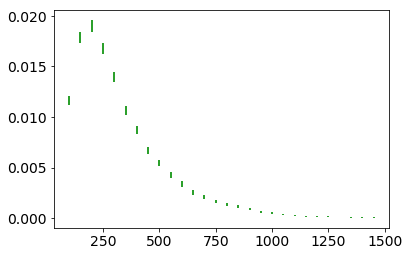

In [27]:
plt.errorbar(np.arange(xmin,xmax,stepsize), np.array(y_1)/(4.*len(x))-np.array(y_103)/(4.*len(x)), 
             yerr=np.sqrt(np.array(y_1)-np.array(y_103))/(4.*len(x)), 
             fmt='none',ecolor="C2",elinewidth=2)


In [59]:
len(x[(x > flux_limit)]/1000.), len(y_1[(x > flux_limit)])

(19, 19)

In [49]:
4.*len(x)

672.0

In [179]:
0.15875389/1000.

0.00015875389

In [131]:
print powlaw(2.6440934, 137., -5.06 )
print powlaw(1.87222391, 13., -4.09, )

powlaw(0.15875389, 4.75746718e-04, -4.15704436e+00)

0.999999997879
1.00000000539


1.0000000616461755

In [132]:
np.log10(0.15875389)

-0.7992756242417417

/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:30: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


20.2683990711
20.2683990711
18.1200546661


/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:67: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


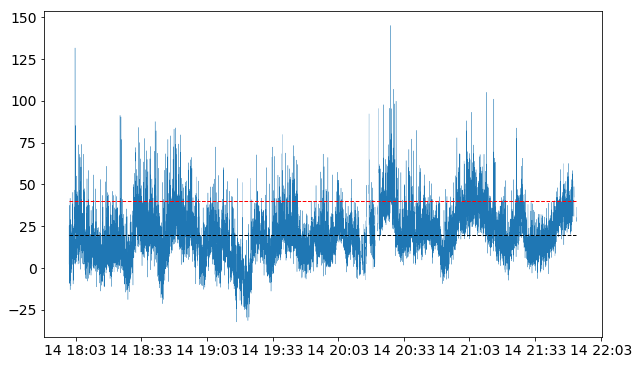

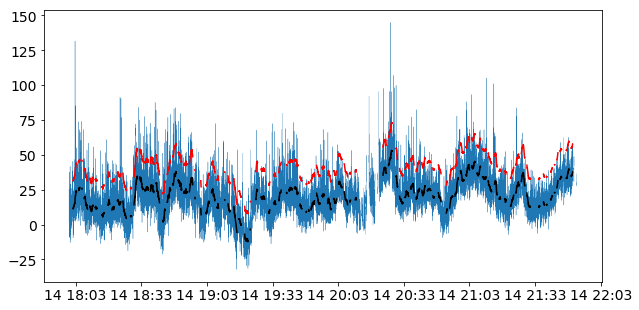

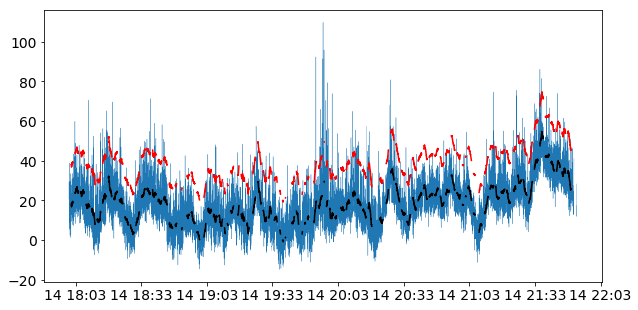

In [108]:
plt.figure(figsize=(10,6))

bool_index = (image_pyse.runcat == 1) &\
                        (image_pyse.freq_eff > 60000000) & (image_pyse.rms_min < 12)

_source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                  end=np.max(image_pyse[bool_index].taustart_ts),
                  freq="1S")]




plt.plot(_source_data.index, _source_data.f_int, lw=0.3)


plt.plot([_source_data.index[0],_source_data.index[-1]],
        [40.0,40.0], "--",c="r", lw=1)
plt.plot([_source_data.index[0],_source_data.index[-1]],
        [20.0,20.0], "--",c="k", lw=1)

print np.mean(_source_data.f_int)



plt.figure(figsize=(10,5))

bool_index = (image_pyse.runcat == 1) &\
                        (image_pyse.freq_eff > 60000000) & (image_pyse.rms_min < 12)

_source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                  end=np.max(image_pyse[bool_index].taustart_ts),
                  freq="1S")]





plt.plot(_source_data.index, _source_data.f_int, lw=0.3)


rolling = _source_data.f_int.rolling(roll_len, win_type=roll_type)

    
# flux = _source_data.f_int-rolling.mean().values
# flux = flux[np.isfinite(flux)]



plt.plot(_source_data.index, rolling.mean().values+20.,c="r")



plt.plot(_source_data.index, rolling.mean().values, c="k")

# plt.plot([_source_data.index[0],_source_data.index[-1]],
#         [40.0,40.0], "--")
# plt.plot([_source_data.index[0],_source_data.index[-1]],
#         [20.0,20.0], "--")

print np.mean(_source_data.f_int)


plt.figure(figsize=(10,5))

bool_index = (image_pyse.runcat == 1) &\
                        (image_pyse.freq_eff < 60000000) & (image_pyse.rms_min < 12)

_source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                  end=np.max(image_pyse[bool_index].taustart_ts),
                  freq="1S")]





plt.plot(_source_data.index, _source_data.f_int, lw=0.3)


rolling = _source_data.f_int.rolling(roll_len, win_type=roll_type)

    
# flux = _source_data.f_int-rolling.mean().values
# flux = flux[np.isfinite(flux)]



plt.plot(_source_data.index, rolling.mean().values+20.,c="r")



plt.plot(_source_data.index, rolling.mean().values, c="k")

# plt.plot([_source_data.index[0],_source_data.index[-1]],
#         [40.0,40.0], "--")
# plt.plot([_source_data.index[0],_source_data.index[-1]],
#         [20.0,20.0], "--")

print np.mean(_source_data.f_int)




/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:83: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:162: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future

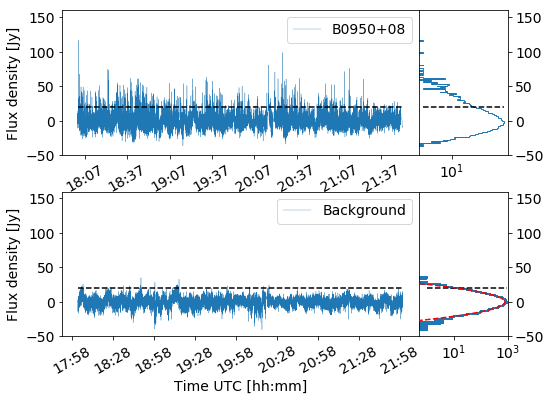

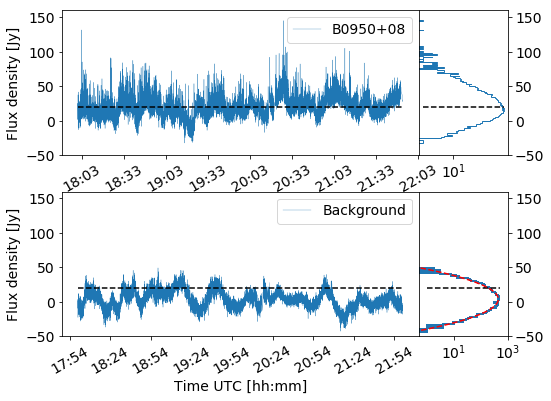

In [62]:




plt.rcParams['axes.facecolor'] = 'white'


roll_len = 2*60
roll_type = 'boxcar'

gs1 = gridspec.GridSpec(2, 2, width_ratios=[4, 1])
gs1.update(wspace=0.0, hspace=0.25)

import matplotlib.dates as mdates



# plt.subplot(121)


plt.figure( figsize=(8,6))
plt.subplot(gs1[0])

bool_index = (image_pyse.runcat == 1) &\
                        (image_pyse.freq_eff > 60000000) & (image_pyse.rms_min < 12)

_source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                  end=np.max(image_pyse[bool_index].taustart_ts),
                  freq="1S")]

_source_data = _source_data.dropna()

rolling = _source_data.f_int.rolling(roll_len, win_type=roll_type)


flux = _source_data.f_int-rolling.mean().values
flux = flux[np.isfinite(flux)]

plt.plot(flux, lw=0.3, label="B0950+08")

plt.subplot(gs1[1])

_hist = plt.hist(flux,bins=np.linspace(-60,150,200), orientation="horizontal", histtype="step", label=None)





ax = plt.subplot(gs1[0])
plt.plot([np.min(flux.index),np.max(flux.index)],[20.,20.],"--",c="k")
plt.ylim([-50,160])
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_tick_params(rotation=30)
plt.ylabel("Flux density [Jy]")
# plt.xlabel("Time UTC [hh:mm]")

plt.legend()   

# plt.figure(3, figsize=(10,6))
ax1 = plt.subplot(gs1[1])
plt.plot([1,np.max(_hist[0])],[20,20],"--", c="k")
plt.ylim([-50,160])
ax1.yaxis.tick_right()
ax1.set_xticklabels(["1","10","100"])

plt.xscale("log")
# plt.legend()




myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
# plt.ylabel("Flux density")
# plt.xlabel("Time [UTC]")

plt.subplot(gs1[2])

bool_index = (image_pyse.runcat == 4) &\
                        (image_pyse.freq_eff > 60000000) & (image_pyse.rms_min < 12)

_source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                  end=np.max(image_pyse[bool_index].taustart_ts),
                  freq="1S")]

_source_data = _source_data.dropna()

rolling = _source_data.f_int.rolling(roll_len, win_type=roll_type)


flux = _source_data.f_int-rolling.mean().values
flux = flux[np.isfinite(flux)]

plt.plot(flux, lw=0.3, label="Background")

plt.subplot(gs1[3])

_hist = plt.hist(flux, bins=np.linspace(-60,150,200), orientation="horizontal", histtype="step", label=None, lw=2)

(mu, sigma) = norm.fit(flux)
y = mlab.normpdf( _hist[1], mu, sigma)

plt.plot(np.sum(_hist[0])*y,_hist[1], "--", c="r", zorder=100)




ax = plt.subplot(gs1[2])
plt.plot([np.min(flux.index),np.max(flux.index)],[20.,20.],"--",c="k")
plt.ylim([-50,160])
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_tick_params(rotation=30)
plt.ylabel("Flux density [Jy]")
plt.xlabel("Time UTC [hh:mm]")

plt.legend()   

# plt.figure(3, figsize=(10,6))
ax1 = plt.subplot(gs1[3])
plt.plot([1,np.max(_hist[0])],[20,20],"--", c="k")
plt.ylim([-50,160])
plt.xlim([0.5,1000])

ax1.yaxis.tick_right()
ax1.set_xticklabels(["1","10","100"])

plt.xscale("log")
# plt.legend()

# plt.ylabel("Flux density")
# plt.xlabel("Time UTC [hh:mm]")
# plt.tight_layout()



plt.savefig("/home/kuiack/B0950+08_figs/FullLightcurve_sub.pdf")



plt.rcParams['axes.facecolor'] = 'white'


roll_len = 2*60
roll_type = 'boxcar'

gs1 = gridspec.GridSpec(2, 2, width_ratios=[4, 1])
gs1.update(wspace=0.0, hspace=.25)




# plt.subplot(121)


plt.figure( figsize=(8,6))
plt.subplot(gs1[0])

bool_index = (image_pyse.runcat == 1) &\
                        (image_pyse.freq_eff > 60000000) & (image_pyse.rms_min < 12)

_source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                  end=np.max(image_pyse[bool_index].taustart_ts),
                  freq="1S")]

_source_data = _source_data.dropna()

rolling = _source_data.f_int.rolling(roll_len, win_type=roll_type)


flux = _source_data.f_int#-rolling.mean().values
flux = flux[np.isfinite(flux)]

plt.plot(flux, lw=0.3, label="B0950+08")

plt.subplot(gs1[1])

_hist = plt.hist(flux,bins=np.linspace(-60,150,200), orientation="horizontal", histtype="step", label=None)





ax = plt.subplot(gs1[0])
plt.plot([np.min(flux.index),np.max(flux.index)],[20.,20.],"--",c="k")
plt.ylim([-50,160])
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_tick_params(rotation=30)
plt.ylabel("Flux density [Jy]")
# plt.xlabel("Time UTC [hh:mm]")

plt.legend()   

# plt.figure(3, figsize=(10,6))
ax1 = plt.subplot(gs1[1])
plt.plot([1,np.max(_hist[0])],[20,20],"--", c="k")
plt.ylim([-50,160])
ax1.yaxis.tick_right()
ax1.set_xticklabels(["1","10","100"])

plt.xscale("log")
# plt.legend()





# plt.ylabel("Flux density")
# plt.xlabel("Time [UTC]")

plt.subplot(gs1[2])

bool_index = (image_pyse.runcat == 2) &\
                        (image_pyse.freq_eff > 60000000) & (image_pyse.rms_min < 12)

_source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                  end=np.max(image_pyse[bool_index].taustart_ts),
                  freq="1S")]

_source_data = _source_data.dropna()

rolling = _source_data.f_int.rolling(roll_len, win_type=roll_type)


flux = _source_data.f_int#-rolling.mean().values
flux = flux[np.isfinite(flux)]

plt.plot(flux, lw=0.3, label="Background")

plt.subplot(gs1[3])

_hist = plt.hist(flux, bins=np.linspace(-60,150,200), orientation="horizontal", histtype="step", label=None, lw=2)

(mu, sigma) = norm.fit(flux)
y = mlab.normpdf( _hist[1], mu, sigma)

plt.plot(np.sum(_hist[0])*y,_hist[1], "--", c="r", zorder=100)




ax = plt.subplot(gs1[2])
plt.plot([np.min(flux.index),np.max(flux.index)],[20.,20.],"--",c="k")
plt.ylim([-50,160])
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_tick_params(rotation=30)
plt.ylabel("Flux density [Jy]")
plt.xlabel("Time UTC [hh:mm]")

plt.legend()   

# plt.figure(3, figsize=(10,6))
ax1 = plt.subplot(gs1[3])
plt.plot([1,np.max(_hist[0])],[20,20],"--", c="k")
plt.ylim([-50,160])
plt.xlim([0.5,1000])

ax1.yaxis.tick_right()
# ax1.set_xticklabels(["1","10","100"])

plt.xscale("log")
# plt.legend()



# plt.ylabel("Flux density")
# plt.xlabel("Time UTC [hh:mm]")
# plt.tight_layout()

plt.savefig("/home/kuiack/B0950+08_figs/FullLightcurve_raw.pdf")

/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


1 20.2683990711
2 4.05988673832
103 4.4425550545
111 1.63846844531
114 -0.873957039276


/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:64: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


(-60, 125)

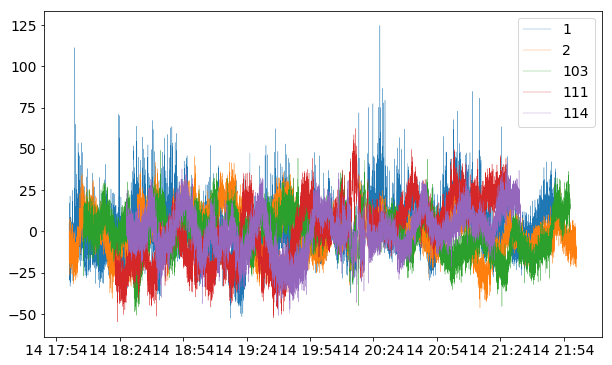

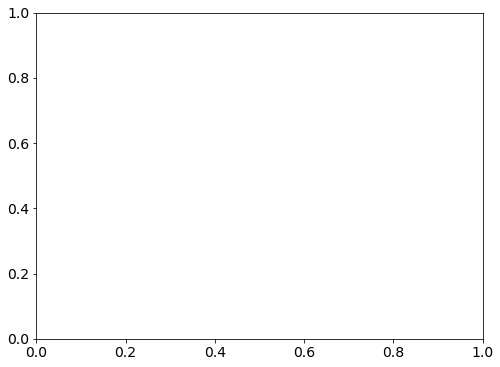

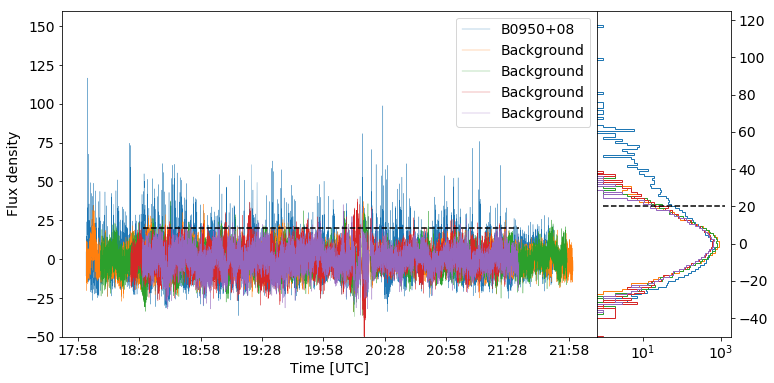

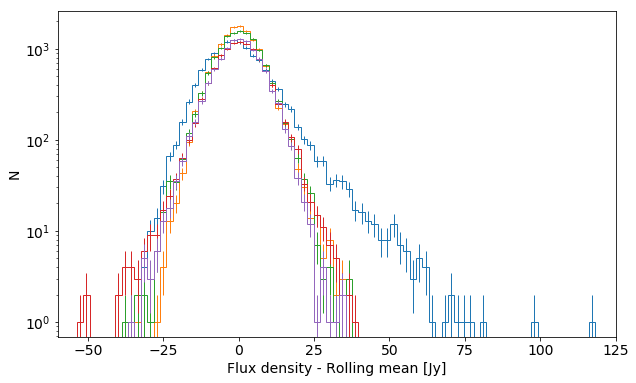

In [96]:





for i in [1, 2, 103,111,114]:


    plt.figure(1, figsize=(10,6))
    bool_index = (image_pyse.runcat == i) &\
                            (image_pyse.freq_eff > 60000000) & (image_pyse.rms_min < 12)

    _source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                      end=np.max(image_pyse[bool_index].taustart_ts),
                      freq="1S")]

    _source_data = _source_data.dropna()

#     rolling = _source_data.f_int.rolling(roll_len, win_type=roll_type)

    print i, np.mean(_source_data.f_int)
    flux = _source_data.f_int-np.mean(_source_data.f_int)#rolling.mean().values
    flux = flux[np.isfinite(flux)]
    
#     plt.plot((flux*1000.)/55.35, lw=0.3, label=i)
    plt.plot(flux, lw=0.3, label=i)
    plt.figure(2, figsize=(10,6))
#     plt.hist( (flux*1000.)/55.35,bins=np.linspace(-1000,2500,100),  histtype="step", label=str(i))
    plt.hist(flux,bins=np.linspace(-60,150,200),  histtype="step", label=str(i))
    
    
plt.figure(1, figsize=(10,6))
plt.legend()    
plt.figure(2, figsize=(10,6))
plt.yscale("log")
plt.legend()


roll_len = 2*60
roll_type = 'boxcar'

gs1 = gridspec.GridSpec(1, 2, width_ratios=[4, 1])
gs1.update(wspace=0.0, hspace=0.0)

import matplotlib.dates as mdates


# plt.subplot(121)
plt.subplot(gs1[0])
ci = 0
for i in [1, 2, 103,111,114]:

    if i == 1:
        label = "B0950+08"
    else: 
        label = "Background"

    plt.figure(3, figsize=(12,6))
    plt.subplot(gs1[0])
    
    bool_index = (image_pyse.runcat == i) &\
                            (image_pyse.freq_eff > 60000000) & (image_pyse.rms_min < 12)

    _source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                      end=np.max(image_pyse[bool_index].taustart_ts),
                      freq="1S")]

    _source_data = _source_data.dropna()

    rolling = _source_data.f_int.rolling(roll_len, win_type=roll_type)

    
    flux = _source_data.f_int-rolling.mean().values
    flux = flux[np.isfinite(flux)]

#     plt.plot((flux*1000.)/55.35, lw=0.3, label=i)
    plt.plot(flux, lw=0.3, label=label)
#     plt.figure(4, figsize=(10,6))
    plt.subplot(gs1[1])
#     plt.hist( (flux*1000.)/55.35,bins=np.linspace(-1000,2500,100),  histtype="step", label=str(i))
    _hist = plt.hist(flux,bins=np.linspace(-60,150,200), orientation="horizontal", histtype="step", label=None)
    plt.figure(4, figsize=(10,6))
    _hist = plt.hist(flux,bins=np.linspace(-60,150,100), histtype="step", 
                     label=None, color="C{}".format(ci))
    mid = 0.5*(_hist[1][1:] + _hist[1][:-1])
    plt.errorbar(mid, _hist[0], yerr=np.sqrt(_hist[0]), fmt='none',c="C{}".format(ci),elinewidth=1)
    ci+=1

plt.figure(3, figsize=(10,6))
ax = plt.subplot(gs1[0])
plt.plot([np.min(flux.index),np.max(flux.index)],[20.,20.],"--",c="k")
plt.ylim([-50,160])
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.ylabel("Flux density")
plt.xlabel("Time [UTC]")

plt.legend()    
# plt.figure(3, figsize=(10,6))
ax1 = plt.subplot(gs1[1])
plt.plot([1,np.max(_hist[0])],[20,20],"--", c="k")
plt.ylim([-50,125])
ax1.yaxis.tick_right()
ax1.set_xticklabels(["1","10","100"])

plt.xscale("log")
# plt.legend()
plt.figure(4, figsize=(8,6))
plt.yscale("log")
plt.xlabel("Flux density - Rolling mean [Jy]")
plt.ylabel("N")
plt.xlim([-60,125])

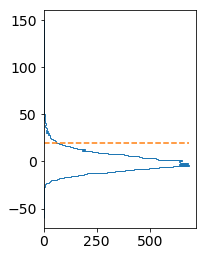

In [66]:
plt.subplot(122)
x = plt.hist(flux,bins=np.linspace(-60,150,200),  histtype="step", orientation="horizontal", label=label)
plt.plot([1,np.max(_hist[0])],[20,20],"--")

-5.52338693857e-16 11.9823672452


/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


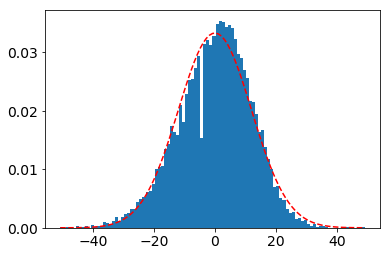

In [56]:
i = 103
bool_index = (image_pyse.runcat == i) &\
                        (image_pyse.freq_eff > 60000000) & (image_pyse.rms_min < 12)

_source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                  end=np.max(image_pyse[bool_index].taustart_ts),
                  freq="1S")]

_source_data = _source_data.dropna()



flux = _source_data.f_int-np.mean(_source_data.f_int)#rolling.mean().values
flux = flux[np.isfinite(flux)]


(mu, sigma) = norm.fit(flux)
#     n, bins, patches   =  plt.hist(source_df["f_int"].values[hist_index],
#                                    bins=100,normed=1, orientation='horizontal',facecolor="#1f77b4")

print mu, sigma
# plt.subplot(122)

n, bins, patches   =  plt.hist((flux), bins=100, normed=1)
y = mlab.normpdf( bins, mu, sigma)

plt.plot(bins,y, "--", c="r")

<ErrorbarContainer object of 3 artists>

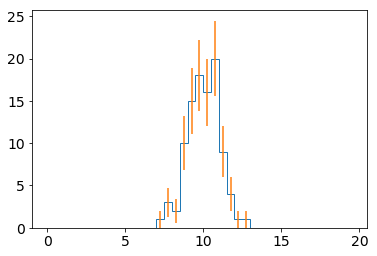

In [199]:
data = np.random.normal(10,1,100)
n, bins, _ = plt.hist(data, bins=np.arange(0,20,0.5), histtype="step")
mid = 0.5*(bins[1:] + bins[:-1])
plt.errorbar(mid, n, yerr=np.sqrt(n), fmt='none')

In [201]:
np.sqrt(n)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        1.73205081,  1.41421356,  3.16227766,  3.87298335,  4.24264069,
        4.        ,  4.47213595,  3.        ,  2.        ,  1.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:49: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


N datapoints 13205.0
B0950+08 mean 20.2683990711
Background mu: 0.014, Sigma: 7.088
13556.0
[  2.36041024e+05  -2.82479873e+00]
[  1.39227560e+04  -2.05936582e+00]


/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in sqrt


(-40, 120)

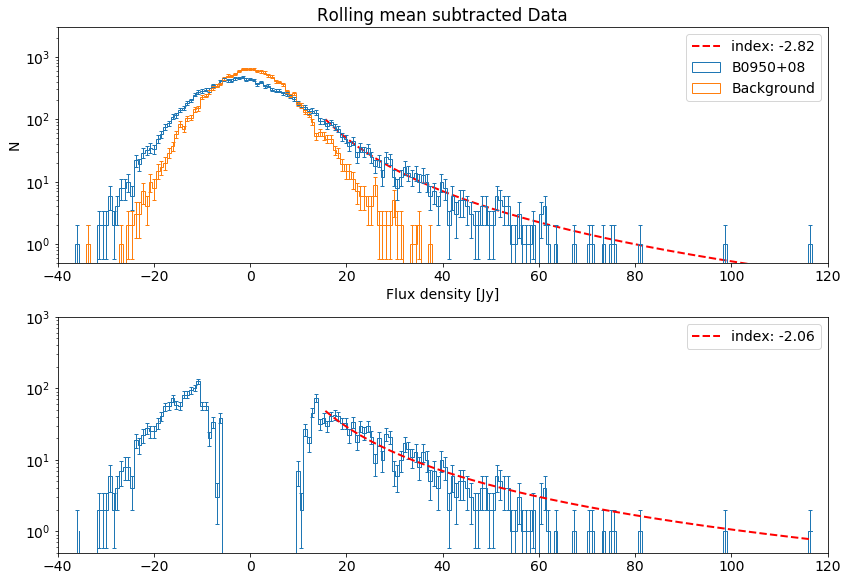

In [125]:

roll_len =2*60
roll_type = 'boxcar'

_f_limit = 15

i = 1

fig = plt.figure(figsize=(12,8))
plt.subplot(211)
fig.patch.set_facecolor('White')
plt.title("Rolling mean subtracted Data")

bool_index = (image_pyse.runcat == i) &\
                        (image_pyse.freq_eff > 60000000) & (image_pyse.rms_min < 12)

_source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                  end=np.max(image_pyse[bool_index].taustart_ts),
                  freq="1S")]

_source_data = _source_data.dropna()

rolling = _source_data.f_int.rolling(roll_len, win_type=roll_type)


# mean sub
# flux = _source_data.f_int-np.mean(_source_data.f_int)#rolling.mean().values
# rolling mean sub
flux = _source_data.f_int-rolling.mean().values

flux = flux[np.isfinite(flux)]

_1_n = plt.hist( flux,bins=200,  histtype="step", label="B0950+08")

mid = 0.5*(_1_n[1][1:] + _1_n[1][:-1])
plt.errorbar(mid, _1_n[0], yerr=np.sqrt(_1_n[0]), fmt='none', c="C0", elinewidth=1, capsize=2)



print "N datapoints", np.sum(_1_n[0])
print "B0950+08 mean", np.mean(_source_data.f_int)
####

i = 2

bool_index = (image_pyse.runcat == i) &\
                        (image_pyse.freq_eff > 60000000) & (image_pyse.rms_min < 12)

_source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                  end=np.max(image_pyse[bool_index].taustart_ts),
                  freq="1S")]

_source_data = _source_data.dropna()

rolling = _source_data.f_int.rolling(roll_len, win_type=roll_type)


# mean sub
# flux = _source_data.f_int-np.mean(_source_data.f_int)#rolling.mean().values
# rolling mean sub
flux = _source_data.f_int-rolling.mean().values

flux = flux[np.isfinite(flux)]

(mu, sigma) = norm.fit(flux)
print "Background mu: {}, Sigma: {}".format(round(mu,3), round(sigma,3))

_103_n = plt.hist( flux,bins=_1_n[1],  histtype="step", label="Background")

mid = 0.5*(_103_n[1][1:] + _103_n[1][:-1])
plt.errorbar(mid, _103_n[0], yerr=np.sqrt(_103_n[0]), fmt='none', c="C1", elinewidth=1, capsize=2)

y = mlab.normpdf( _103_n[1], mu, sigma)
# plt.plot(_103_n[1],np.sum(_103_n[0])*y, "-.", c="grey")

print np.sum(_103_n[0])

fit, cov = curve_fit(powlaw, _1_n[1][1:][(_1_n[1][1:] > _f_limit)],_1_n[0][_1_n[1][1:] > _f_limit])

print fit




plt.plot(_1_n[1][1:][(_1_n[1][1:] > _f_limit)],
         powlaw(_1_n[1][1:][(_1_n[1][1:] > _f_limit)], fit[0],fit[1]),
         "--", c="r",lw =2, label="index: {}".format(round(fit[1],2)), zorder =0 )
# plt.ylim([0.5,600])
plt.ylim([0.5,3000])
plt.xlim([-40,120])


plt.yscale("log")
plt.xlabel("Flux density [Jy]")
plt.ylabel("N")
plt.legend()
plt.tight_layout()


# plt.figure(figsize=(10,6))
plt.subplot(212)
plt.step(_1_n[1][1:],_1_n[0]-_103_n[0], lw=1)

mid = 0.5*(_103_n[1][1:] + _103_n[1][:-1])
plt.errorbar(mid, _1_n[0]-_103_n[0], 
             yerr=np.sqrt(_1_n[0]-_103_n[0]), 
             fmt='none', c="C0", elinewidth=1, capsize=2)


plt.yscale("log")
# plt.xlabel()

_fluxbin = _1_n[1][1:]

_diff = _1_n[0]-_103_n[0]

fit, cov = curve_fit(powlaw, _fluxbin[(_fluxbin > _f_limit)],_diff[_fluxbin > _f_limit])

print fit

plt.plot(_fluxbin[(_fluxbin > _f_limit)],
         powlaw(_fluxbin[(_fluxbin > _f_limit)], fit[0],fit[1]),
         "--", c="r",lw =2, label="index: {}".format(round(fit[1],2)) )

plt.yscale("log")
plt.legend()
plt.ylim([0.5,1000])
plt.xlim([-40,120])
# plt.xscale("log")

# plt.xlim([0,2500])
# plt.savefig("/home/kuiack/B0950+08_figs/SBPL_N{}_a{}_b{}.png".format(_BGsize,alpha_2,x_break))


In [11]:
from astropy.modeling.powerlaws import SmoothlyBrokenPowerLaw1D as SBPL

def random_custDist(x0,x1,custDist,size=None, nControl=10**6):
    #genearte a list of size random samples, obeying the distribution custDist
    #suggests random samples between x0 and x1 and accepts the suggestion with probability custDist(x)
    #custDist noes not need to be normalized. Add this condition to increase performance. 
    #Best performance for max_{x in [x0,x1]} custDist(x) = 1
    norm = np.max(custDist(np.linspace(x0,x1,10000)))+0.1
    
    samples=[]
    nLoop=0
    while len(samples)<size:# and nLoop<nControl:
        x=np.random.uniform(low=x0,high=x1)
        prop=custDist(x)/norm
        try:
            assert prop>=0 and prop<=1
        except AssertionError: 
            print x, custDist(x), norm,
            return
        if np.random.uniform(low=0,high=1) <=prop:
            samples += [x]
        nLoop+=1
    return samples

def rndm(a, b, g, size=1):
    """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)

In [68]:
D = {"_loc" : 0.,
     "_scale": 12.,
     "x0" : 0,
     "x1" : 150,
     "amplitude": 10,
     "x_break": 30,
     "alpha_1": -4.5,
     "alpha_2": 4.3,
     "delta": 0.12,
     "_GP_fraction" : 0.05,
     "_BGsize" : 130000
    }

##  Simulate the measured results directly

1300
13000.0
12998.0
[  4.85623492e+07  -4.60880352e+00]
[ 8.64644071 -0.89532547]


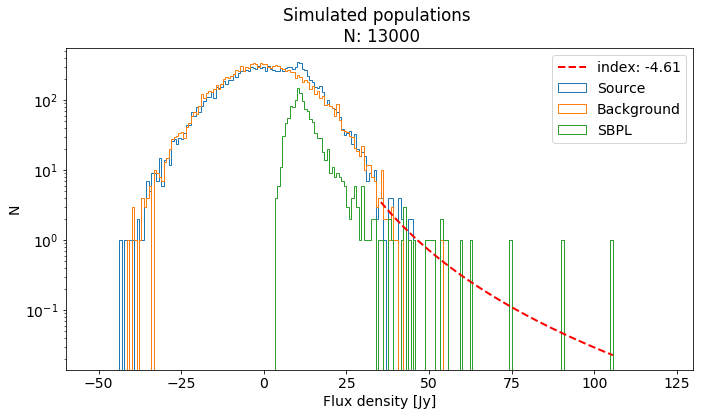

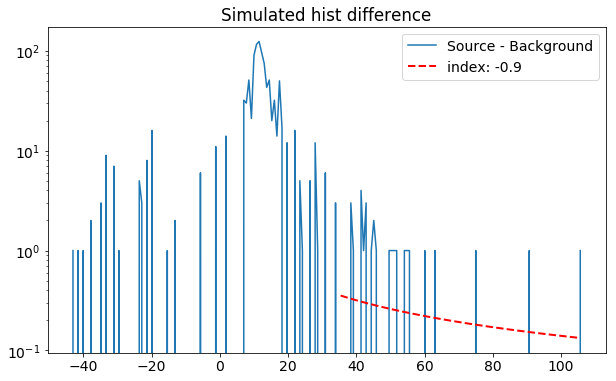

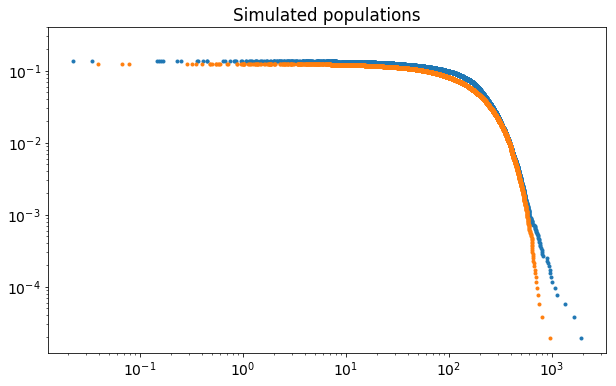

In [89]:

_loc = 0.
_scale = 12.


x0 = 0
x1 = 150
amplitude= 10
x_break= 10
alpha_1= -4.5
alpha_2= 4.3
delta= 0.12


_GP_fraction = 0.1
_BGsize = 13000



fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('White')

plt.title("Simulated populations \n N: {}".format(_BGsize))

# pop =  np.random.normal(loc=_loc, scale=_scale,  size=_BGsize)

# pop[np.random.choice(np.where(pop > 0)[0], size=int(_BGsize*_GP_fraction), replace=False)] = \
# pop = rndm(500, 3000, -4, size=int(_BGsize*_GP_fraction))

# pop_SBPL = random_custDist(x0,x1,custDist=SBPL(amplitude=amplitude, 
#                                             x_break=x_break,
#                                             alpha_1=alpha_1, 
#                                             alpha_2=alpha_2, 
#                                             delta=delta),
#                         size=int(_BGsize*_GP_fraction))

# pop = rndm(200, 100000, -4, size=int(_BGsize*_GP_fraction))
# pop = np.random.lognormal(1.5,1,size=int(_BGsize*_GP_fraction))
# pop = np.random.normal(loc=350, scale=600, 
#                                  size=int(_BGsize*_GP_fraction))


pop = np.append(np.random.normal(loc=_loc, scale=_scale, 
                                 size=_BGsize- int(_BGsize*_GP_fraction)), pop_SBPL)

print int(_BGsize*_GP_fraction)
x_source=plt.hist(pop, bins=200,  histtype="step", label="Source")

print(np.sum(x_source[0]))

bg_pop = np.random.normal(loc=_loc, scale=_scale, size=_BGsize)

x_bg=plt.hist(bg_pop, 
              bins=x_source[1],  histtype="step", label="Background")

print(np.sum(x_bg[0]))



x_SBPL = plt.hist(pop_SBPL,
         bins=x_source[1],  histtype="step", label="SBPL")


fit, cov = curve_fit(powlaw, x_source[1][1:][(x_source[1][1:] > 35)],x_source[0][x_source[1][1:] > 35])

print fit

_f_limit = 35
plt.plot(x_source[1][1:][(x_source[1][1:] > _f_limit)],
         powlaw(x_source[1][1:][(x_source[1][1:] > _f_limit)], fit[0],fit[1]),
         "--", c="r",lw =2, label="index: {}".format(round(fit[1],2)) )


# plt.ylim([0.5,600])
plt.xlim([-60,130])


plt.legend()
plt.yscale("log")
plt.xlabel("Flux density [Jy]")
plt.ylabel("N")
plt.tight_layout()



fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('White')
plt.title("Simulated hist difference")

plt.plot(x_source[1][1:],x_source[0]-x_bg[0], label="Source - Background")
plt.yscale("log")


_fluxbin = x_source[1][1:]

_diff = x_source[0]-x_bg[0]

fit, cov = curve_fit(powlaw, _fluxbin[(_fluxbin > 35)],_diff[_fluxbin > 35])

print fit

plt.plot(_fluxbin[(_fluxbin > 35)],
         powlaw(_fluxbin[(_fluxbin > 35)], fit[0],fit[1]),
         "--", c="r",lw =2, label="index: {}".format(round(fit[1],2)) )
plt.legend()



fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('White')
plt.title("Simulated data")

x = np.sort((pop) *1000.)/55.35
# x_s.append(x)
y = np.array((1.+np.array(range(len(x))[::-1])))/(4.*len((x)))

plt.plot(x,y,".")
x = np.sort((bg_pop) *1000.)/55.35
# x_s.append(x)
y = np.array((1.+np.array(range(len(x))[::-1])))/(4.*len((x)))

plt.plot(x,y,".")

plt.title("Simulated populations")
plt.xscale("log")
plt.yscale("log")




# plt.figure(figsize=(10,6))
# plt.step(x_source[1][1:],x_source[0]-x_bg[0] )
# # plt.yscale("log")


# _fluxbin = x_source[1][1:]

# _diff = x_source[0]-x_bg[0]

# fit, cov = curve_fit(powlaw, _fluxbin[(_fluxbin > 600)],_diff[_fluxbin > 600])

# print fit

# plt.plot(_fluxbin[(_fluxbin > 600)],
#          powlaw(_fluxbin[(_fluxbin > 600)], fit[0],fit[1]),
#          "--", c="r",lw =2, label="index: {}".format(round(fit[1],2)) )

# plt.yscale("log")
# plt.legend()
# # plt.ylim([0.1,100])

# plt.xlim([0,2500])
# plt.xlim([0,max(x_source[1])])

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/astropy/modeling/powerlaws.py:285: RuntimeWarning: invalid value encountered in log
  logt = np.log(xx) / delta
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/astropy/modeling/powerlaws.py:294: RuntimeWarning: invalid value encountered in greater
  i = logt > threshold
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/astropy/modeling/powerlaws.py:301: RuntimeWarning: invalid value encountered in less
  i = logt < -threshold
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/astropy/modeling/powerlaws.py:308: RuntimeWarning: invalid value encountered in less_equal
  i = np.abs(logt) <= threshold


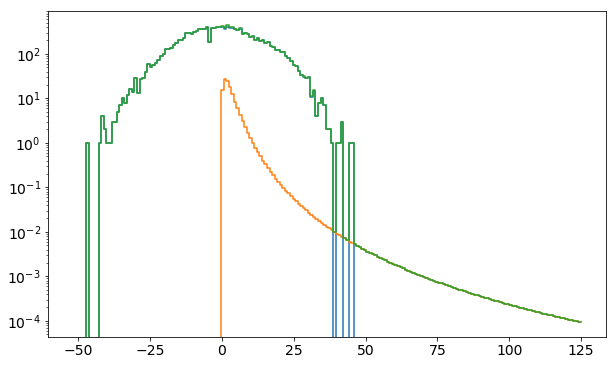

In [40]:


f = SBPL(amplitude=20, x_break=3, 
     alpha_1=-2, 
     alpha_2=4.2, 
         delta=0.8)

def broke_powlaw(x,a,x_b,a_1,a_2,d):
    _f = SBPL(amplitude=a, x_break=x_b,
              alpha_1=a_1, alpha_2=a_2,
              delta=d) 
    return _f(x)
    
# plt.plot(np.linspace(-100,100,200), 
#          f(np.linspace(-100,100,200)))

# plt.hist(f(np.linspace(-100,1000,20000)), cumulative=True, log = True, normed= True, bins=)

plt.figure(figsize=(10,6))

plt.step(_103_n[1][1:],_103_n[0])

plt.step(_103_n[1][1:],f(_103_n[1][1:]))



plt.step(_103_n[1][1:],_103_n[0]+f(_103_n[1][1:]))


plt.yscale("log")
# plt.xscale("log")



In [48]:
pop = rndm(1, 150, -4, size=13000)

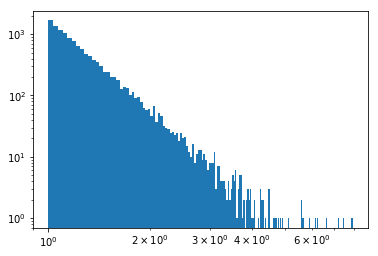

In [49]:
x = plt.hist(pop, log=True,bins=200)
plt.xscale("log")

## Simulate the 'truth' and apply noise


In [268]:


# Normal  params 
_loc = 0.
_scale = 7.

# Smooth broken power-law params 
x0 = 0
x1 = 150
amplitude= 10
x_break= 20
alpha_1= -1
alpha_2= 4
delta= 0.1




# Observation parameters 
_GP_fraction = 0.5
_BGsize = 13000

##
# for x_break in np.arange(10,40,2):
t1 = time.time()

BG_truth = np.zeros(_BGsize)
BG_noise = np.random.normal(loc=_loc, scale=_scale, 
                                 size=_BGsize)

BG_measure = BG_truth + BG_noise

# Smooth Broken Power-law
# Source_truth = random_custDist(x0,x1,custDist=SBPL(amplitude=amplitude, 
#                                             x_break=x_break,
#                                             alpha_1=alpha_1, 
#                                             alpha_2=alpha_2, 
#                                             delta=delta),
#                         size=int(_BGsize))

# Power-law 
Source_truth =  rndm(x_break, 150, -alpha_2, size=int(_BGsize))


Source_noise = np.random.normal(loc=_loc, scale=_scale, 
                                 size=_BGsize)

Source_measure = Source_truth + Source_noise

print round(time.time() - t1,3), "s"






# plt.figure(figsize=(10,10))
# plt.subplot(211)
# plt.title("Simulated Populations")


# hist_source  = plt.hist(Source_measure-np.mean(Source_measure), bins=200,  histtype="step", label="Source measured")



# hist_bg = plt.hist(BG_measure-np.mean(BG_measure), bins=hist_source[1],  histtype="step", label="Background")

# hist_source_t = plt.hist(Source_truth, bins=hist_source[1],  histtype="step", label="Source truth")


# _f_limit = x_break+1
# _fluxbin = hist_source_t[1][1:]

# _diff = hist_source_t[0]


# try:
#     fit, cov = curve_fit(powlaw, _fluxbin[(_fluxbin > _f_limit)],_diff[_fluxbin > _f_limit])

#     print fit

#     plt.plot(_fluxbin[(_fluxbin > _f_limit)],
#              powlaw(_fluxbin[(_fluxbin > _f_limit)], fit[0],fit[1]),
#              "--", c="r",lw =2, label="index: {}".format(round(fit[1],2)) )
# except RuntimeError:
#     print "runtime error"


# _fluxbin = hist_source[1][1:]

# _diff = hist_source[0]

# _f_limit = 20


# try:
#     fit, cov = curve_fit(powlaw, _fluxbin[(_fluxbin > _f_limit)],_diff[_fluxbin > _f_limit])

#     print fit

#     plt.plot(_fluxbin[(_fluxbin > _f_limit)],
#              powlaw(_fluxbin[(_fluxbin > _f_limit)], fit[0],fit[1]),
#              "--", c="r",lw =2, label="index: {}".format(round(fit[1],2)) )
# except RuntimeError:
#     print "runtime error"



# plt.yscale("log")
# plt.legend()
# # plt.ylim([0.5,1000])
# plt.xlim([-60,130])
# plt.xlabel("Flux density [Jy]")
# plt.ylabel("N")
# plt.tight_layout()


# plt.subplot(212)
# plt.title("Simulated hist difference")

# plt.plot(hist_source[1][1:],hist_source[0]-hist_bg[0], label="Source - Background")
# plt.yscale("log")


# _fluxbin = hist_source[1][1:]

# _diff = hist_source[0]-hist_bg[0]

# _f_limit = 20

# try:
#     fit, cov = curve_fit(powlaw, _fluxbin[(_fluxbin > _f_limit)],_diff[_fluxbin > _f_limit])

#     print fit

#     plt.plot(_fluxbin[(_fluxbin > _f_limit)],
#              powlaw(_fluxbin[(_fluxbin > _f_limit)], fit[0],fit[1]),
#              "--", c="r",lw =2, label="index: {}".format(round(fit[1],2)) )
# except RuntimeError:
#     print "runtime error"

# plt.legend()
# # plt.ylim([0.5,100])
# plt.xlim([-60,130])

# print("# Normal  params ",
# "_loc =", _loc,
# "_scale =", _scale, )
# # print("# Smooth broken power-law params",
# # "x_break =", x_break,
# # "alpha_2 =", alpha_2,
# # "delta =", delta,)

# print("# Power-law params",
# "x_break =", x_break,
# "alpha_2 =", alpha_2)

# print("# Observation parameters","_BGsize =", 13000)
# plt.title(x_break)
# plt.tight_layout()

# plt.savefig("/home/kuiack/B0950+08_figs/SBPL_N{}_a{}_b{}.png".format(_BGsize,alpha_2,x_break))

    # "# Observation parameters ","\n",
    # "_GP_fraction =", _GP_fraction,
    # "_BGsize =", _BGsize,"\n",)


0.006 s


[  1.81761474e+05  -2.79011832e+00]
[  6.68967303e+03  -1.86322124e+00]
('# Normal  params ', '_loc =', 0.0, '_scale =', 7.0)
('# Power-law params', 'x_break =', 20, 'alpha_2 =', 4)
('# Observation parameters', '_BGsize =', 13000)


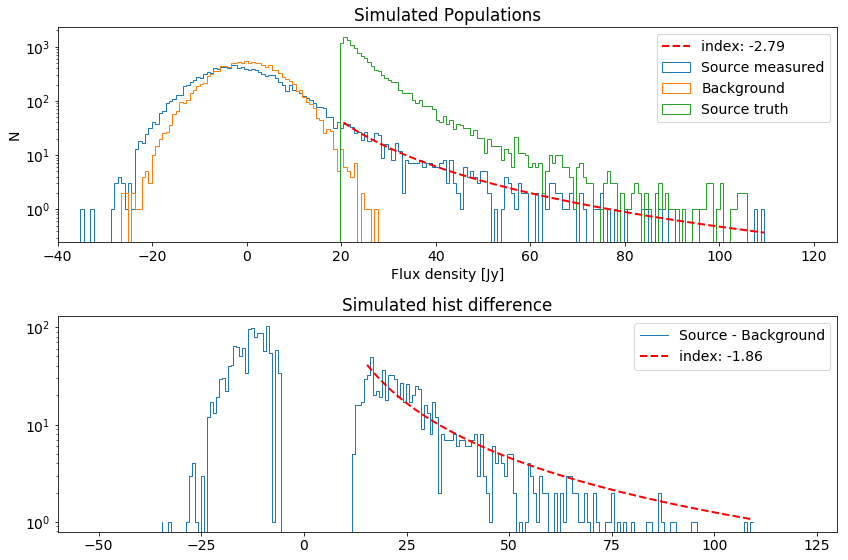

In [269]:

_f_limit = 20


fig = plt.figure(1, figsize=(12,8))
fig.patch.set_facecolor('White')
plt.subplot(211)
plt.title("Simulated Populations")


hist_source  = plt.hist(Source_measure-np.mean(Source_measure), bins=200,  histtype="step", label="Source measured")



hist_bg = plt.hist(BG_measure-np.mean(BG_measure), bins=hist_source[1],  histtype="step", label="Background")

hist_source_t = plt.hist(Source_truth, bins=hist_source[1],  histtype="step", label="Source truth")


_fluxbin = hist_source[1][1:]

_diff = hist_source[0]




try:
    fit, cov = curve_fit(powlaw, _fluxbin[(_fluxbin > _f_limit)],_diff[_fluxbin > _f_limit])

    print fit

    plt.plot(_fluxbin[(_fluxbin > _f_limit)],
             powlaw(_fluxbin[(_fluxbin > _f_limit)], fit[0],fit[1]),
             "--", c="r",lw =2, label="index: {}".format(round(fit[1],2)) )
except RuntimeError:
    print "runtime error"

    

plt.yscale("log")
plt.legend()
# plt.ylim([0.5,1000])
plt.xlim([-40,125])
plt.xlabel("Flux density [Jy]")
plt.ylabel("N")
plt.tight_layout()


# plt.figure(figsize=(10,6))
plt.subplot(212)
plt.title("Simulated hist difference")

plt.step(hist_source[1][1:],hist_source[0]-hist_bg[0], label="Source - Background", lw=1)
plt.yscale("log")


_fluxbin = hist_source[1][1:]

_diff = hist_source[0]-hist_bg[0]

_f_limit = 15

try:
    fit, cov = curve_fit(powlaw, _fluxbin[(_fluxbin > _f_limit)],_diff[_fluxbin > _f_limit])

    print fit

    plt.plot(_fluxbin[(_fluxbin > _f_limit)],
             powlaw(_fluxbin[(_fluxbin > _f_limit)], fit[0],fit[1]),
             "--", c="r",lw =2, label="index: {}".format(round(fit[1],2)) )
except RuntimeError:
    print "runtime error"
    
plt.legend()
# plt.ylim([0.5,100])
plt.xlim([-60,130])

print("# Normal  params ",
"_loc =", _loc,
"_scale =", _scale, )
# print("# Smooth broken power-law params",
# "x_break =", x_break,
# "alpha_2 =", alpha_2,
# "delta =", delta,)

print("# Power-law params",
"x_break =", x_break,
"alpha_2 =", alpha_2)

print("# Observation parameters","_BGsize =", 13000)
plt.tight_layout()
# "# Observation parameters ","\n",
# "_GP_fraction =", _GP_fraction,
# "_BGsize =", _BGsize,"\n",)

In [141]:
f = SBPL(amplitude=100,
         x_break=15,
         alpha_1=-2,
         alpha_2=4.2,
         delta=0.8)

In [127]:
f(np.random.uniform(low=0, high=100))/norm

0.0072278942371689411

In [95]:
np.max(SBPL(amplitude=50, 
                                            x_break=500,
                                            alpha_1=-2, 
                                            alpha_2=3.8, 
                                            delta=0.8)(np.linspace(0,2500,10000)))

62.752841795085338

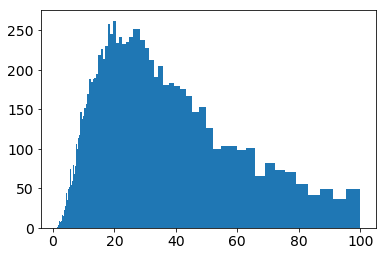

In [43]:
x = plt.hist(samples, bins=np.logspace(0,2,100))
# plt.xscale("log")
# plt.yscale("log")

In [20]:
x=np.random.uniform(low=5,high=50)
f(x)

24.121789802313337

In [29]:
print (f.amplitude)
print(np.max(f(np.linspace(0,50,1000))))


Parameter('amplitude', value=20.0, bounds=(0, None))
25.1011325456


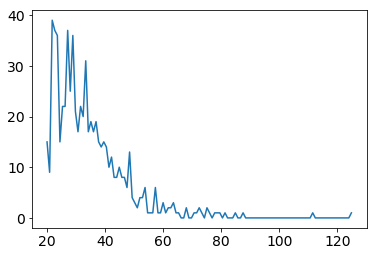

In [502]:
plt.plot(_fluxbin[(_fluxbin > 20)],_diff[_fluxbin > 20])

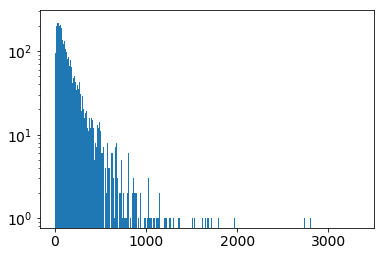

In [231]:
x =plt.hist(100*np.random.lognormal(0,1,10000), bins=1000, log=True)
# plt.xscale("log")

In [448]:
x = np.array([1,2,3,4,5,6,7,8,9,10])

np.random.choice(np.where(x > 5)[0], size=3, replace=False)

array([5, 8, 7])

In [443]:
np.where(x > 5)[0]

array([5, 6, 7, 8, 9])

In [131]:
from scipy import interpolate, signal
fa = interpolate.interp1d(x_s[0],y_s[0])

fb = interpolate.interp1d(x_s[1],y_s[1])

<IPython.core.display.Javascript object>


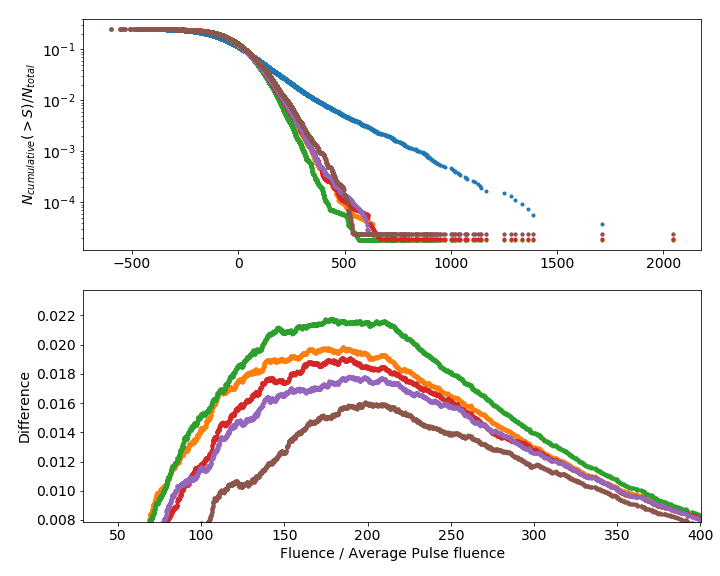

In [259]:
from scipy import interp

i_1 = 0
i_2 = 4




plt.figure(figsize=(10,8))

plt.subplot(211)
plt.plot(x_s[i_1], y_s[i_1], ".")
for i in [1,2,3,4,5]:
    plt.subplot(211)
    plt.plot(x_s[i_1],interp(x_s[i_1],x_s[i],y_s[i]), ".",c="C{}".format(str(i)))
    # plt.xlim(-600, 5000)
    plt.yscale("log")
    plt.ylabel(r"$N_{cumulative}( > S)/N_{total}$")

    plt.subplot(212)
    plt.plot(x_s[i_1], y_s[i_1] -interp(x_s[i_1],x_s[i],y_s[i]), ".",c="C{}".format(str(i)))
    plt.ylabel("Difference")
    # plt.xlim(-600, 5000)
    # plt.xscale("log")
#     plt.yscale("log")

plt.xlabel("Fluence / Average Pulse fluence")
plt.tight_layout()
plt.savefig("/home/kuiack/B0950+08_figs/dist_subtract_bgsub.png")
plt.show()

In [30]:
for i in [1, 2, 4, 103, 114, 111]:

    bool_index = (image_pyse.runcat == i) &\
                            (image_pyse.freq_eff > 60000000)

    print np.min(image_pyse[bool_index].taustart_ts), np.max(image_pyse[bool_index].taustart_ts)
    print len(pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                      end=np.max(image_pyse[bool_index].taustart_ts),
                      freq="1s"))

2018-04-14 18:00:00 2018-04-14 21:51:52
13913
2018-04-14 18:00:00 2018-04-14 21:59:59
14400
2018-04-14 18:00:00 2018-04-14 21:59:59
14400
2018-04-14 18:06:52 2018-04-14 21:57:04
13813
2018-04-14 18:27:17 2018-04-14 21:33:33
11177
2018-04-14 18:21:43 2018-04-14 21:26:59
11117


In [89]:
bool_index = (image_pyse.runcat == 111) &\
                        (image_pyse.freq_eff > 60000000)
    
_source_data = image_pyse[bool_index]
_source_data = _source_data.dropna()
    
    
    
min_range = pd.date_range(start=np.min(_source_data.taustart_ts),
                      end=np.max(_source_data.taustart_ts),
                      freq="1S")

In [22]:

image_pyse.groupby("runcat").mean()

image_pyse.groupby("runcat").mean().to_csv("/home/kuiack/PRS_monitor_out.csv")

In [27]:
image_pyse.groupby("runcat").mean().to_csv("~/monitor_follow.csv")

In [269]:
obs_result = pd.read_csv("/home/kuiack/PSR_observations.csv")
obs_result[obs_result.trap == 0].sort_values("obs_count", ascending=False)


Unnamed: 0  obs_count                                           obs_list  \
231         231      12147  /mnt/nex1/data/vis_archive/201903091947/300-20...   
110         110      11824  /mnt/nex0/data/vis_archive/201903081700/300-20...   
224         224      10807  /mnt/nex1/data/vis_archive/201812160230/300-20...   
287         289      10551  /mnt/nex1/data/vis_archive/201904201815/300-20...   
337         340      10550                   /mnt/ais003/300-201905181100.cal   
363         366      10066                   /mnt/ais003/300-201906041530.cal   
383         387       9735                   /mnt/ais003/300-201906111508.cal   
14           14       9533  /mnt/nex2/data/vis_archive/201902232216/300-20...   
276         278       9458  /mnt/nex1/data/vis_archive/201804261245/300-20...   
62           62       9341  /mnt/nex2/data/vis_archive/201803272014/300-20...   
236         236       9297  /mnt/nex1/data/vis_archive/201902242216/300-20...   
371         375       9135                   /mnt/ais003/300-201905121100.cal   
76           76       8928  /mnt/nex0/data/vis_archive/201806291215/300-20...   
316         318       8917                   /mnt/ais003/300-201905111110.cal   
135         135       8891  /mnt/nex0/data/vis_archive/201901/300-20190130...   
88           88       8719  /mnt/nex0/data/vis_archive/201902010000/300-20...   
259         261       8288  /mnt/nex1/data/vis_archive/201904171300/300-20...   
229         229       8042  /mnt/nex1/data/vis_archive/201902262216/300-20...   
154         154       7668  /mnt/nex0/data/vis_archive/201807071401/300-20...   
91           91       6948  /mnt/nex0/data/vis_archive/201902080002/300-20...   
8             8       6747  /mnt/nex2/data/vis_archive/201902030025/300-20...   
20           20       6638  /mnt/nex2/data/vis_archive/201705311300/300-20...   
283         285       6476  /mnt/nex1/data/vis_archive/201804241908/300-20...   
258         260       6302  /mnt/nex1/data/vis_archive/201903111815/300-20...   
70           70       6206  /mnt/nex2/data/vis_archive/201904141741/300-20...   
15           15       6067  /mnt/nex2/data/vis_archive/201903041640/300-20...   
38           38       6063  /mnt/nex2/data/vis_archive/201811/300-20181104...   
26           26       5993  /mnt/nex2/data/vis_archive/201811/300-20181128...   
102         102       5533  /mnt/nex0/data/vis_archive/201705311701/300-20...   
270         272       5442  /mnt/nex1/data/vis_archive/201804241407/300-20...   
..          ...        ...                                                ...   
139         139          0  /mnt/nex0/data/vis_archive/201805251015/300-20...   
137         137          0  /mnt/nex0/data/vis_archive/201803290800/300-20...   
136         136          0  /mnt/nex0/data/vis_archive/201901/300-20190130...   
118         118          0  /mnt/nex0/data/vis_archive/201901/300-20190104...   
114         114          0  /mnt/nex0/data/vis_archive/201904021342/300-20...   
170         170          0  /mnt/nex0/data/vis_archive/201903201621/300-20...   
113         113          0  /mnt/nex0/data/vis_archive/201903300942/300-20...   
112         112          0  /mnt/nex0/data/vis_archive/201903290540/300-20...   
111         111          0  /mnt/nex0/data/vis_archive/201903190500/300-20...   
109         109          0  /mnt/nex0/data/vis_archive/201902280435/300-20...   
108         108          0  /mnt/nex0/data/vis_archive/201902230515/300-20...   
107         107          0  /mnt/nex0/data/vis_archive/201902151515/300-20...   
143         143          0  /mnt/nex0/data/vis_archive/201805261000/300-20...   
146         146          0  /mnt/nex0/data/vis_archive/201805270715/300-20...   
147         147          0  /mnt/nex0/data/vis_archive/201805280550/300-20...   
148         148          0  /mnt/nex0/data/vis_archive/201805300415/300-20...   
149         149          0  /mnt/nex0/data/vis_archive/201805300901/300-20...   
150         150          0  /mnt/nex

### PyMC3 - fit GP powerlaw

In [129]:
import theano.tensor as tt
import pymc3 as pm
from scipy import stats

class ContinuousPowerLaw(pm.Continuous):
    R"""
    Discrete powerlaw distribution.
    
    Parameters
    ----------
    lower : float
        Lower limit.
    upper : float
        Upper limit (upper > lower).
    slope: float
        index of the power law
    """
    def __init__(self, lower, upper, slope, *args, **kwargs):
        super(self.__class__, self).__init__(*args, **kwargs)
        self.lower = tt.as_tensor_variable(lower)
        self.upper = tt.as_tensor_variable(upper)
        self.slope = tt.as_tensor_variable(slope)
        b = slope + 1
        if b == 0:
            self.norm = tt.log(upper / lower)
        else:
            self.norm = tt.as_tensor_variable(1. / b * (upper ** b - lower ** b))
            
    def random(self, point=None, size=None, repeat=None):
        lower, upper = pm.distributions.draw_values([self.lower, self.upper], point=point)
        return pm.distributions.generate_samples(powerlaw_rvs, self.slope, lower, upper, 
                                                 dist_shape=self.shape,
                                                 size=size)

    def logp(self, value):
        upper = self.upper
        lower = self.lower
        return pm.distributions.dist_math.bound(tt.log(value) * self.slope - tt.log(self.norm),
                     lower <= value, value <= upper)

def measured(loc, scale, Mmin, Mmax, slope, Dk ):
        noise = pm.distributions.generate_samples(stats.norm.rvs, loc=loc, scale=scale, size=len(Dk))
        truth = ContinuousPowerLaw("D_obs", lower=Mmin, upper=Mmax, slope=slope, shape=(len(Dk),), observed=Dk)
        return noise + truth 
    
    
def fit_lightcurve(y):
    with pm.Model() as model:

        (mu, sigma) = norm.fit(y)

        loc = pm.Normal("loc",mu, 20)
        scale = pm.HalfNormal("scale", sigma)
        
        Fmin = pm.Uniform("xbreak",lower=10, upper=35)
        Fmax = pm.Uniform("xmax",lower=125, upper=150)
        alpha = pm.Uniform("alpha", lower=-6, upper=-2)


#         turnover = pm.Deterministic("mode",sk_mode(loc,scale,skew))

#         _y = pm.SkewNormal("y_dist",mu=loc, sd=scale,alpha=skew, observed=y)

#         _y =  pm.Deterministic("y_dist", measured(loc, scale, Fmin, Fmax, alpha, y ))
        _flux = measured(loc, scale, Fmin, Fmax, alpha, y )

        trace = pm.sample(draws=500)

    return pm.summary(trace)[pm.summary(trace).index == "mode"]["mean"].values[0]
    pm.traceplot(trace)
    pm.summary(trace)

In [130]:
roll_len =1*60
roll_type = 'boxcar'

i = 1

bool_index = (image_pyse.runcat == i) &\
                        (image_pyse.freq_eff > 60000000) & (image_pyse.rms_min < 12)

_source_data = image_pyse[bool_index].set_index("taustart_ts").loc[pd.date_range(start=np.min(image_pyse[bool_index].taustart_ts),
                  end=np.max(image_pyse[bool_index].taustart_ts),
                  freq="1S")]

_source_data = _source_data.dropna()

rolling = _source_data.f_int.rolling(roll_len, win_type=roll_type)


flux = _source_data.f_int-rolling.mean().values
flux = flux[np.isfinite(flux)]

fit_lightcurve(flux)

/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.


TypeError: Variables do not support boolean operations.

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          3.,    1.,    2.,    6.,    2.,   12.,    8.,   23.,   25.,
         30.,   52.,   63.,   65.,   95.,  126.,  186.,  205.,  295.,
        295.,  305.,  390.,  423.,  432.,  498.,  491.,  511.,  513.,
        510.,  493.,  493.,  441.,  412.,  352.,  348.,  307.,  262.,
        226.,  186.,  144.,  138.,  109.,   92.,   66.,   57.,   48.,
         43.,   44.,   20.,   20.,   11.,   12.,   14.,    9.,   11.,
          8.,    3.,    5.,    7.,    5.,    2.,    2.,    7.,    3.,
          4.,    3.,    0.,    5.,    2.,    2.,    2.,    0.,    3.,
          1.,    1.,    0.,    0.,    0.,    0.,    1.,    1.,    2.,
          0.,    0.,    1.,    0.,    1.,    0.,    0.,    0.,    0.,
          1.,    0.

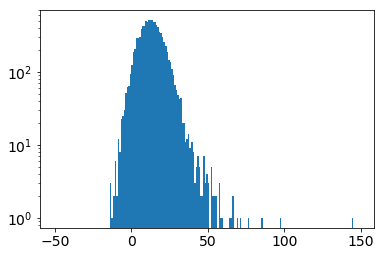

In [118]:
_x = plt.hist(pm.distributions.generate_samples(stats.norm.rvs, loc=0., scale=7., size=10000)\
              +pm.distributions.generate_samples(stats.beta, 10, 150, -4,size=10000), range(-50,150))
# plt.xscale("log")
print _x
plt.yscale("log")


In [109]:
def PM_rndm(a, b, g, size=1):
    """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
#     r = np.random.random(size=size)
    r = stats.uniform.rvs(0.00001,1.,size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)